In [1]:
import os
import sys
import babeltrace
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from IPython.display import display, clear_output

sys.path.append("/home/adlink/ros2-workspace/install/tracetools_read/lib/python3.8/site-packages/")
sys.path.append("/home/adlink/ros2-workspace/src/tracetools_analysis/tracetools_analysis/")
from tracetools_read.trace import *
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

In [2]:
path = os.path.expanduser("~/.ros/tracing/autoware-trace/")
file = load_file(path)

found converted file: /home/adlink/.ros/tracing/autoware-trace/converted


In [3]:
handler = Ros2Handler.process(file)


 [100%] [Ros2Handler]


In [5]:

self = handler.data
n=3
print('====================ROS 2 DATA MODEL===================')
print('Contexts:')
print(self.contexts[:n].to_string())
print()
print('Nodes:')
print(self.nodes[:n].to_string())
print()
print('Publishers (rmw):')
print(self.rmw_publishers[:n].to_string())
print()
print('Publishers (rcl):')
print(self.rcl_publishers[:n].to_string())
print()
print('Subscriptions (rmw):')
print(self.rmw_subscriptions[:n].to_string())
print()
print('Subscriptions (rcl):')
print(self.rcl_subscriptions[:n].to_string())
print()
print('Subscription objects:')
print(self.subscription_objects[:n].to_string())
print()
print('Services:')
print(self.services[:n].to_string())
print()
print('Clients:')
print(self.clients[:n].to_string())
print()
print('Timers:')
print(self.timers[:n].to_string())
print()
print('Timer-node links:')
print(self.timer_node_links[:n].to_string())
print()
print('Callback objects:')
print(self.callback_objects[:n].to_string())
print()
print('Callback symbols:')
print(self.callback_symbols[:n].to_string())
print()
print('Callback instances:')
print(self.callback_instances[:n].to_string())
print()
print('Publish instances (rclcpp):')
print(self.rclcpp_publish_instances[:n].to_string())
print()
print('Publish instances (rcl):')
print(self.rcl_publish_instances[:n].to_string())
print()
print('Publish instances (rmw):')
print(self.rmw_publish_instances[:n].to_string())
print()
print('Take instances (rmw):')
print(self.rmw_take_instances[:n].to_string())
print()
print('Take instances (rcl):')
print(self.rcl_take_instances[:n].to_string())
print()
print('Take instances (rclcpp):')
print(self.rclcpp_take_instances[:n].to_string())
print()
print('Lifecycle state machines:')
print(self.lifecycle_state_machines[:n].to_string())
print()
print('Lifecycle transitions:')
print(self.lifecycle_transitions[:n].to_string())
print('==================================================')


====================ROS 2 DATA MODEL===================
Contexts:
                           timestamp   pid version
context_handle                                    
578889920        1652795531158728529  9807   2.3.0
187651121439504  1652795532294150521  9844   2.3.0
187651140920480  1652795532303522314  9846   2.3.0

Nodes:
                           timestamp   tid       rmw_handle                      name                              namespace
node_handle                                                                                                                 
578605264        1652795531205345494  9807        578658512           launch_ros_9807                                      /
187651140946384  1652795532309089294  9846  187651141104576  system_monitor_container  /system/system_monitor/system_monitor
187651121479152  1652795532314980435  9844  187651121698368     robot_state_publisher                                      /

Publishers (rmw):
Empty DataFrame
Columns: []

In [ ]:
nodes = {row.name: row.to_dict() for _, row in handler.data.nodes.iterrows()}

df_pub = handler.data.rcl_publishers
df_sub = handler.data.rcl_subscriptions
topics_pub = {topic_name: {} for topic_name in df_pub['topic_name']}
topics_sub = {topic_name: {} for topic_name in df_sub['topic_name']}
topics = {**topics_pub, **topics_sub}

for topic_name, topic_dict in topics.items():
    topic_dict["pubs"] = [handle for handle in df_pub[df_pub['topic_name']==topic_name]['node_handle']]
    topic_dict["subs"] = [handle for handle in df_sub[df_sub['topic_name']==topic_name]['node_handle']]
    
# Aggregate topics that have the same pubs and subs
topic_cohorts = {}
for topic_name, topic_dict in topics.items():
    key = (frozenset({*topic_dict["pubs"]}), frozenset({*topic_dict["subs"]}))
    if key not in topic_cohorts:
        topic_cohorts[key] = []
    topic_cohorts[key].append(topic_name)
    
# Get Publisher frequencies
df_publications = handler.data.rcl_publish_instances
pub_stats = {}
for _, publication in df_publications.iterrows():
    hdl = publication['publisher_handle']
    if hdl not in pub_stats:
        pub_stats[hdl] = {'times': []}
    pub_stats[hdl]['times'].append(publication['timestamp']*1e-9) # Nanoseconds to seconds float

<ipython-input-27-0c38c906b61b>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,5))
<ipython-input-27-0c38c906b61b>:4: RuntimeWarning: Mean of empty slice.
  v['period'] = pub_time_diff.mean()


#Topics: 161; #Cohorts: 78


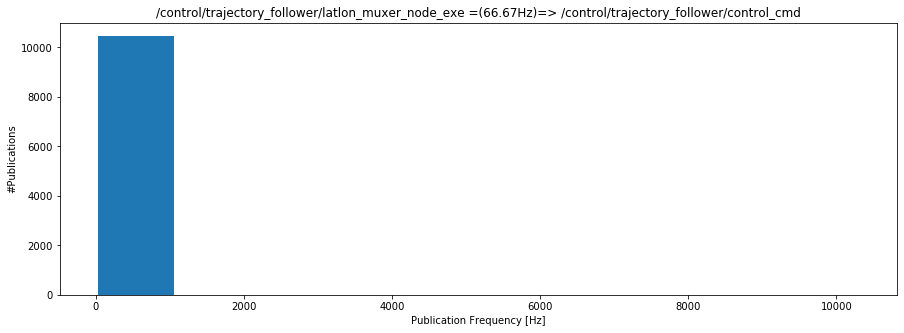

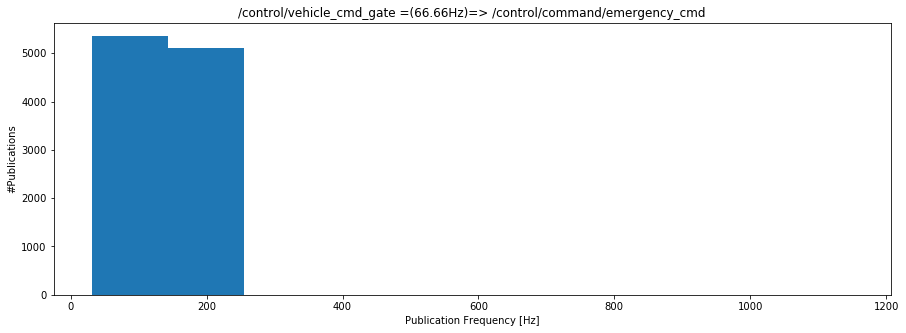

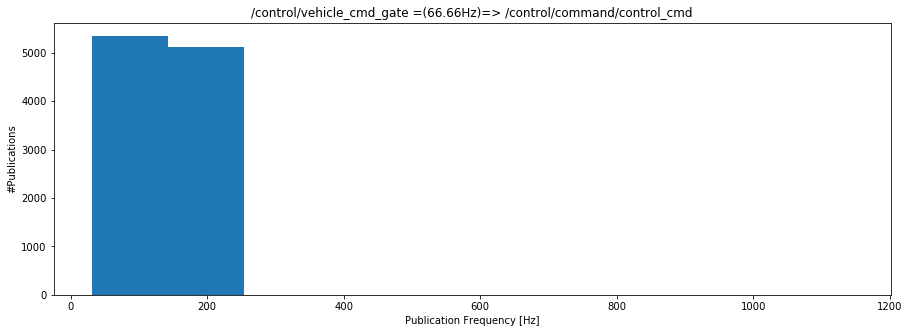

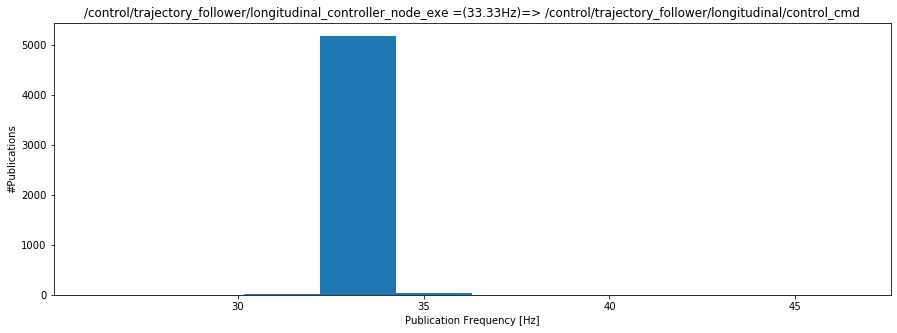

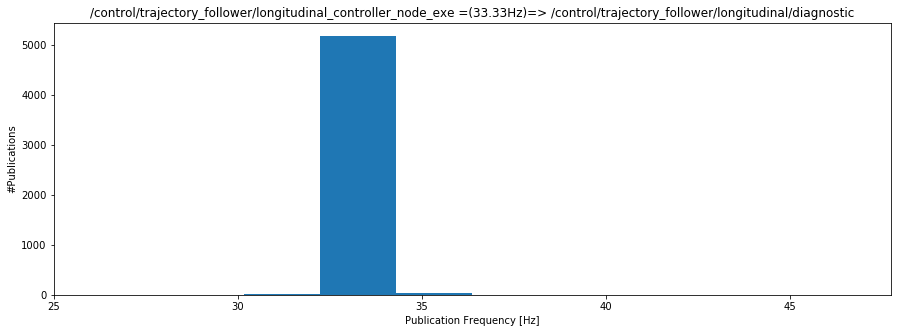

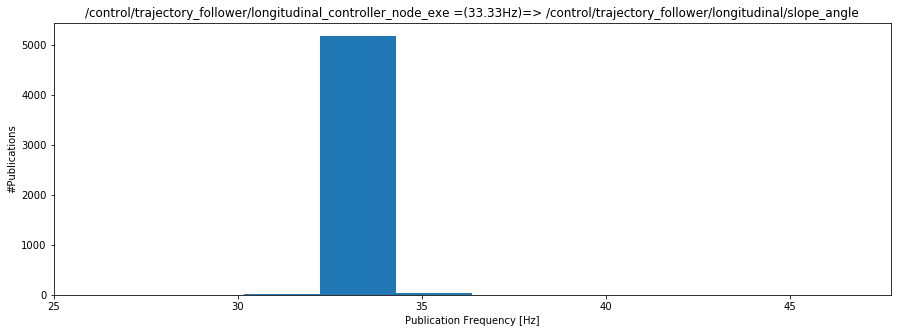

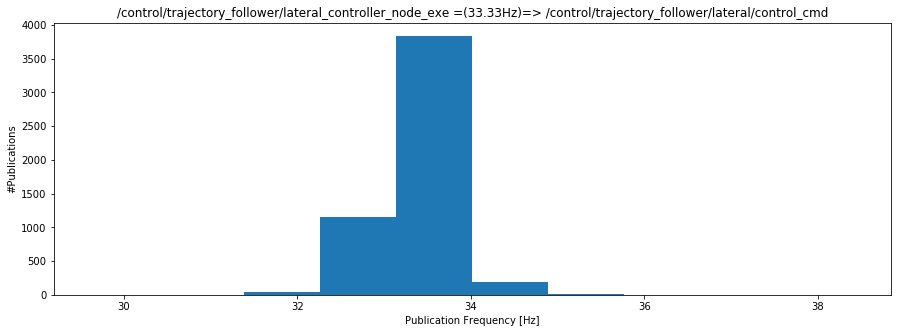

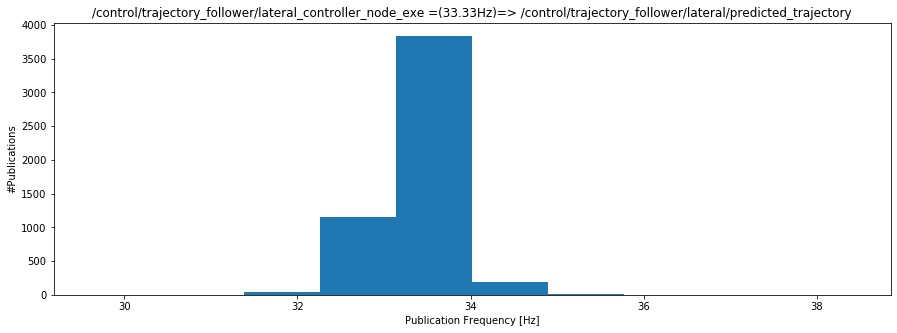

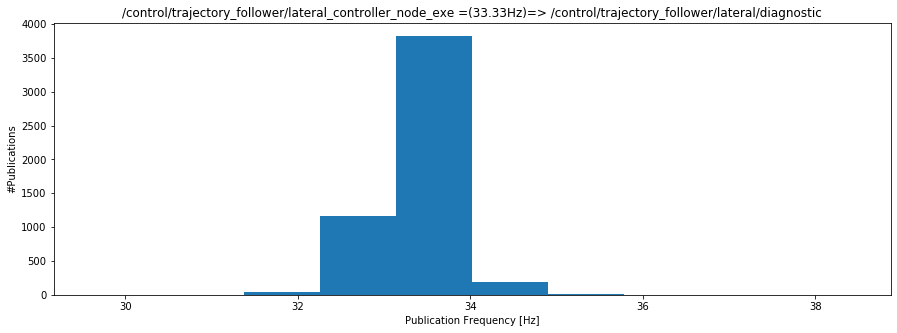

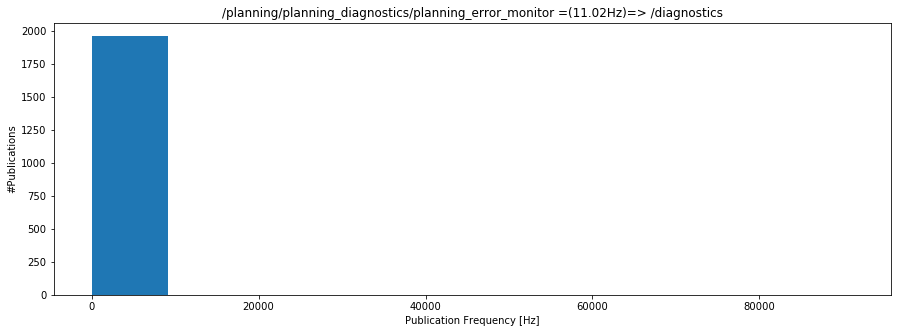

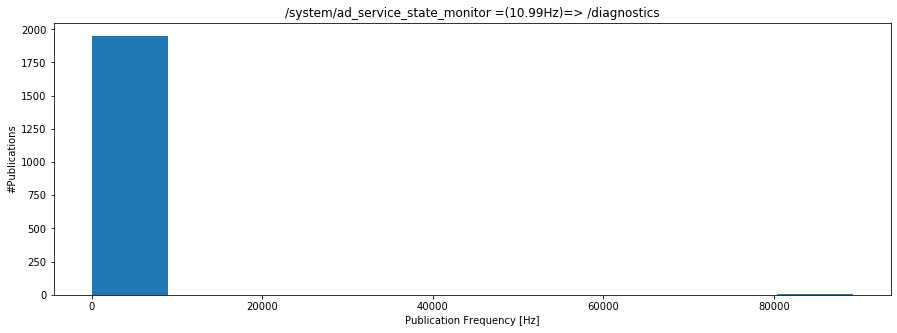

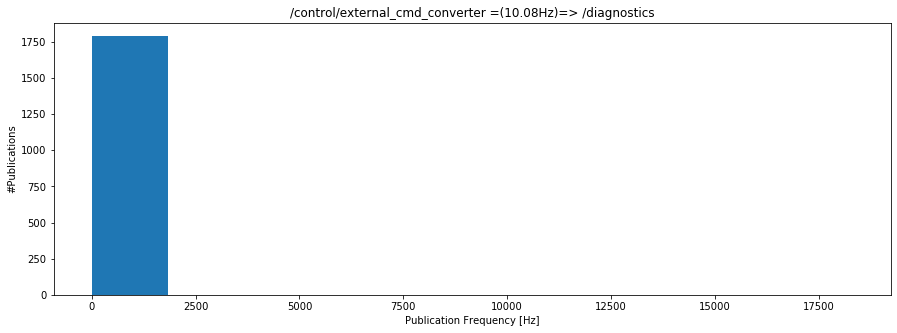

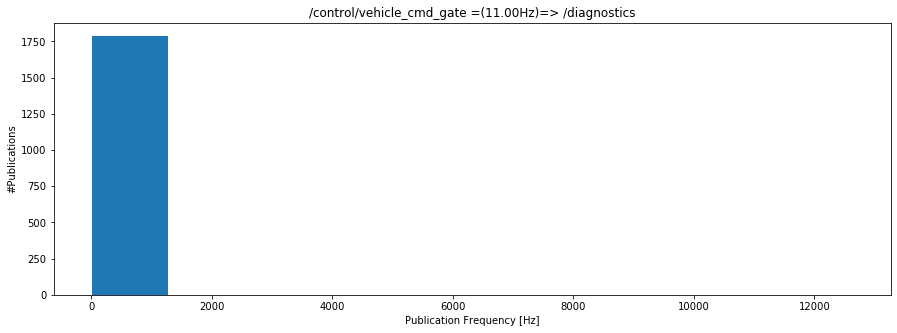

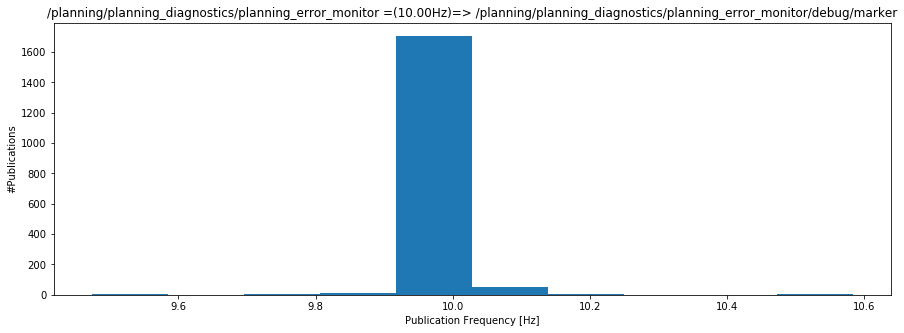

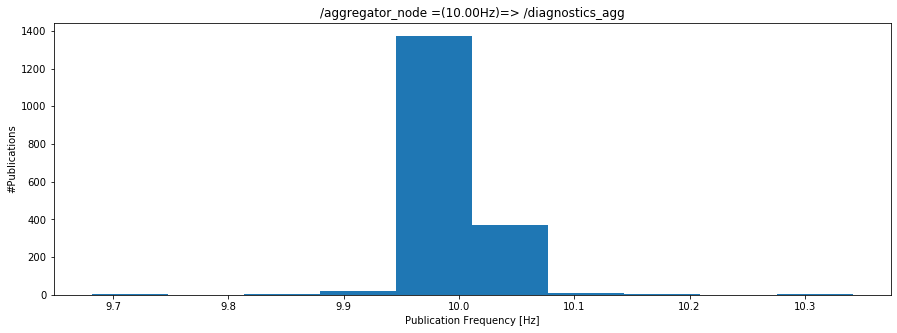

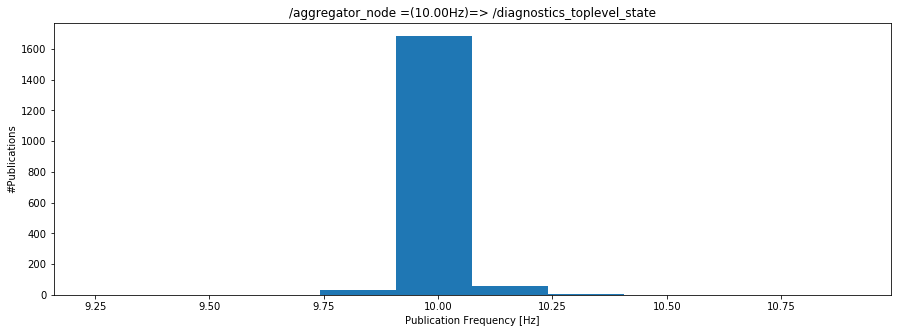

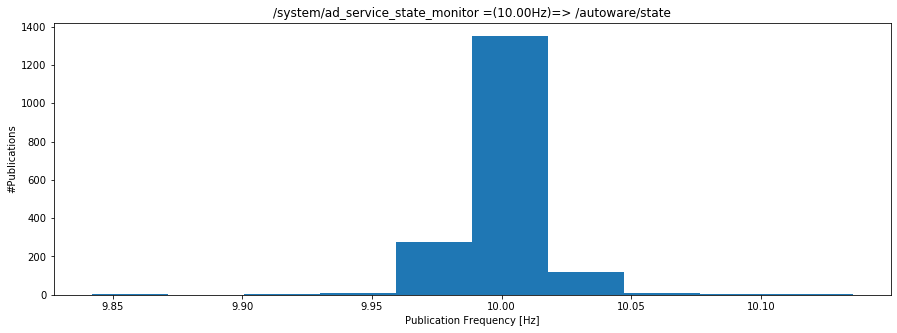

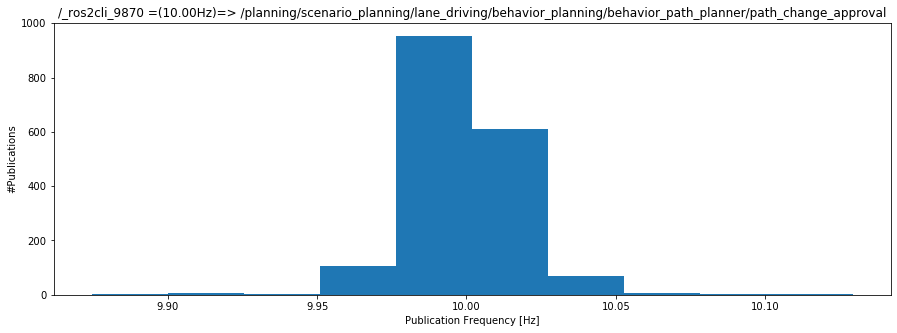

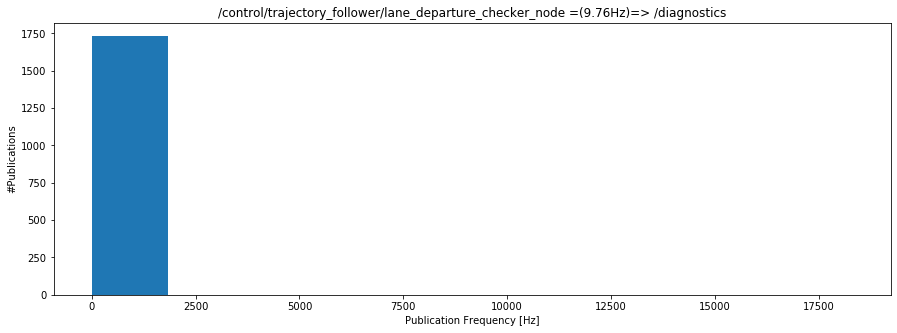

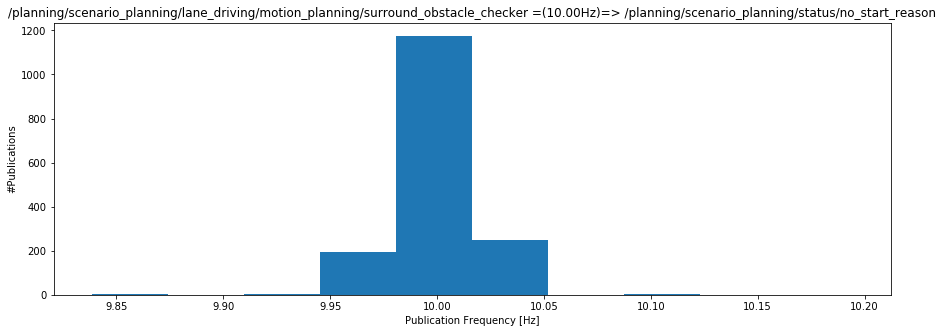

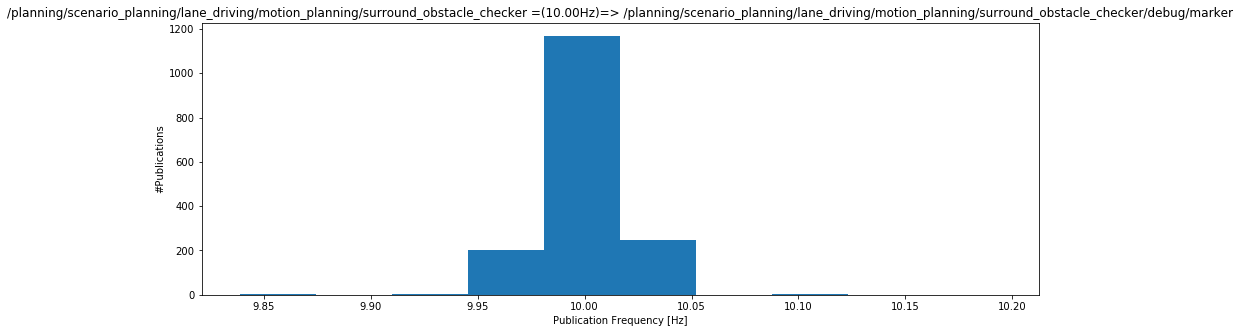

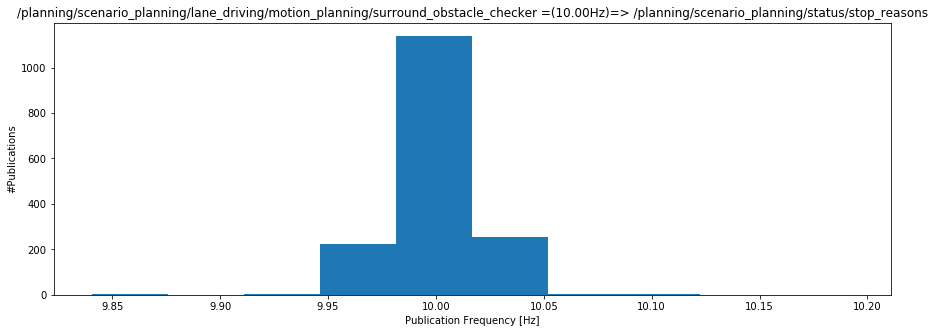

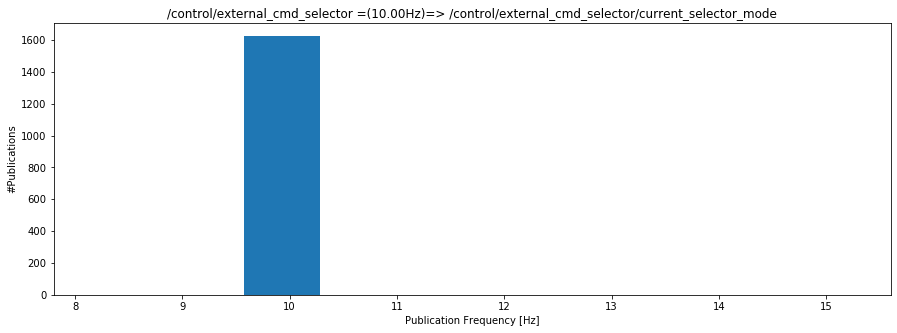

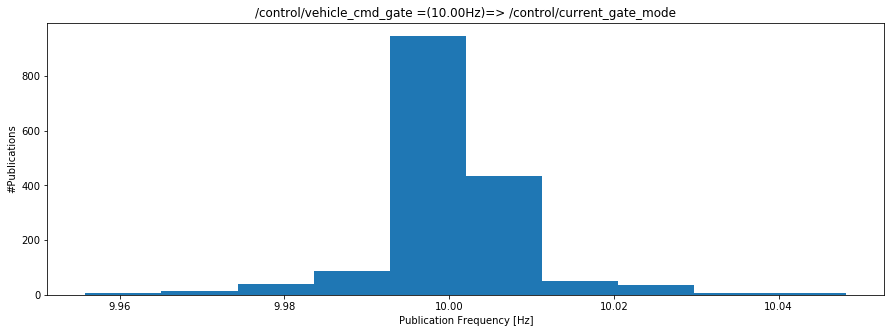

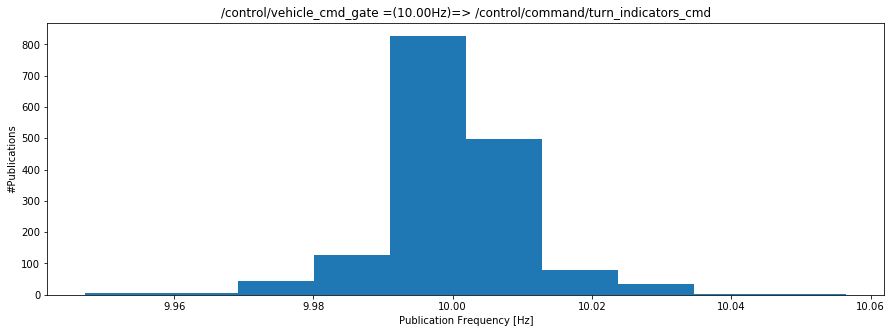

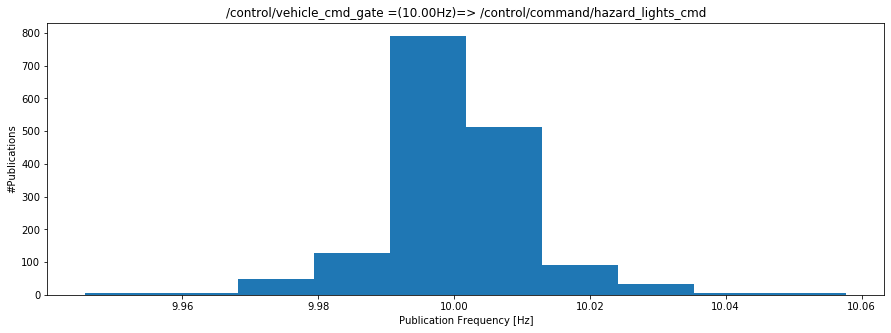

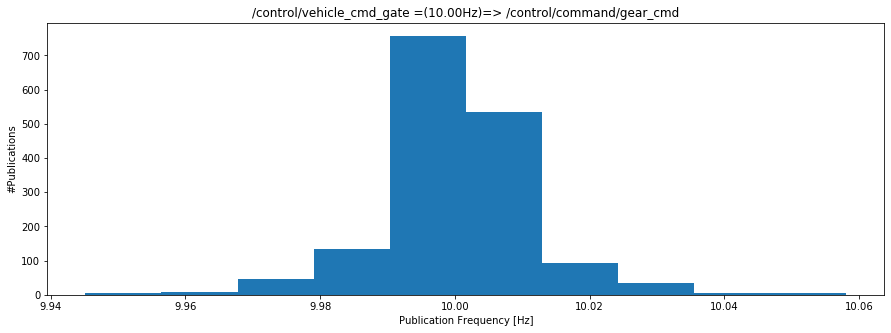

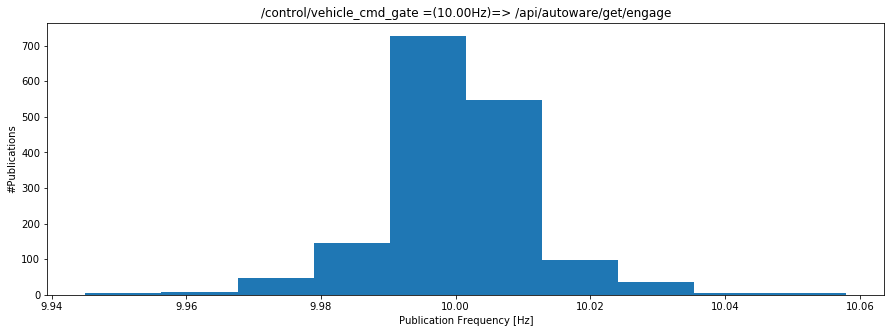

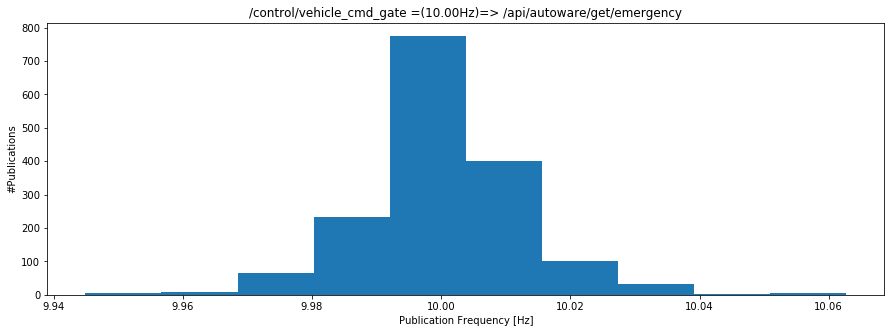

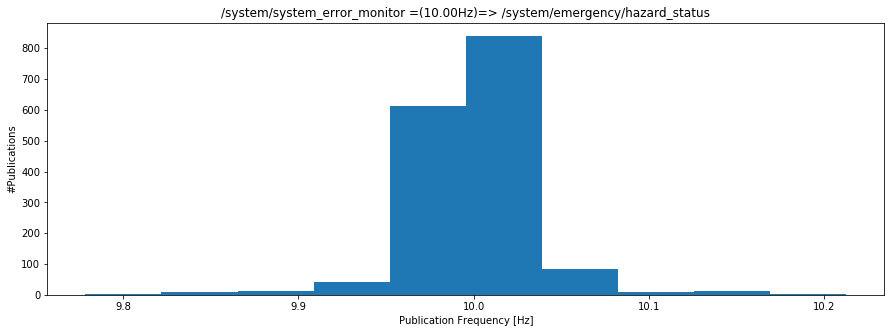

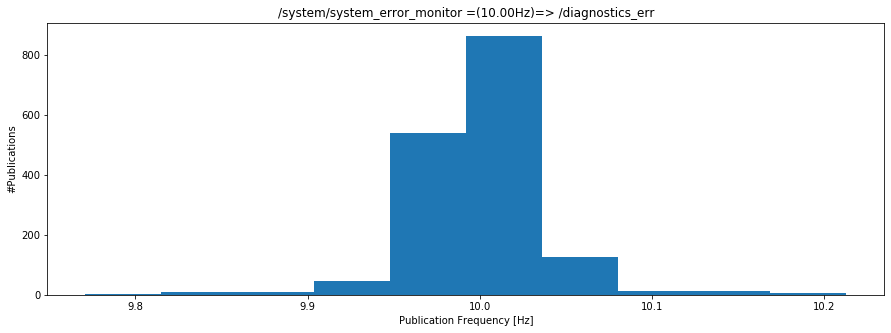

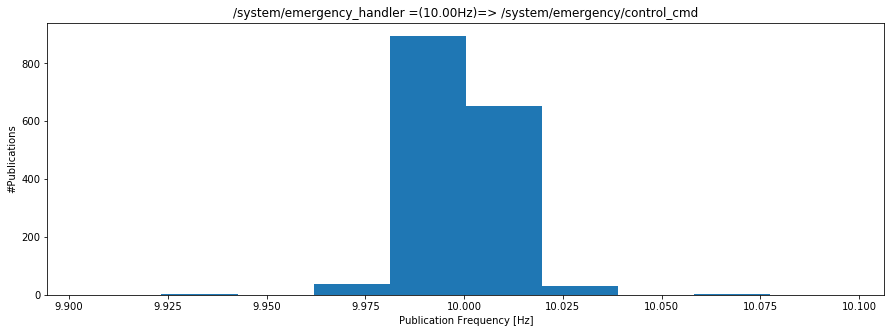

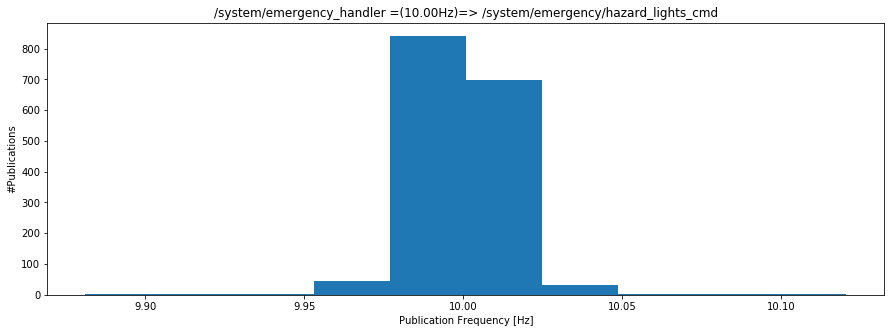

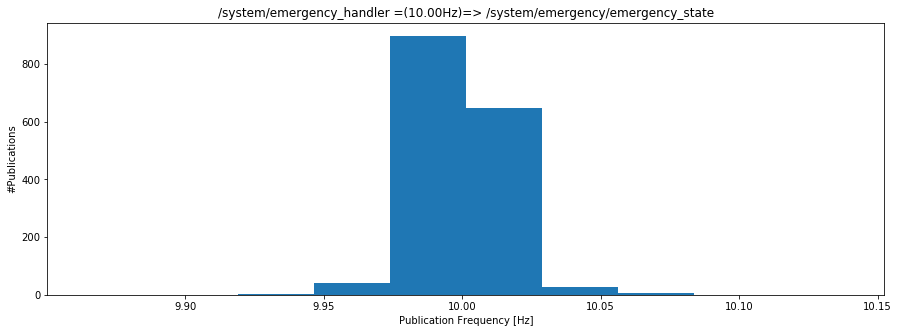

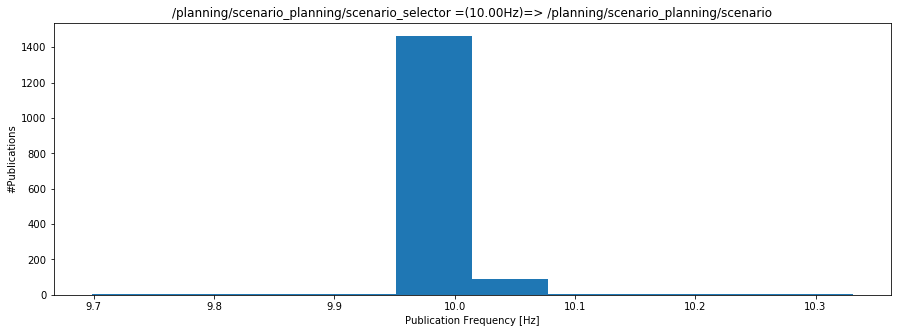

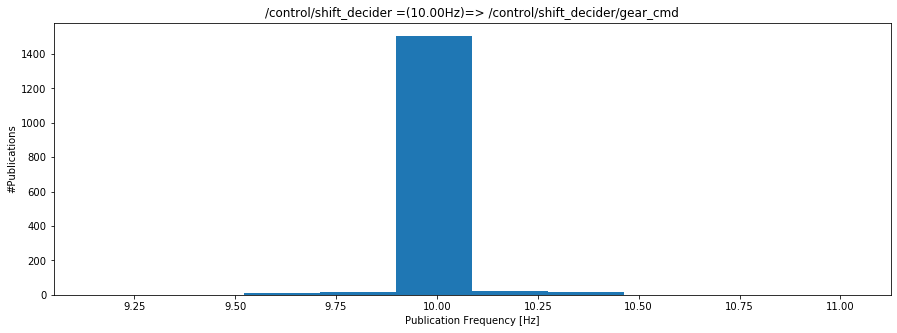

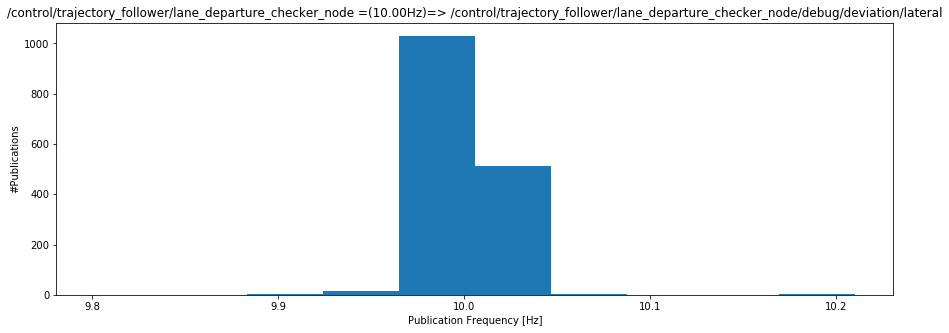

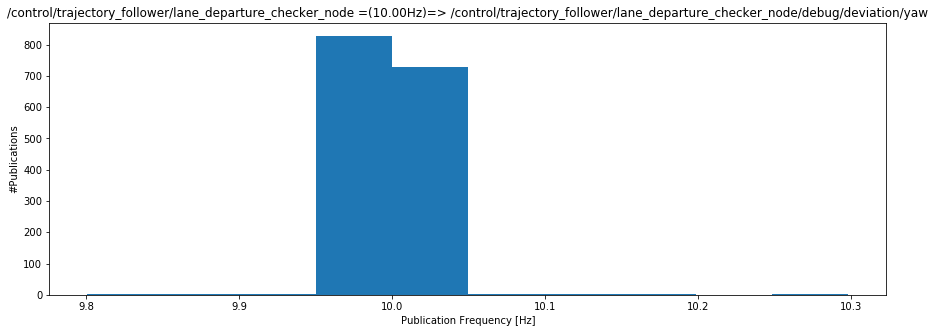

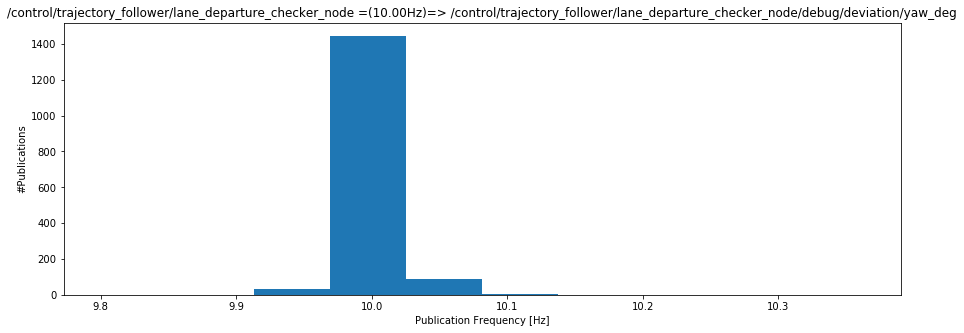

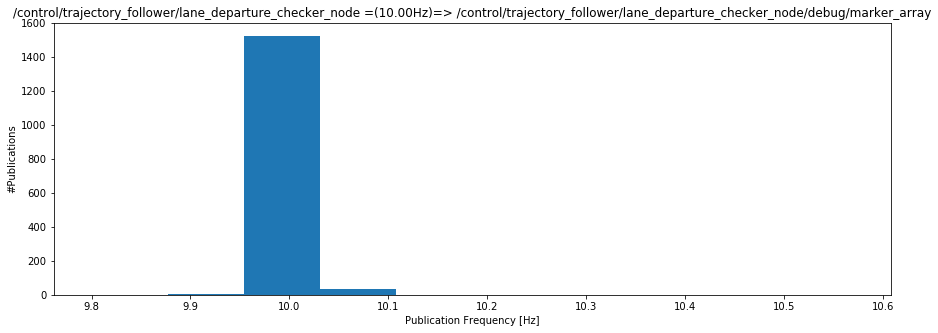

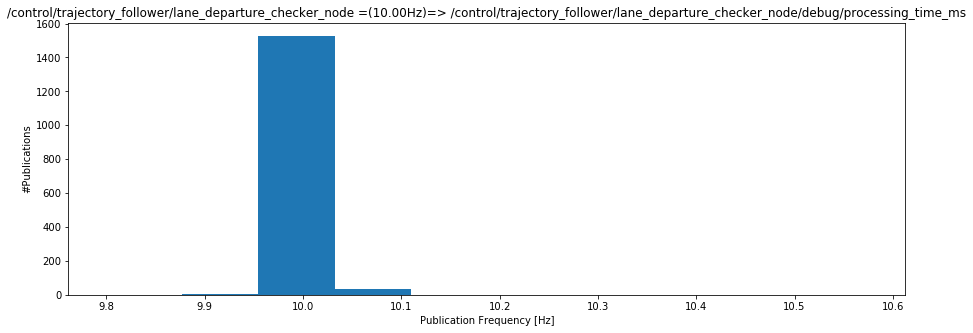

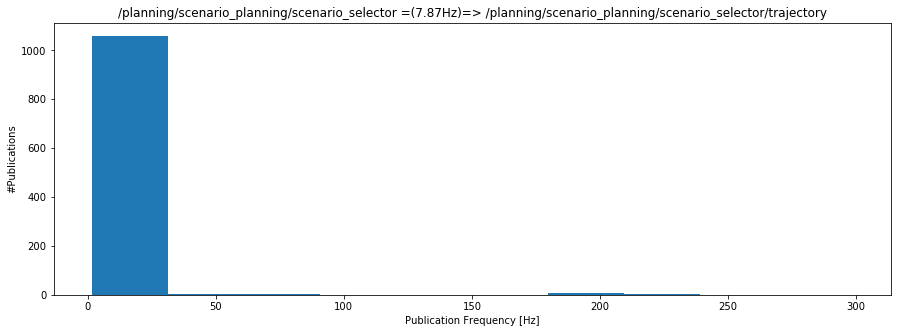

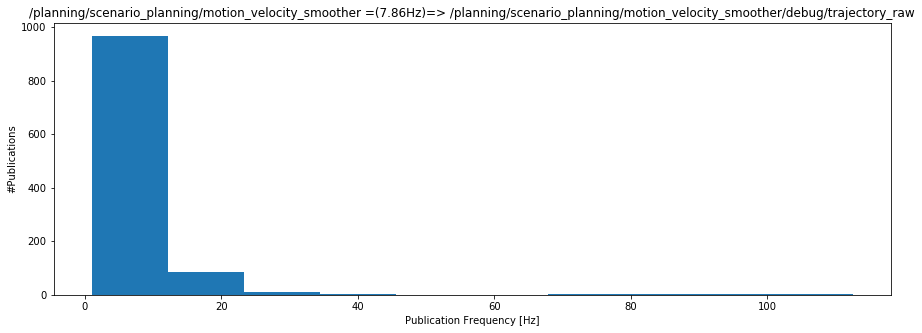

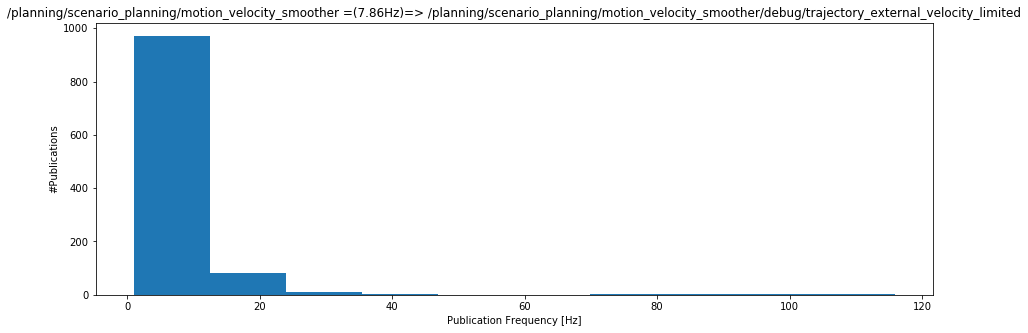

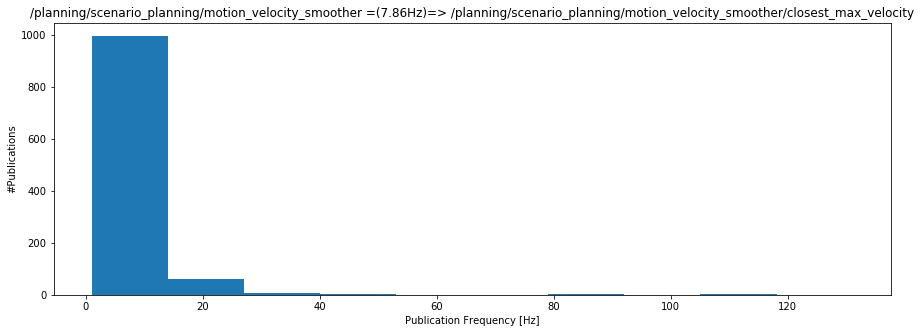

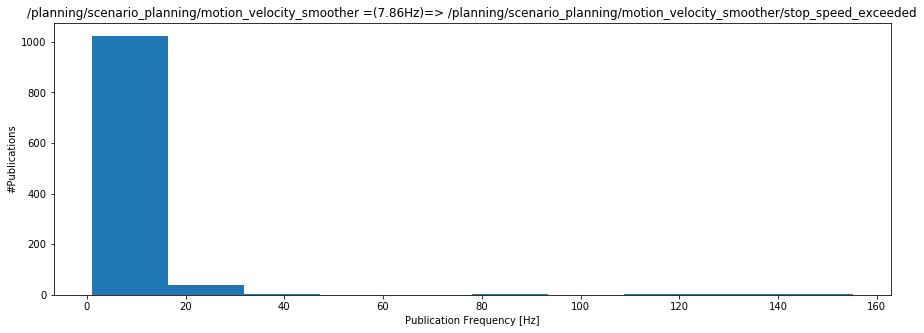

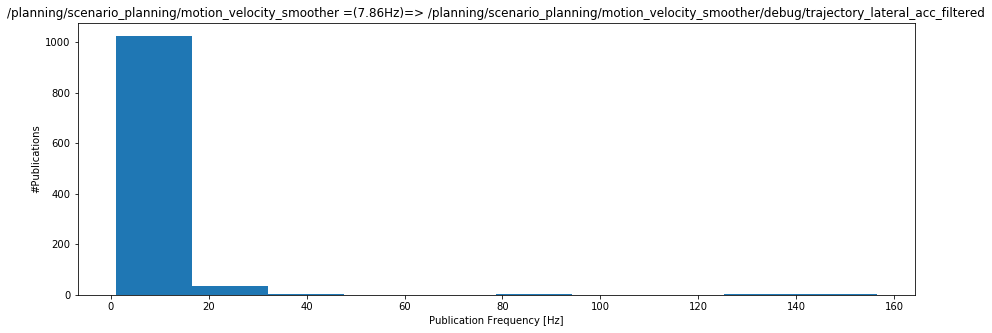

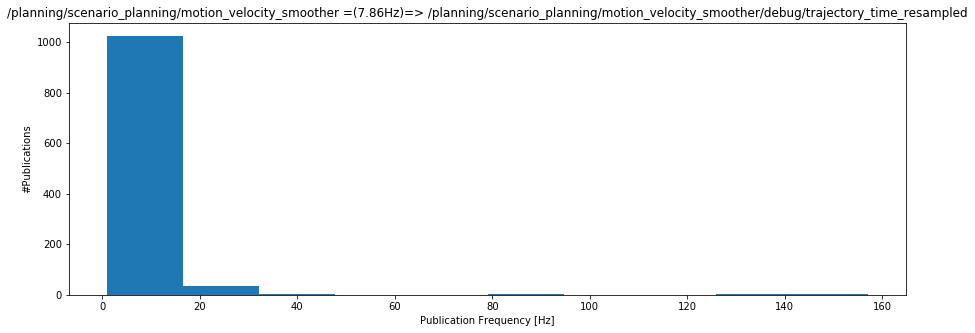

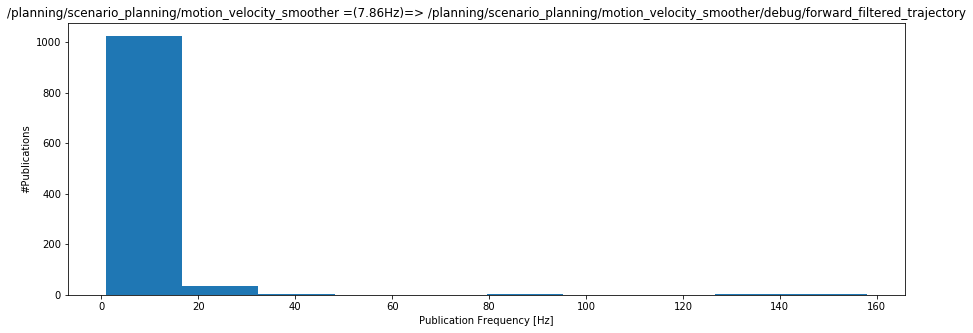

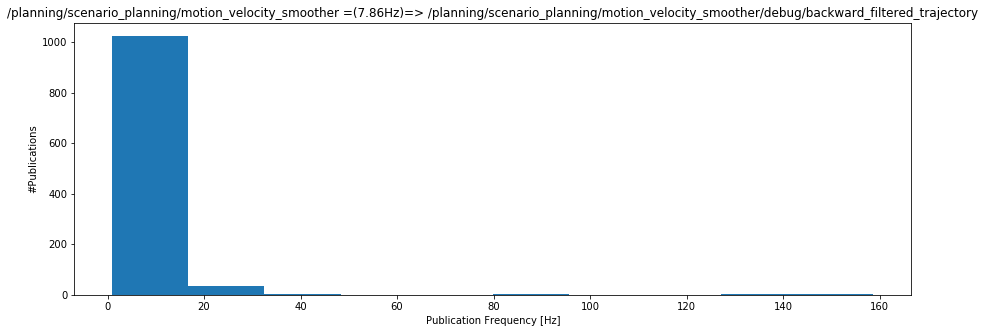

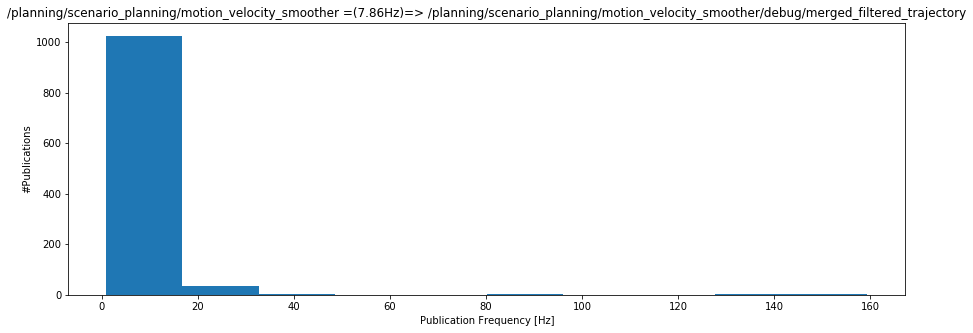

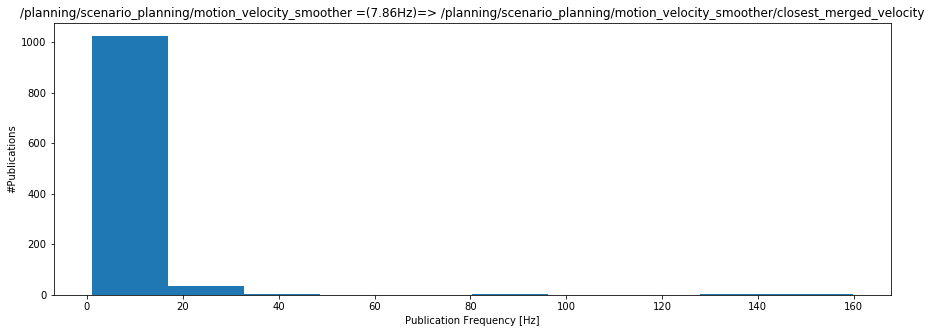

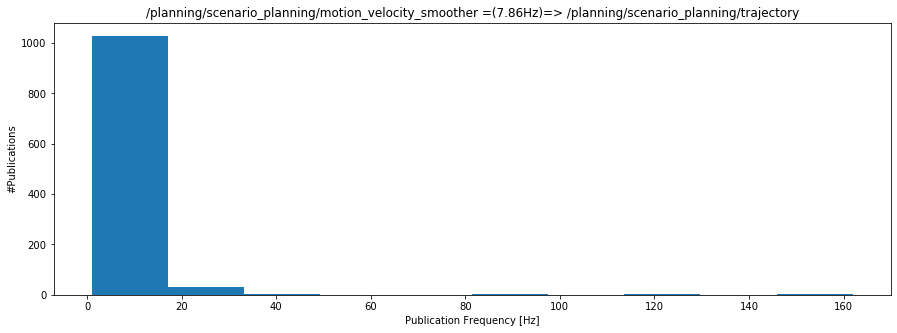

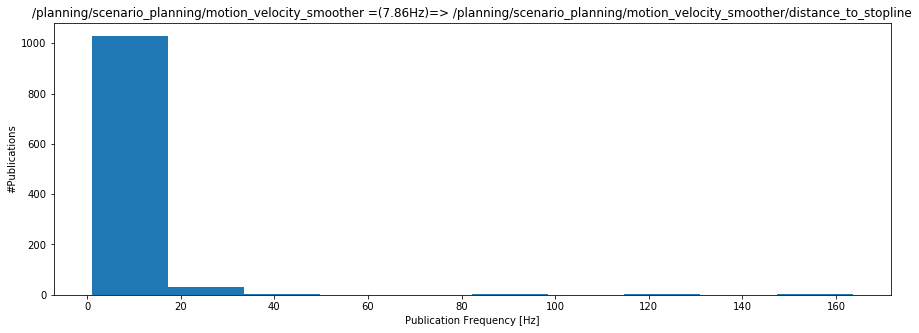

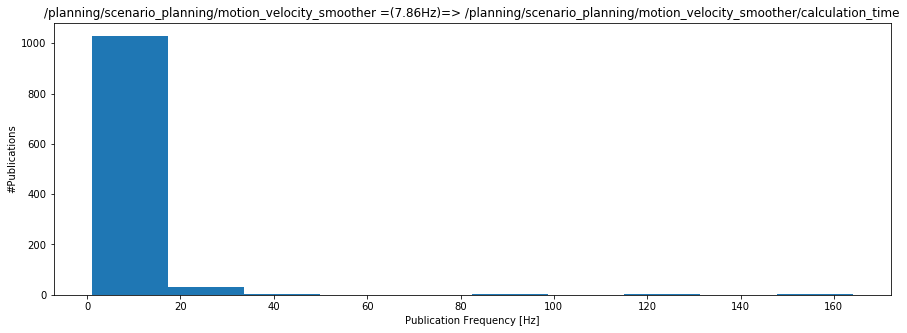

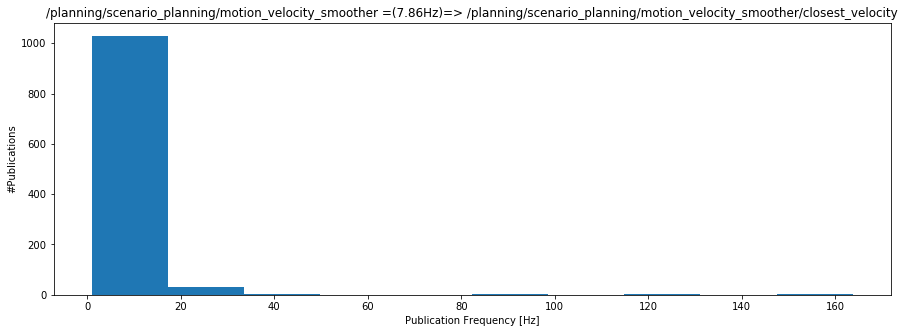

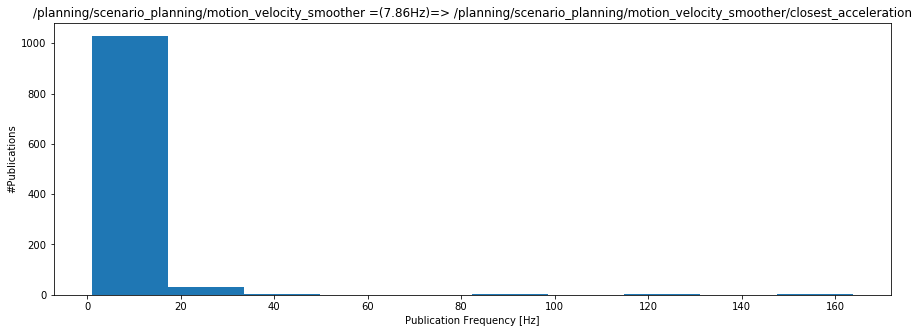

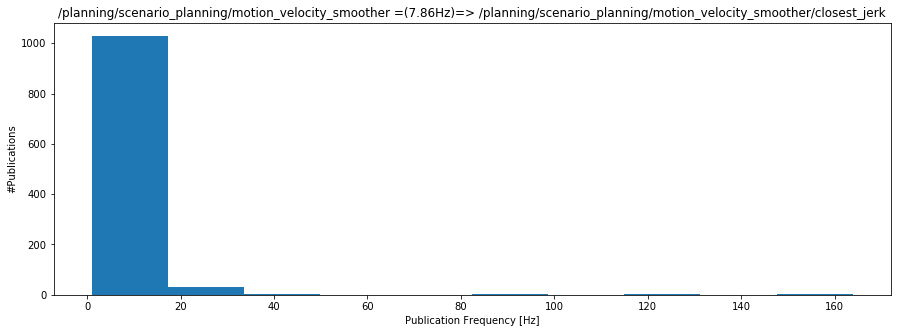

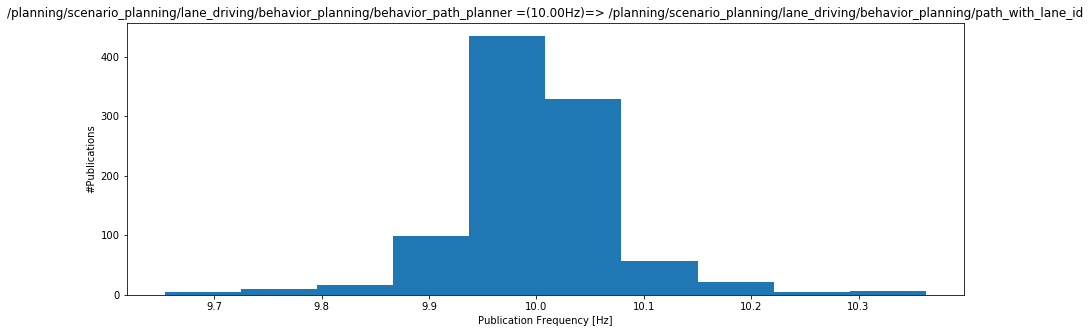

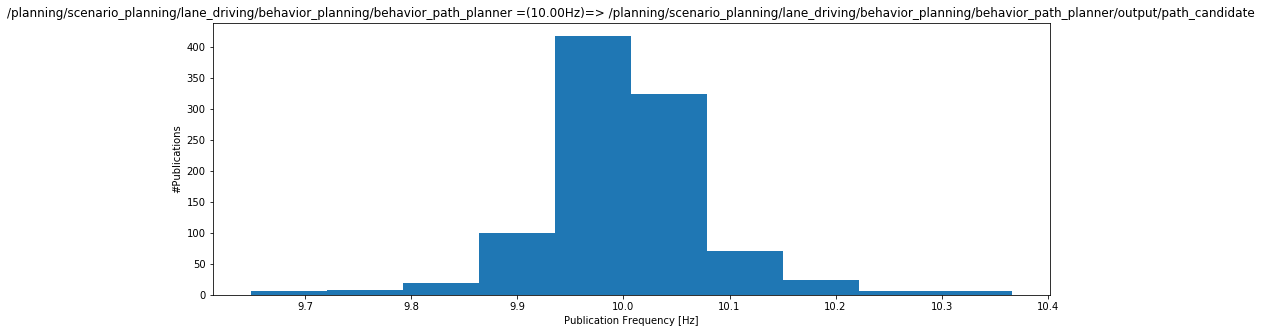

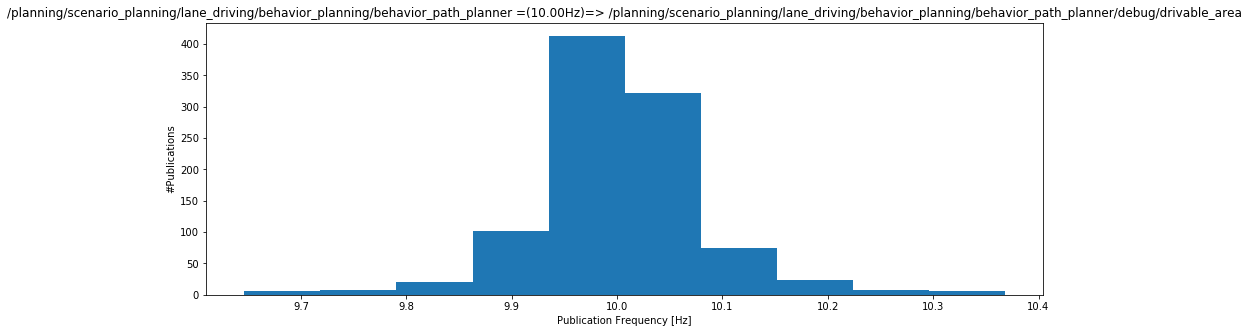

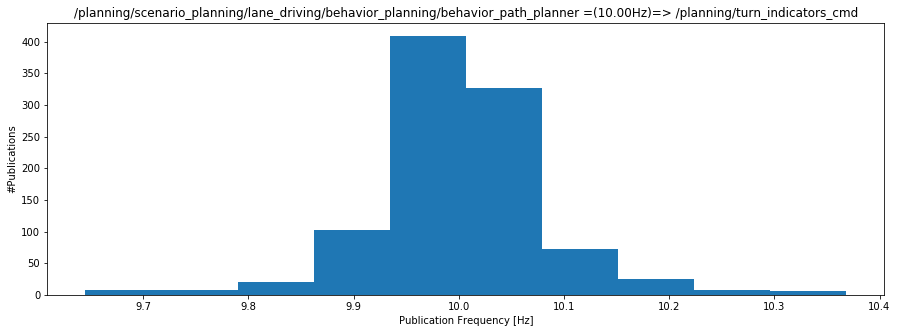

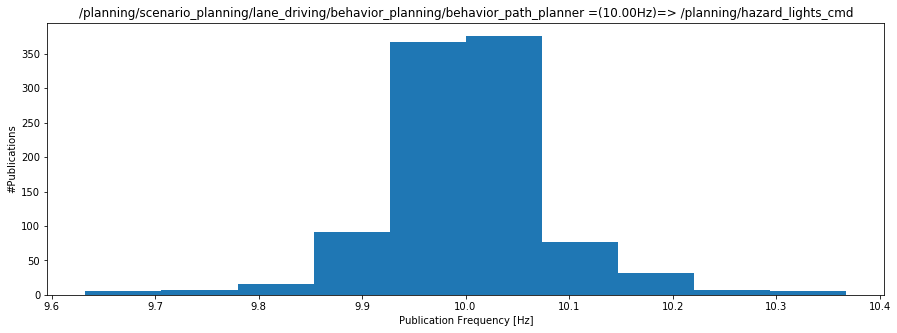

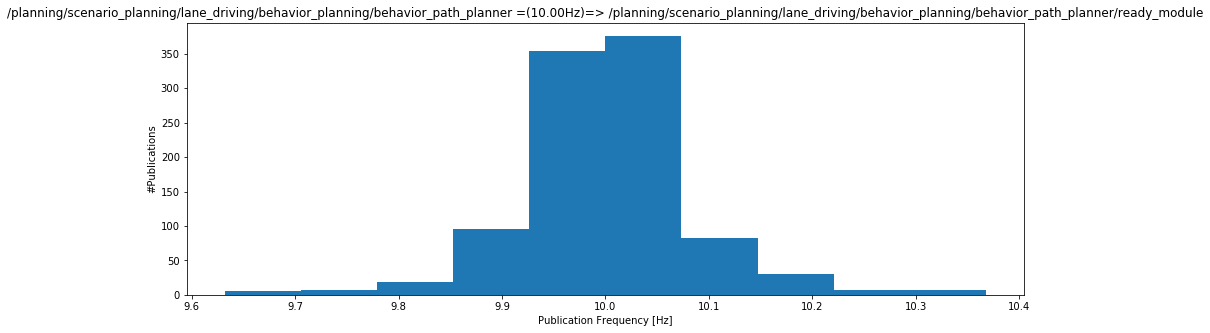

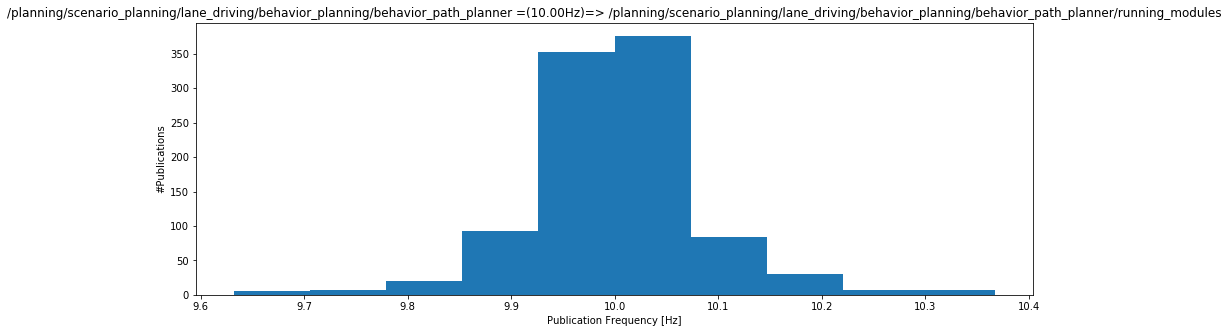

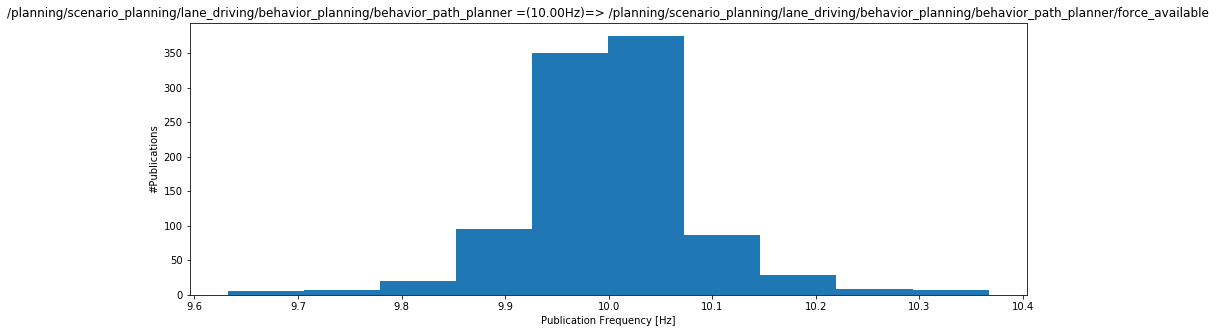

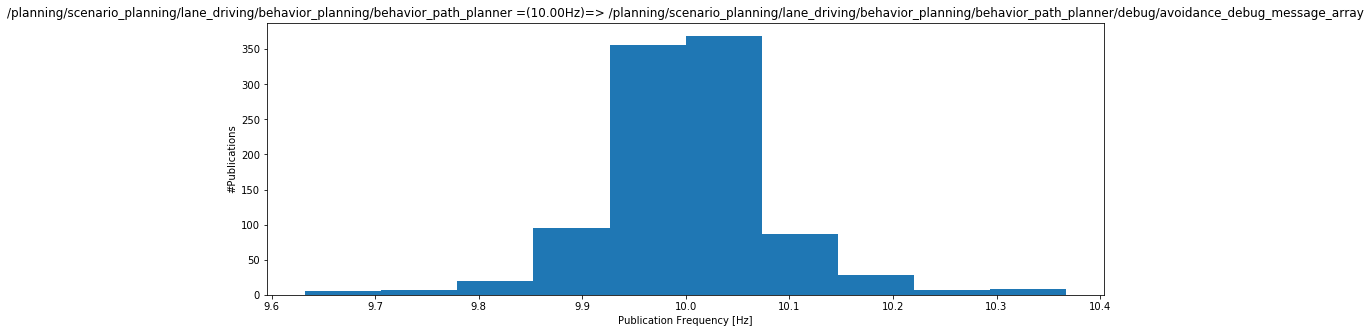

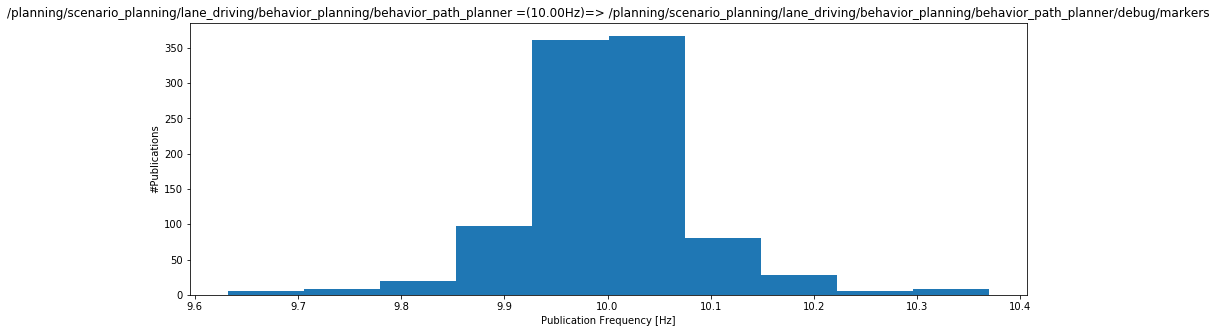

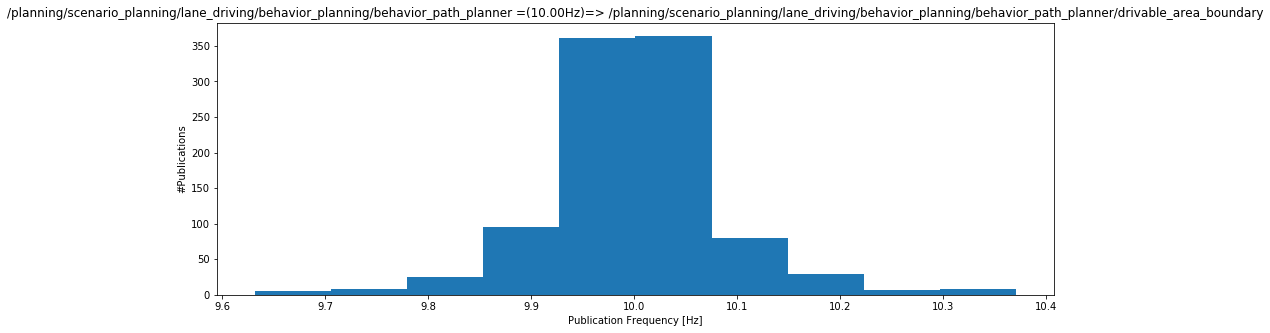

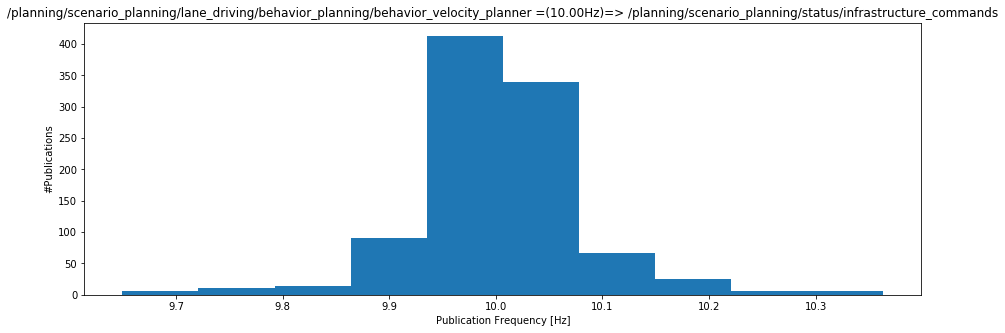

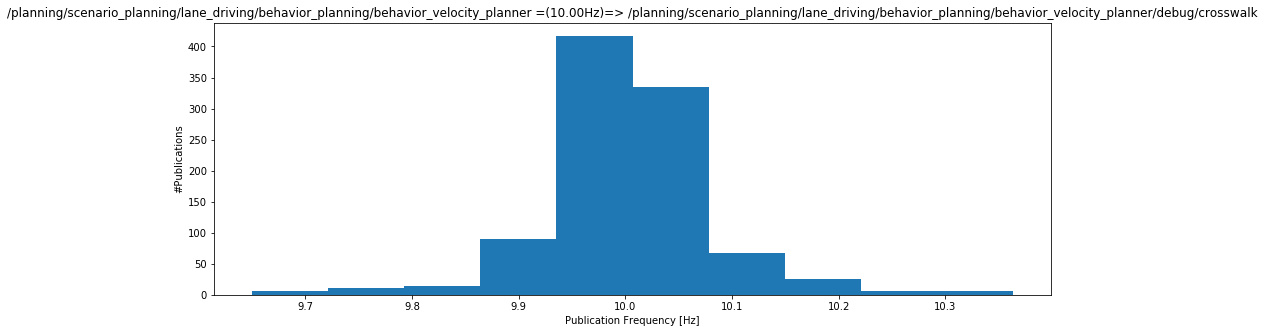

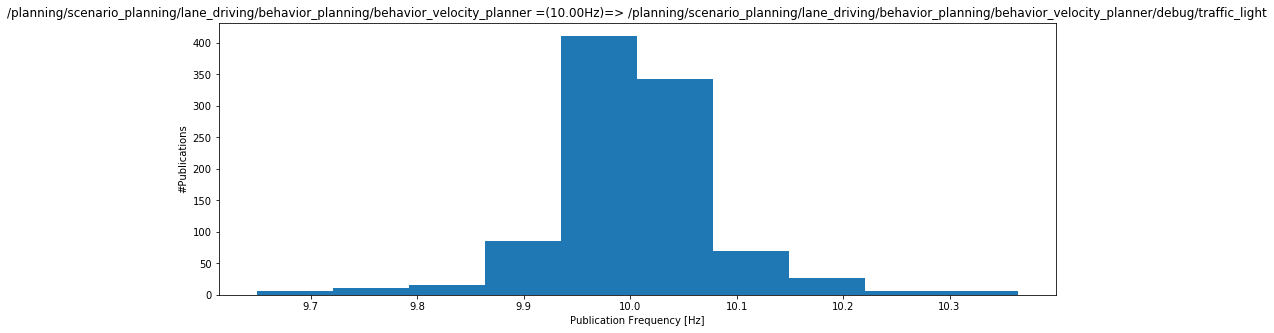

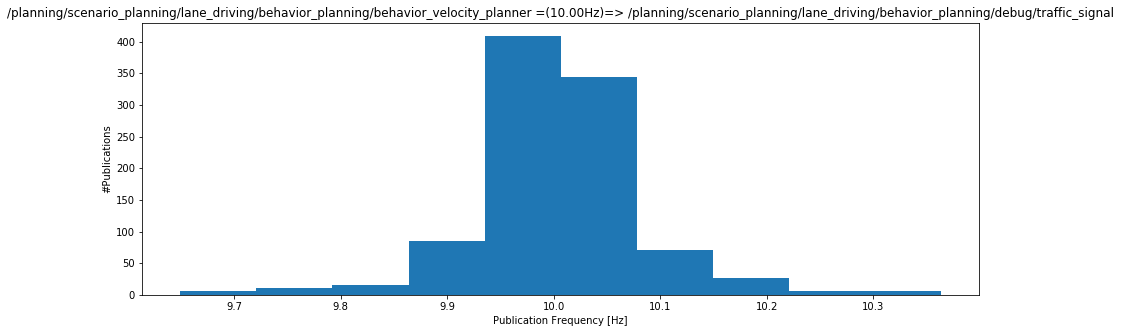

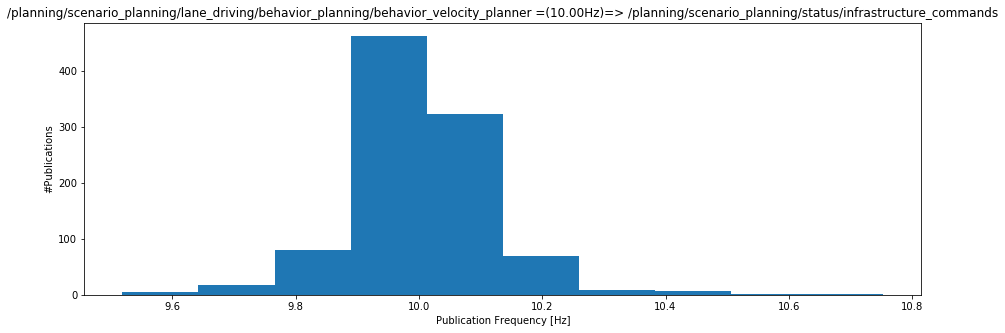

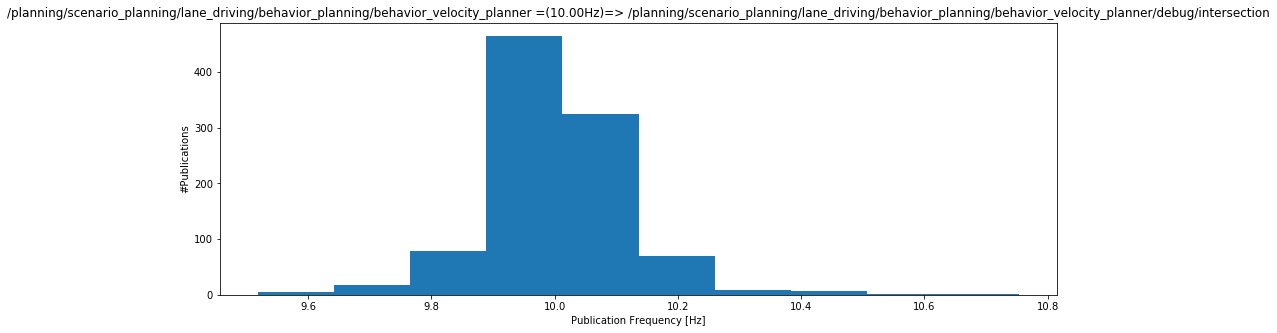

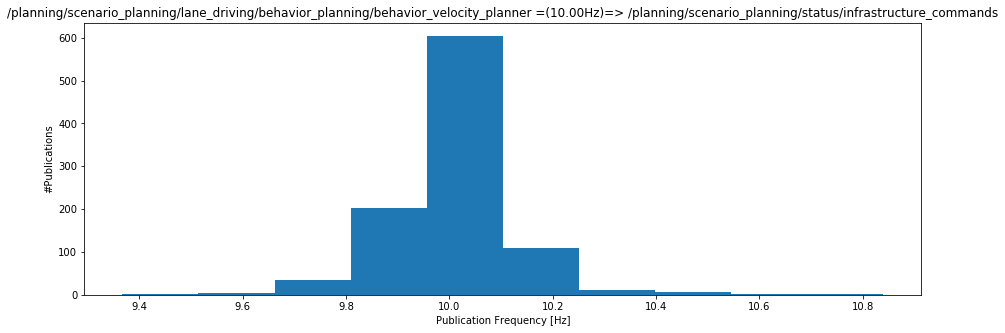

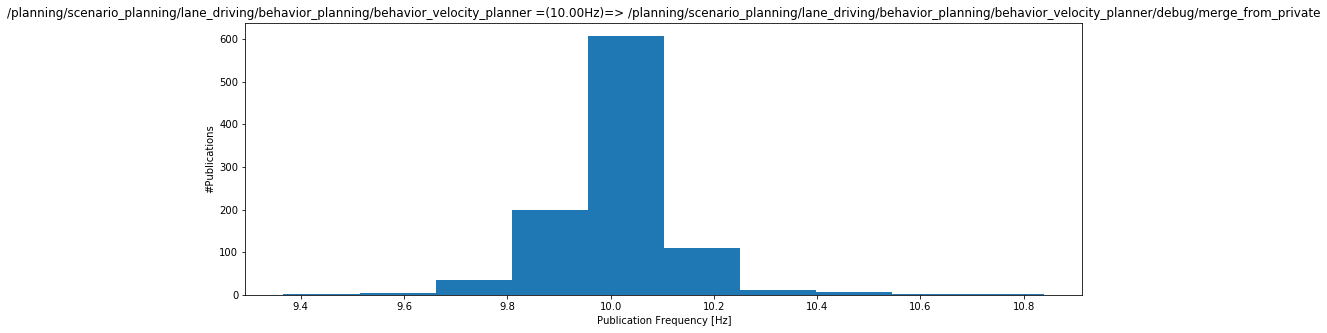

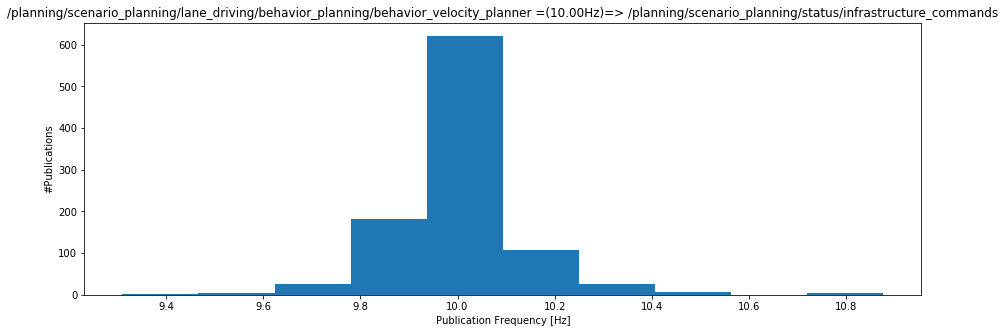

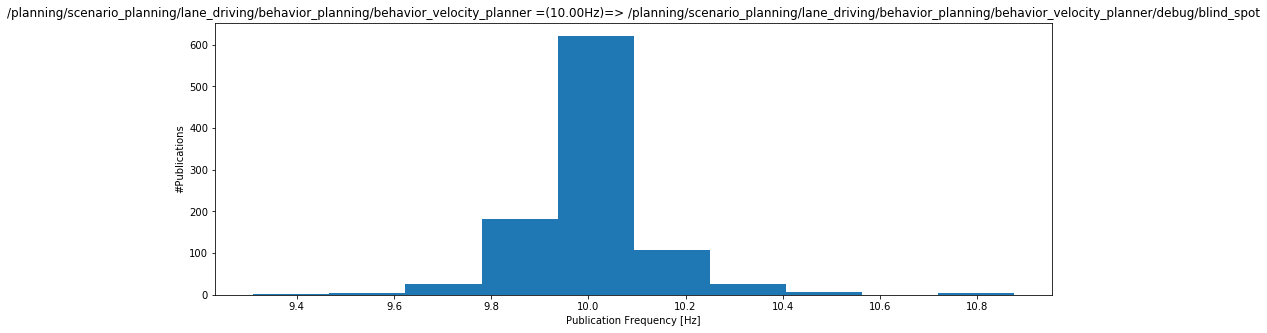

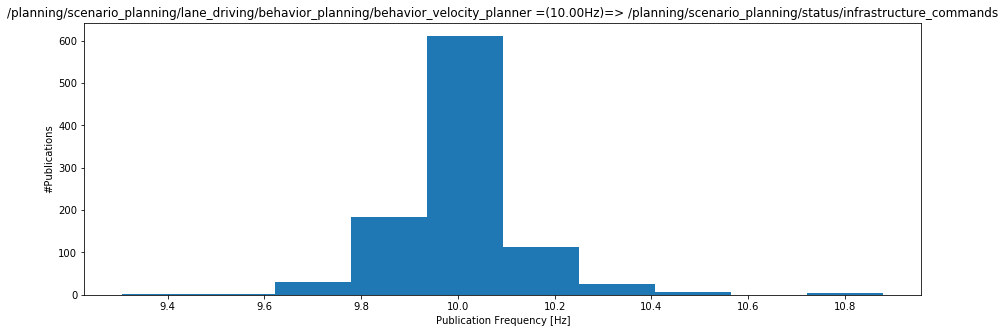

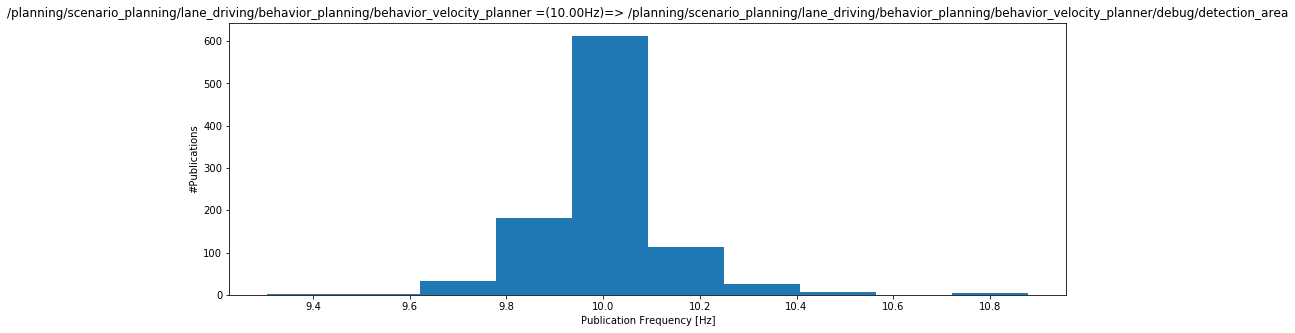

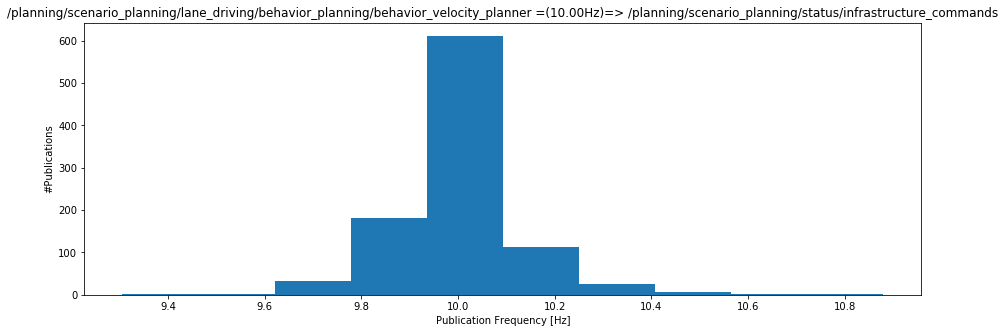

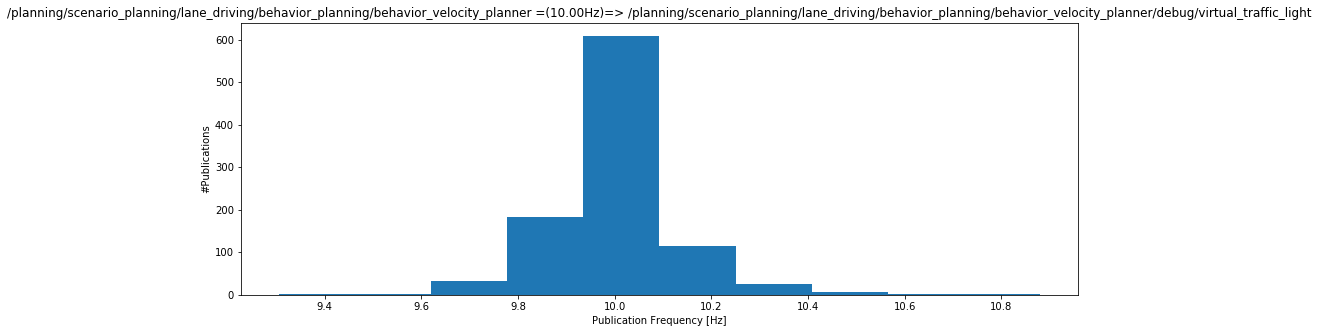

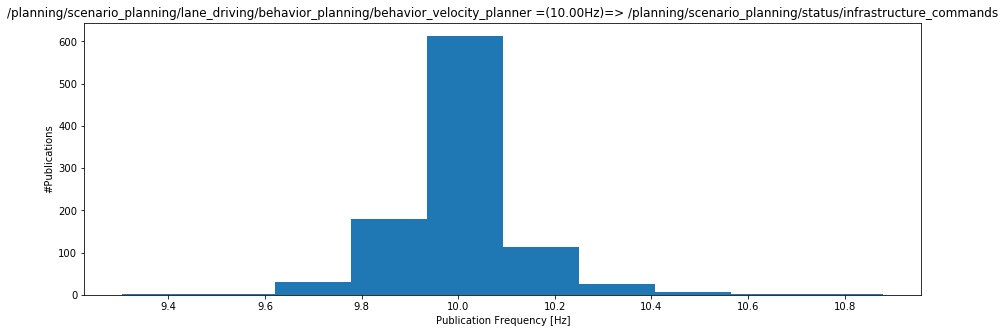

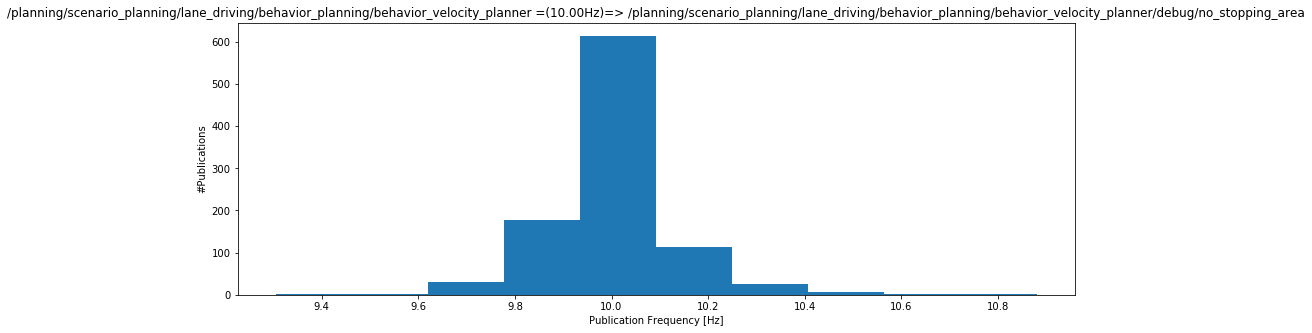

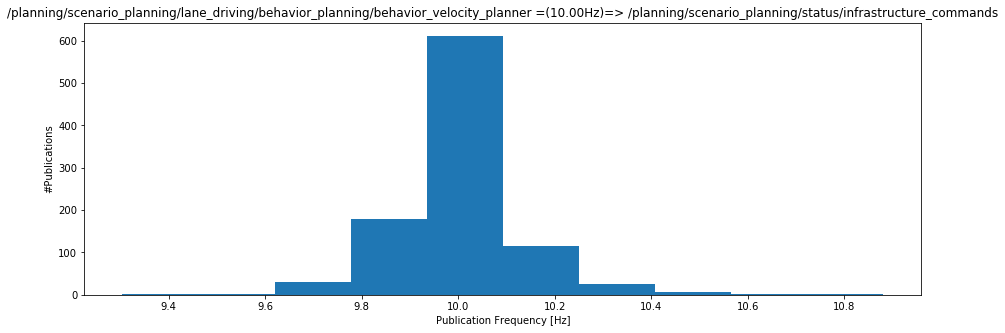

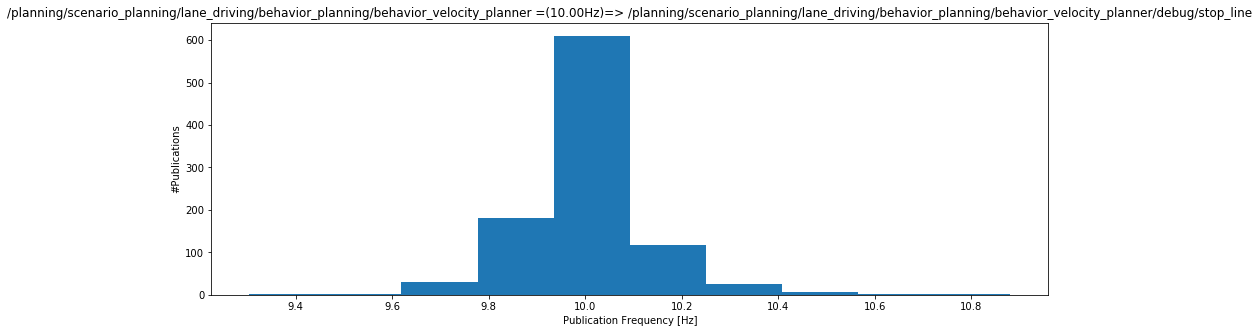

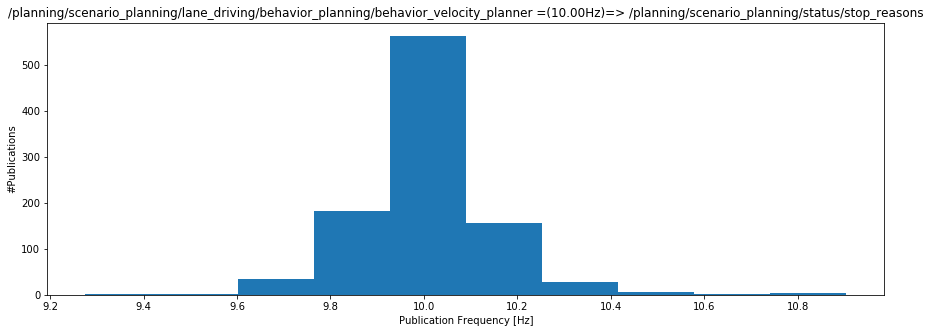

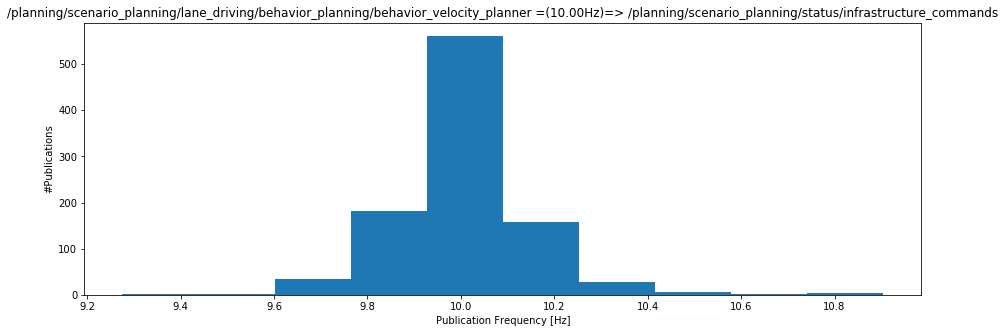

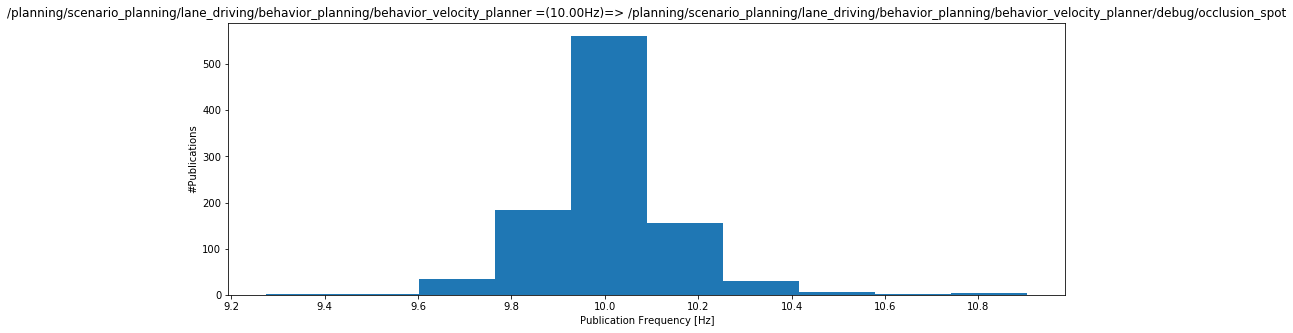

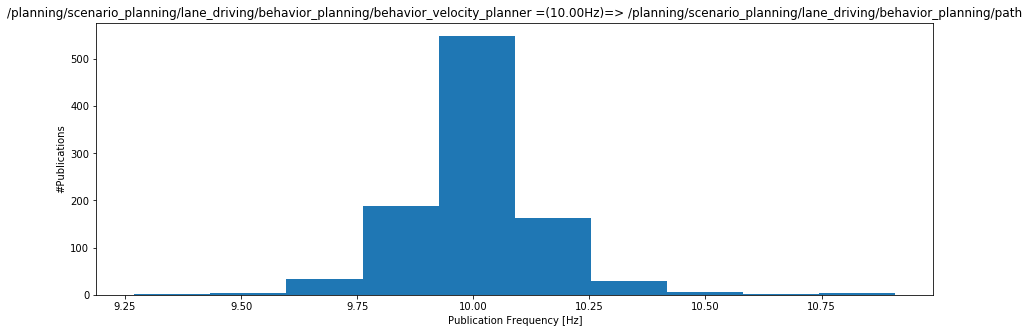

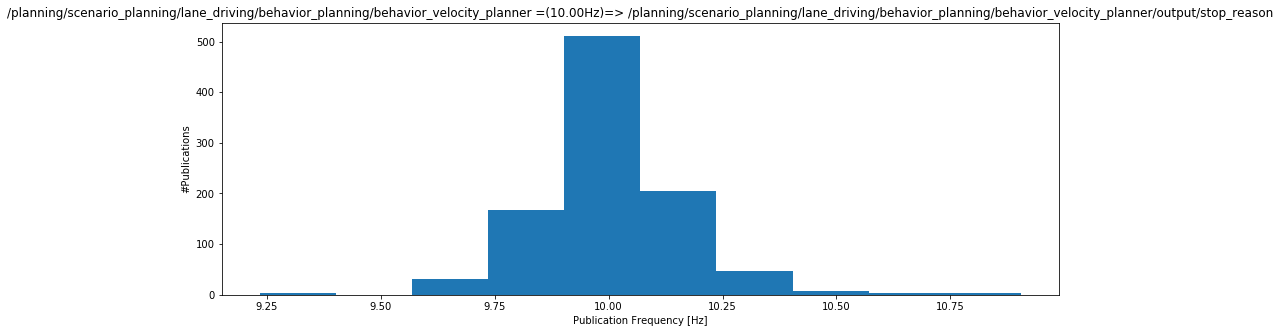

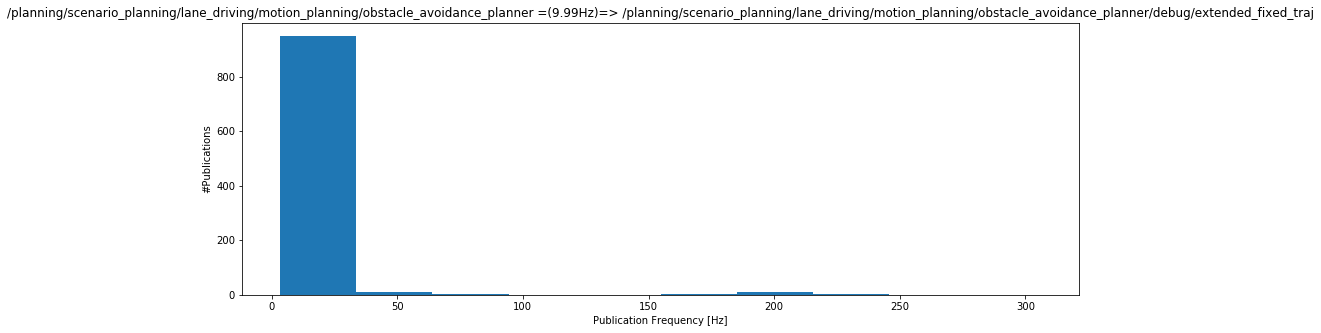

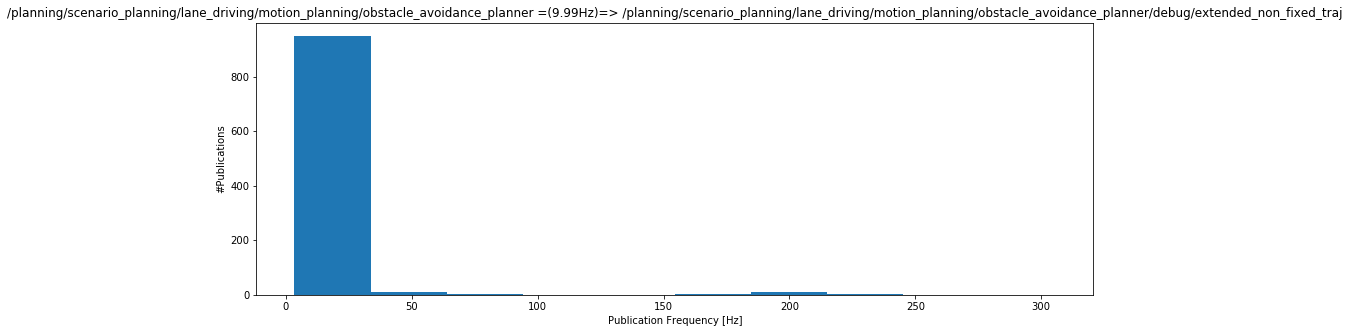

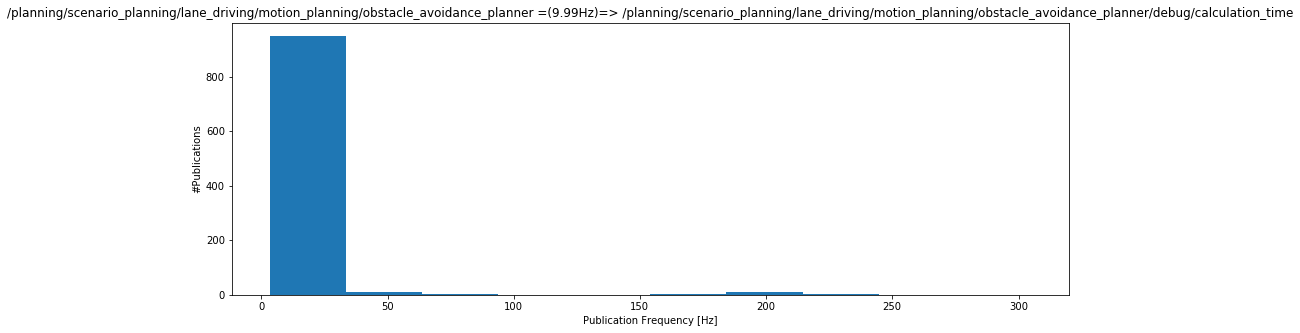

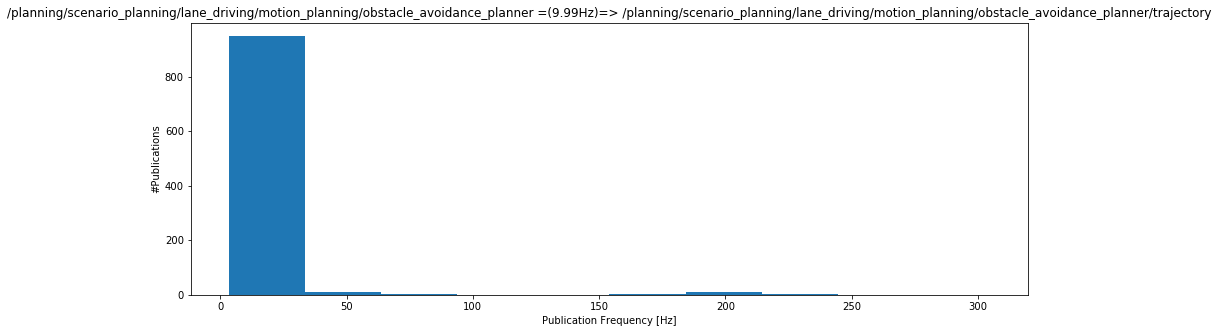

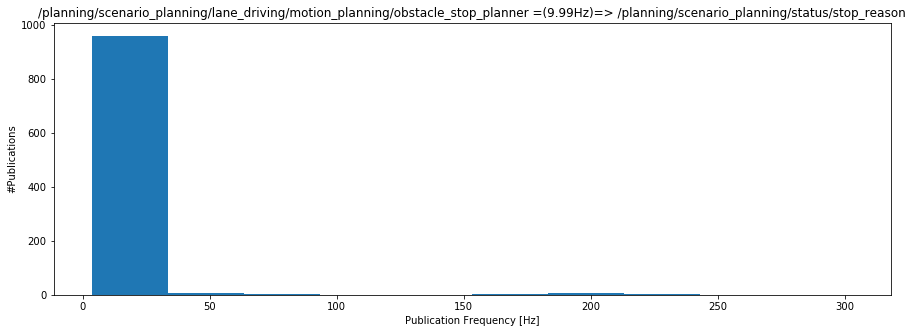

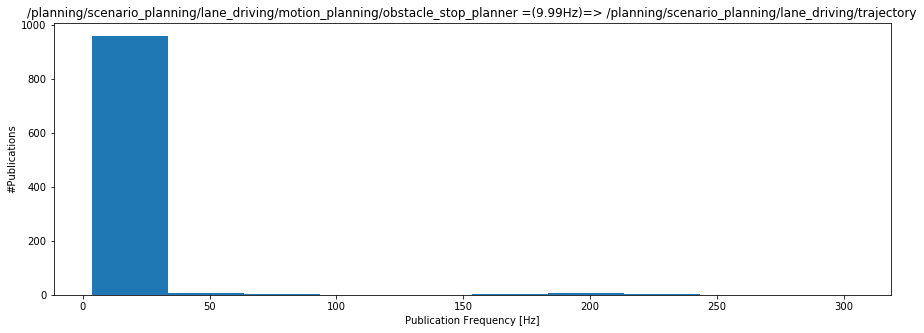

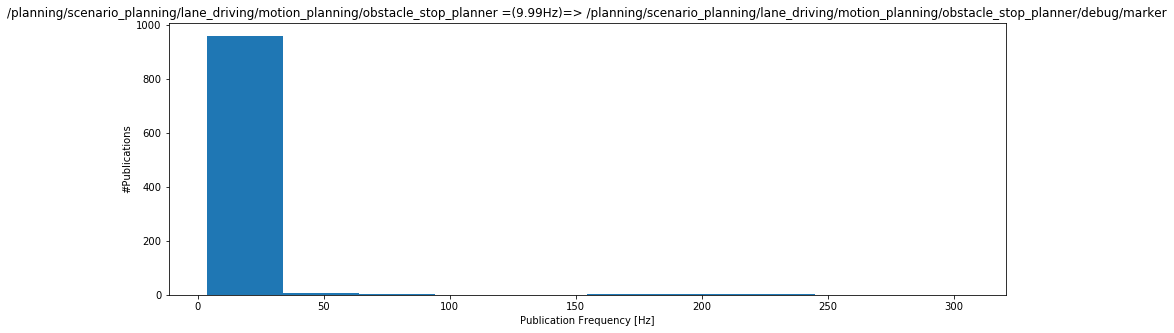

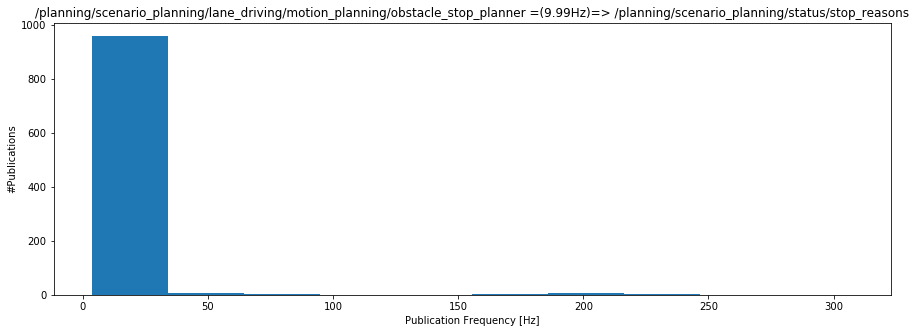

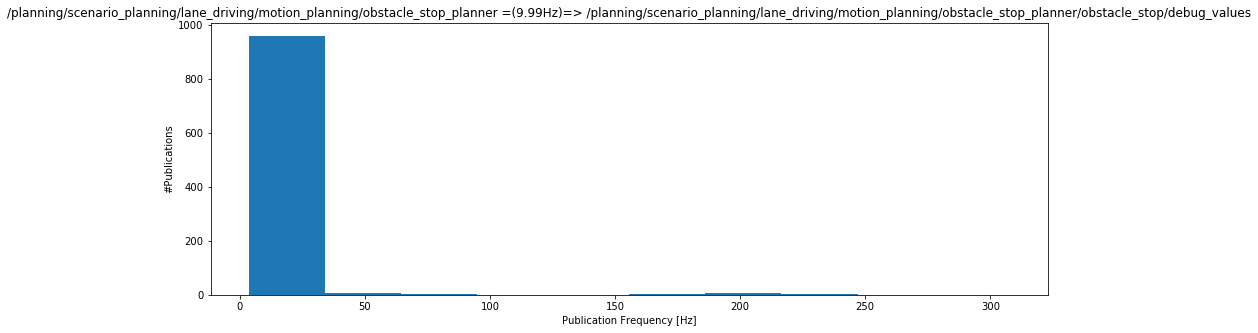

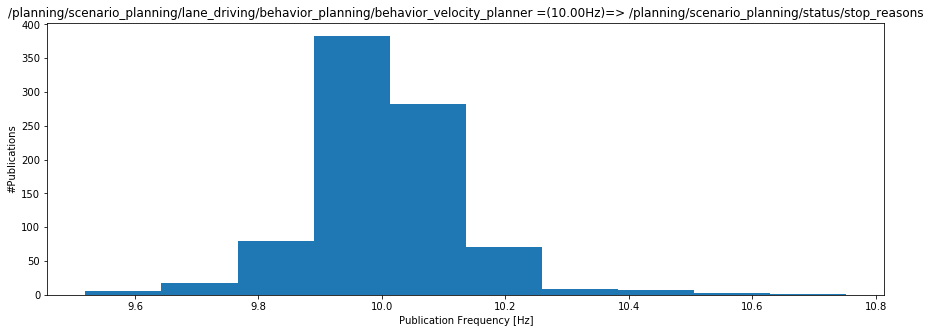

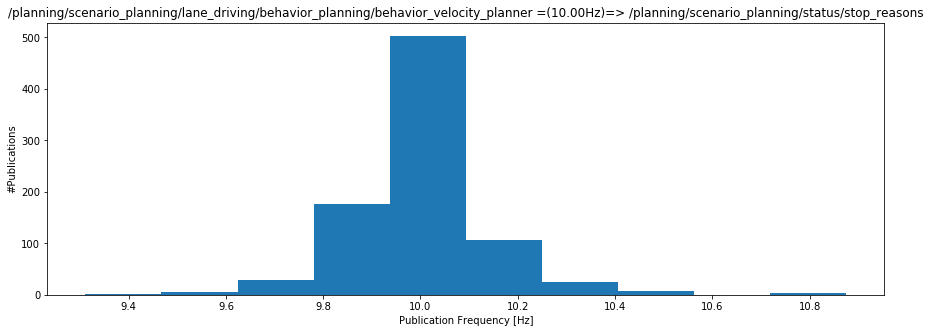

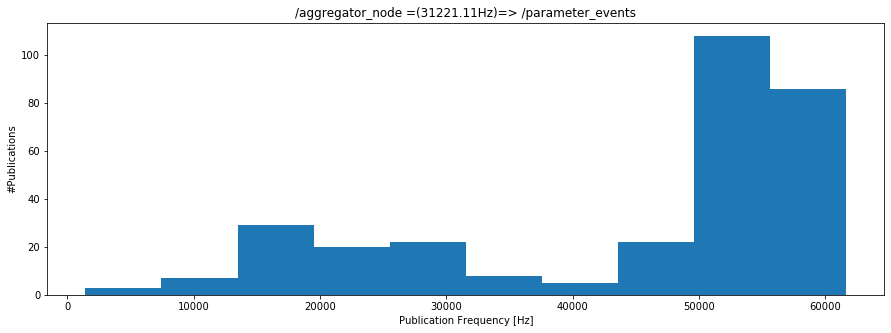

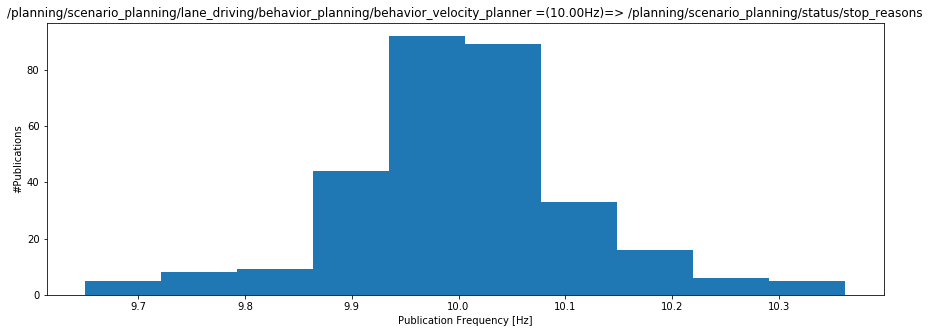

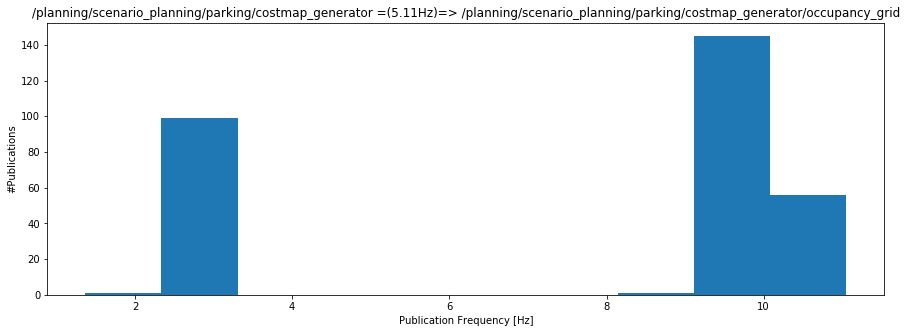

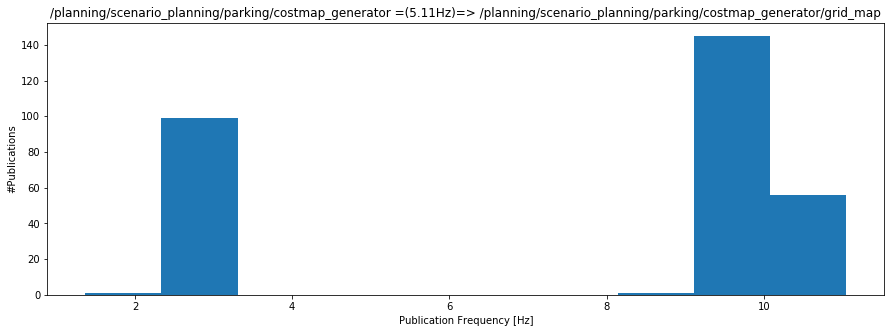

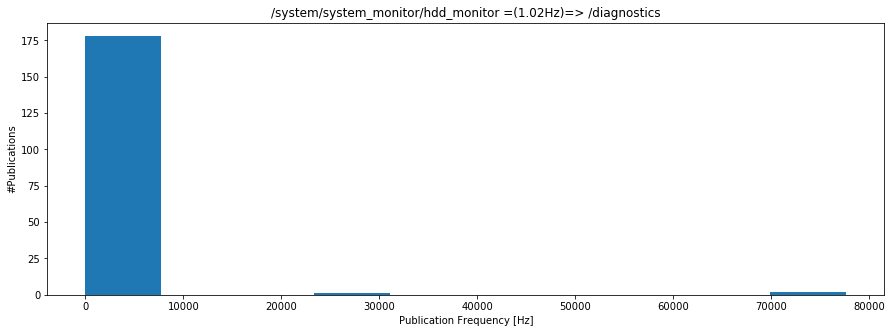

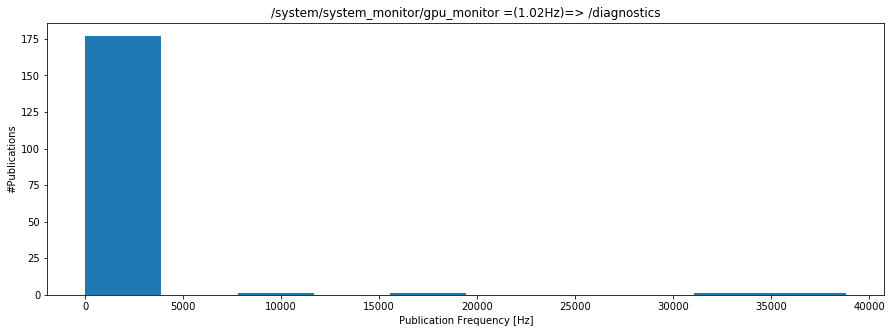

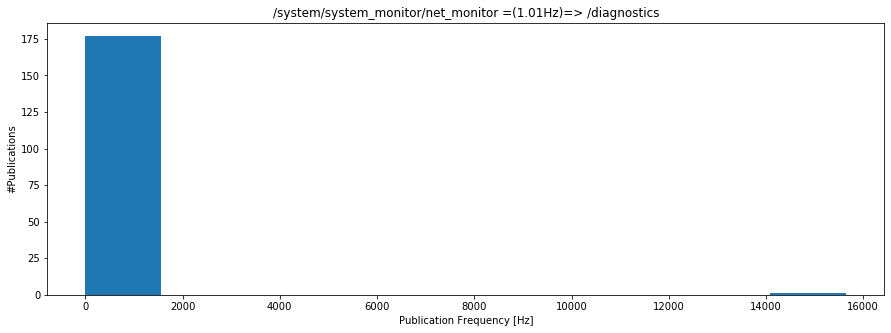

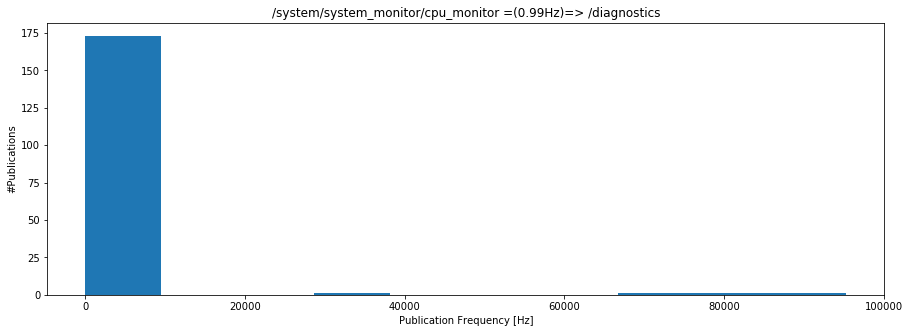

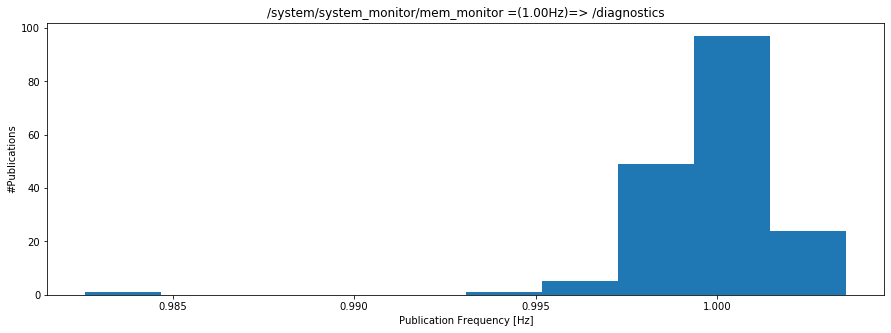

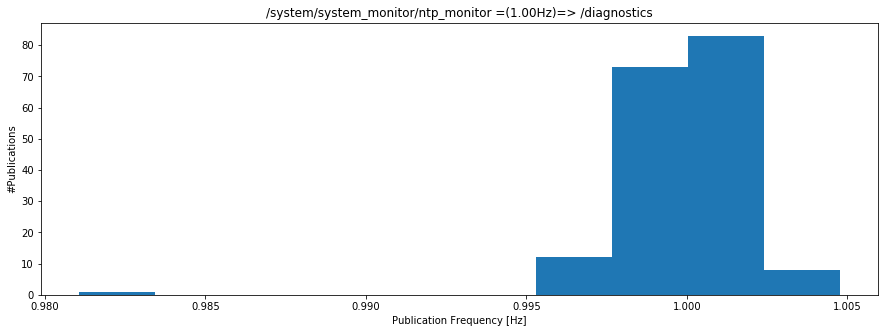

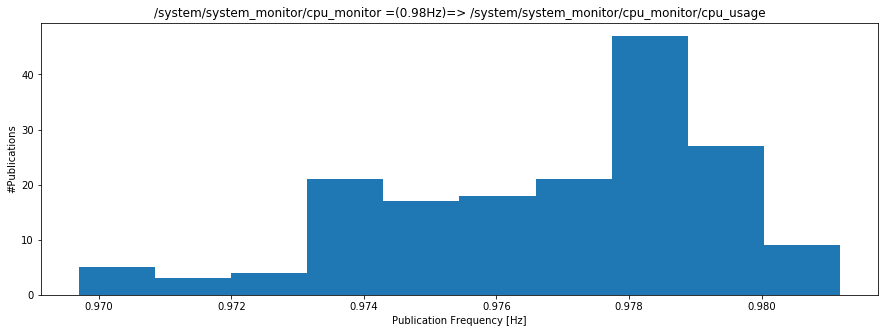

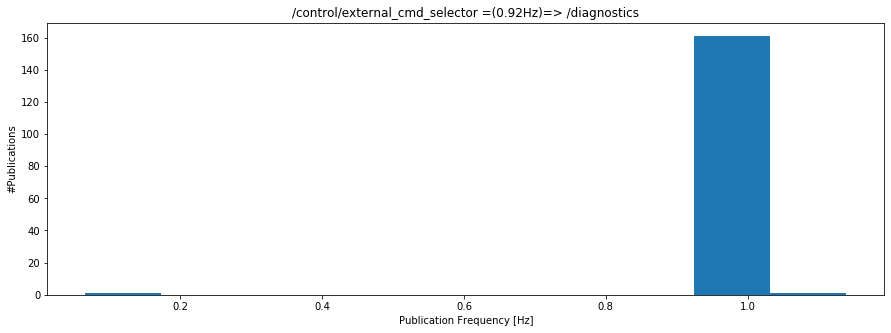

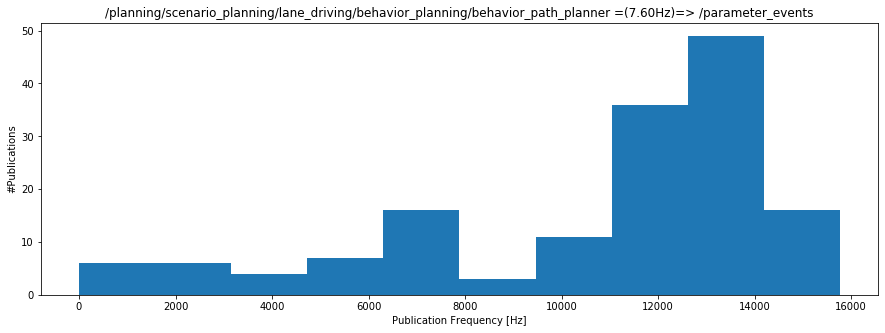

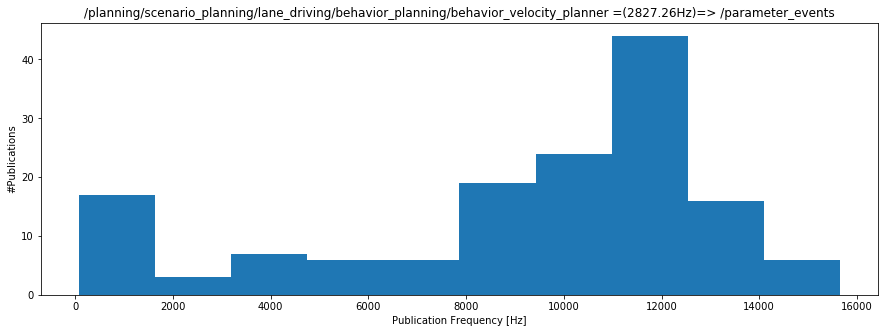

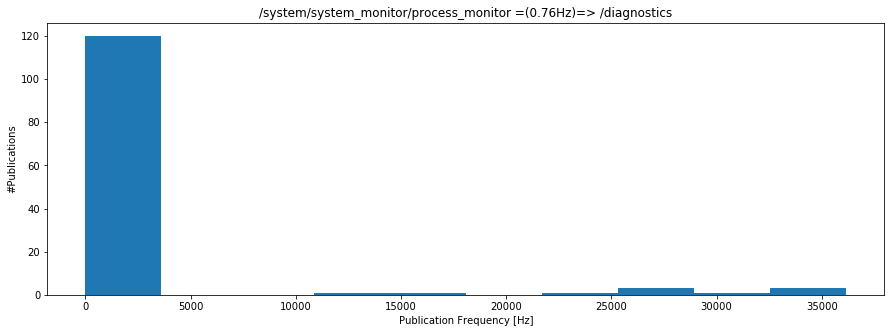

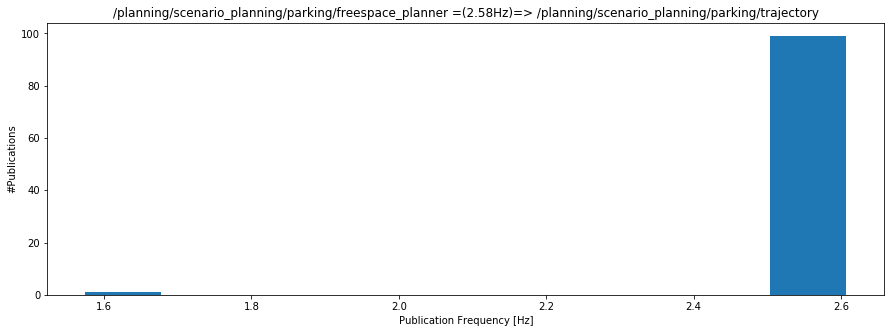

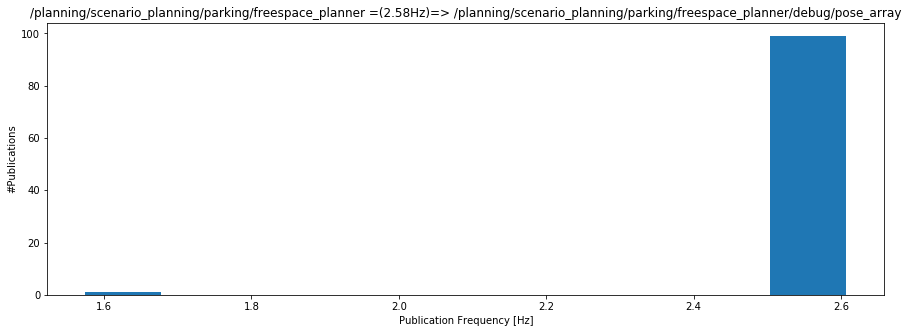

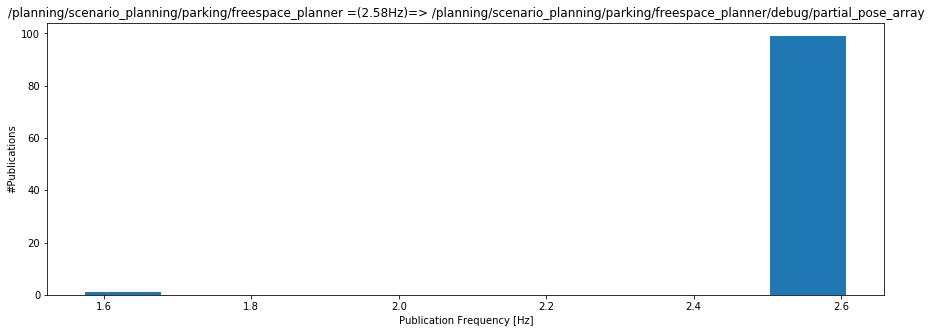

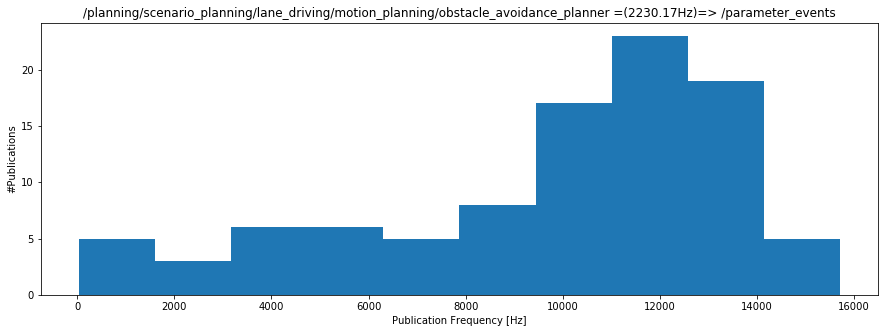

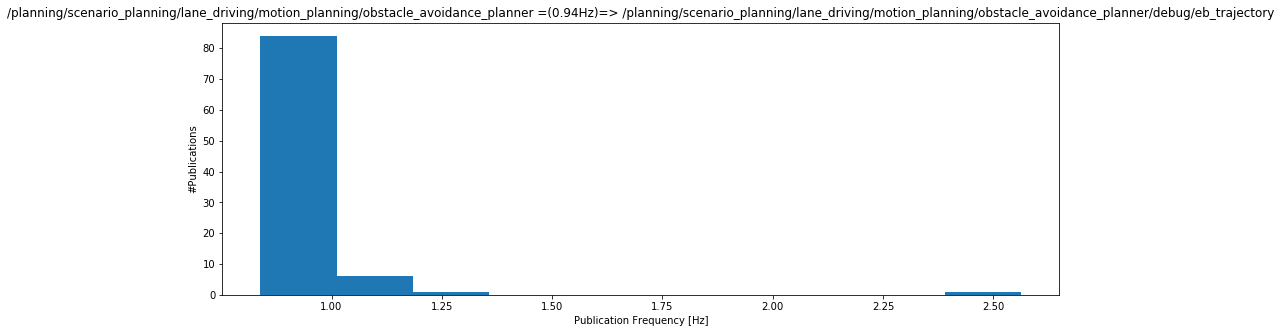

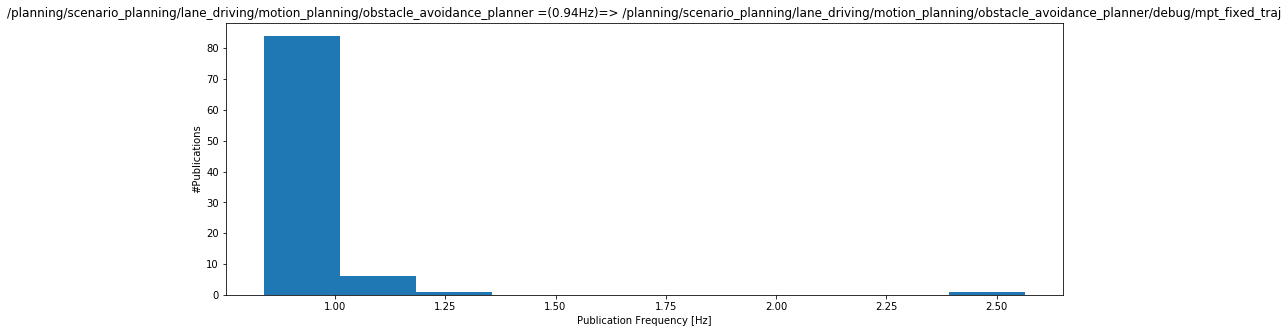

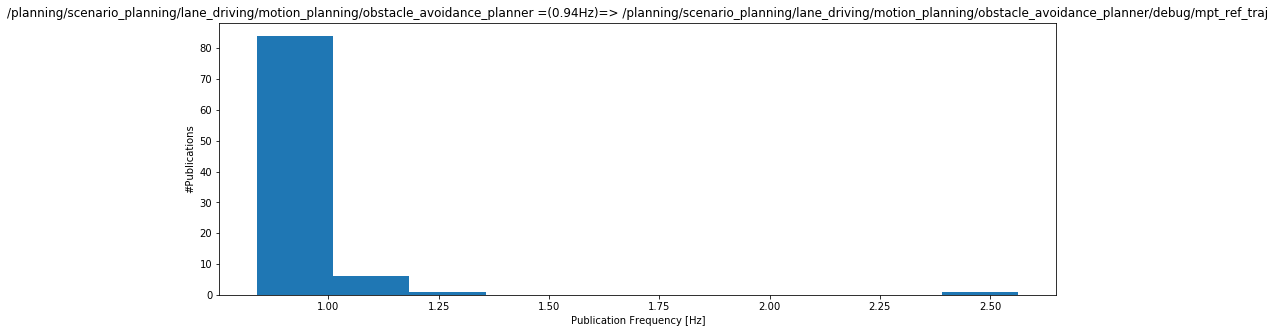

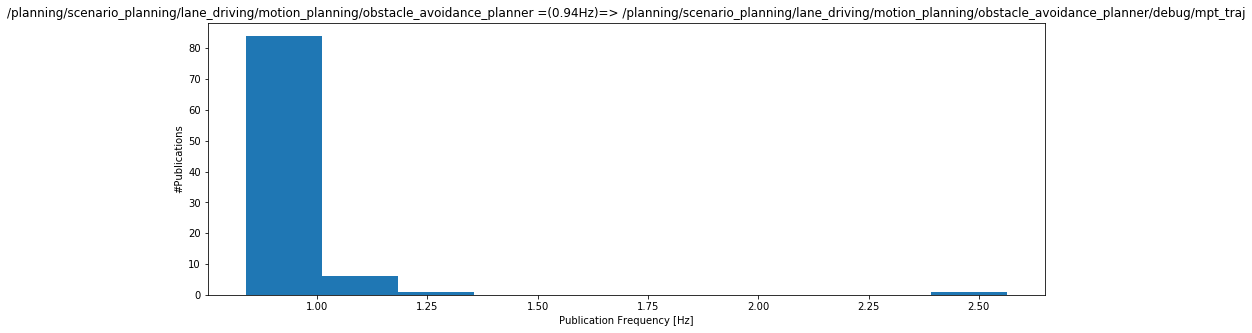

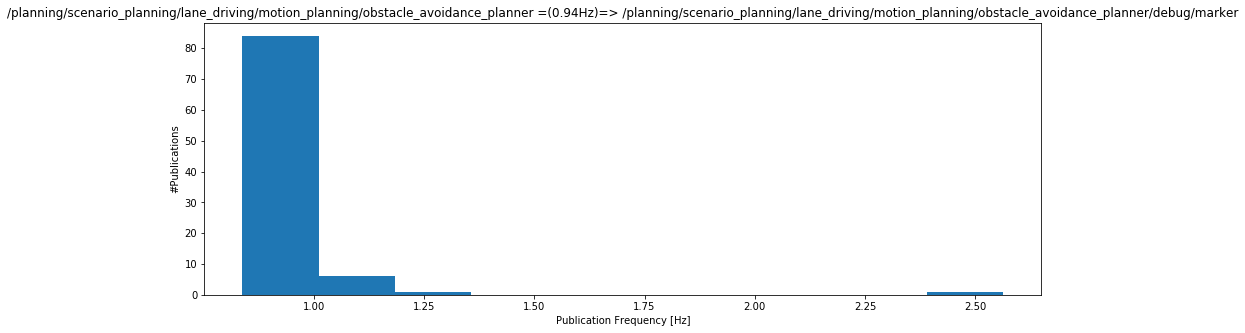

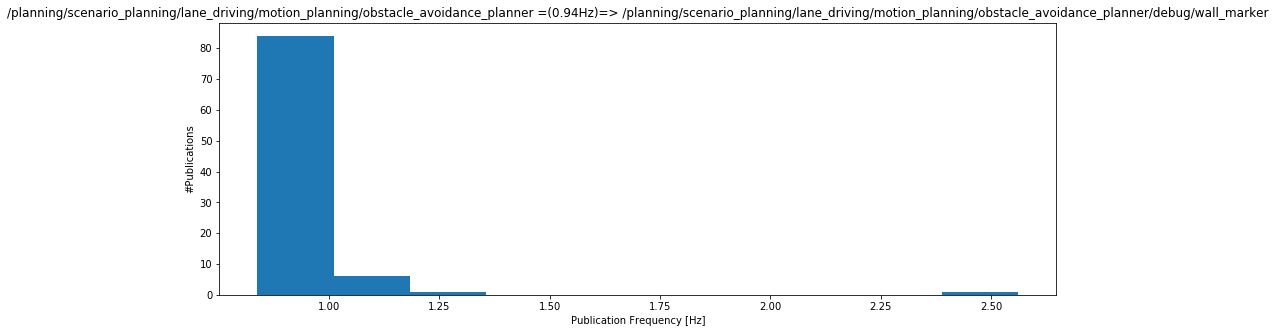

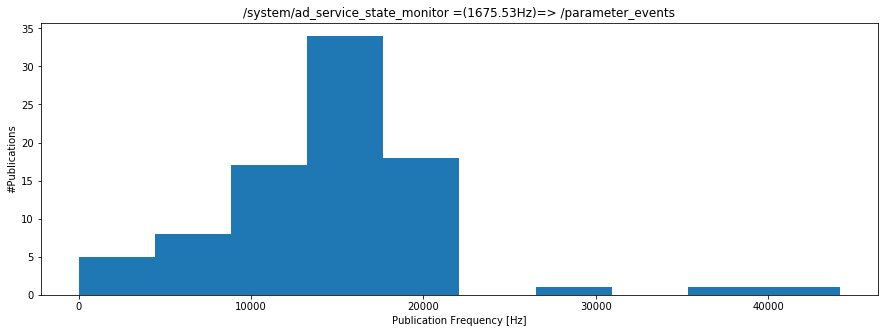

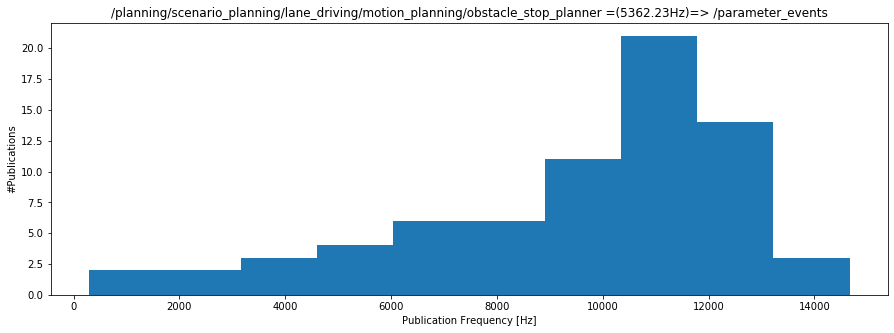

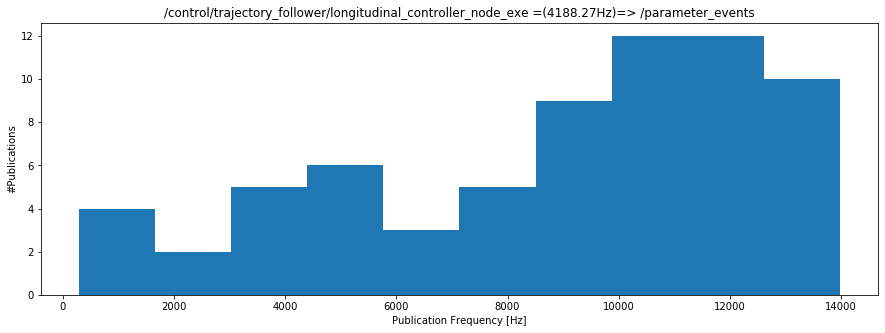

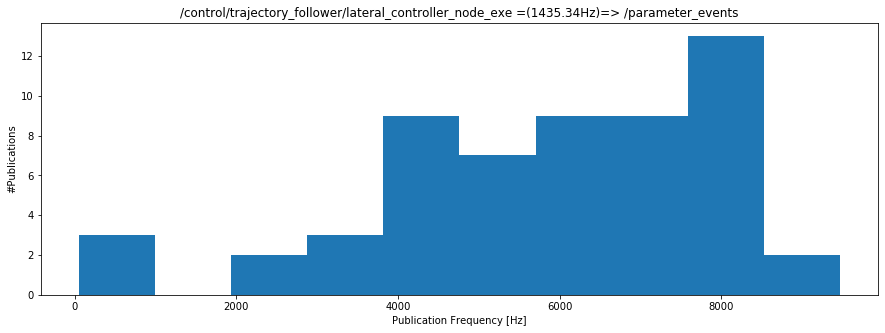

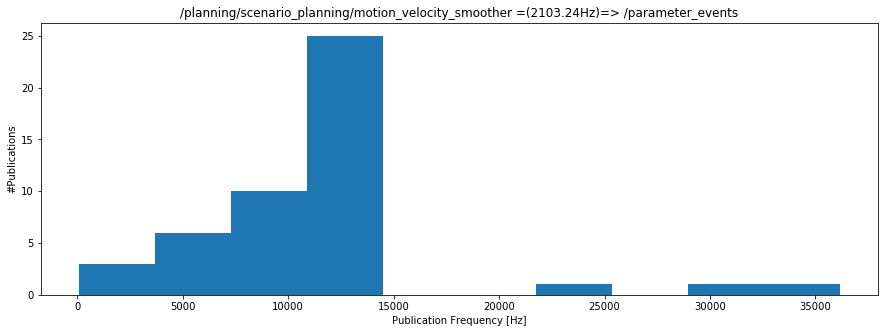

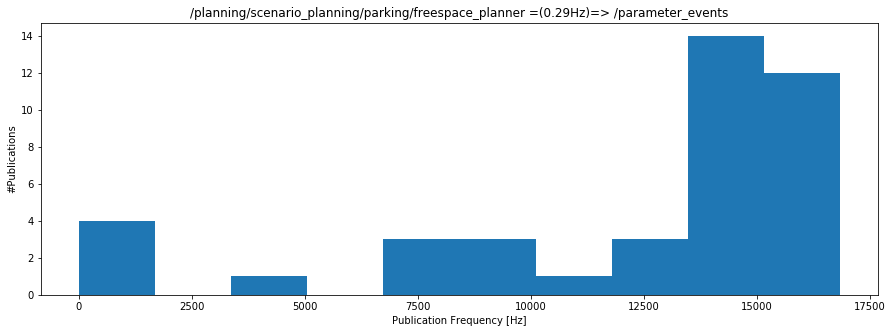

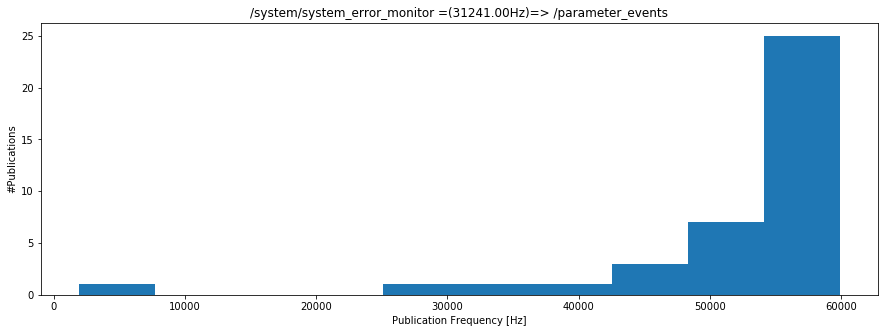

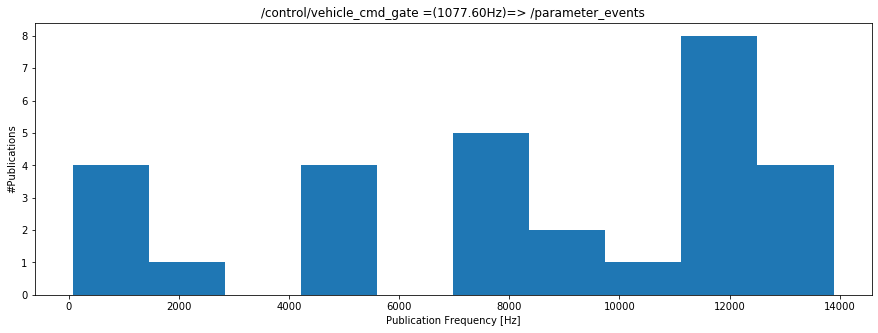

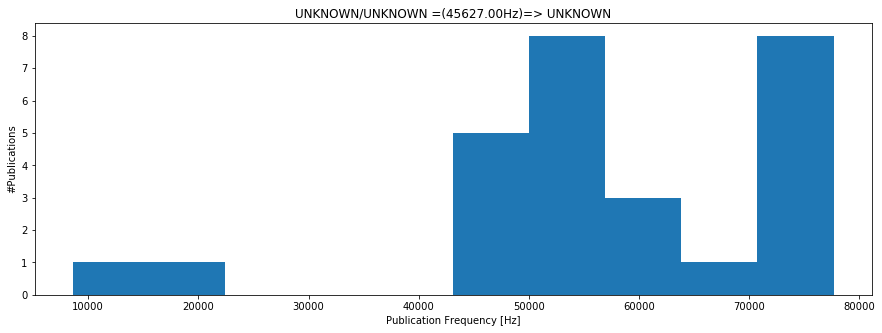

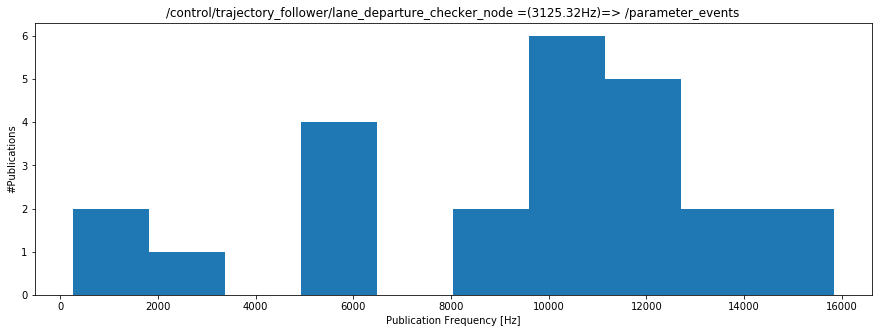

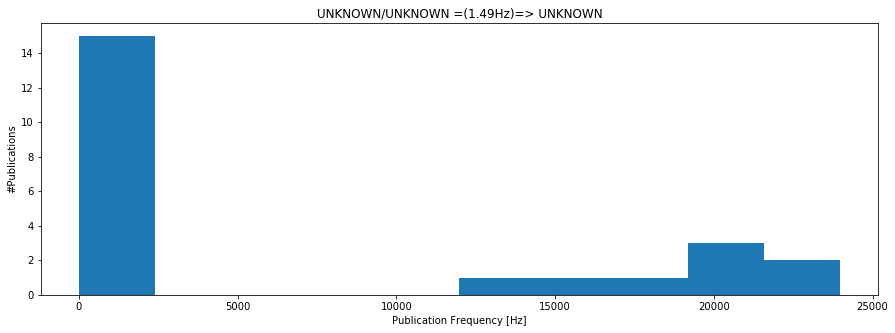

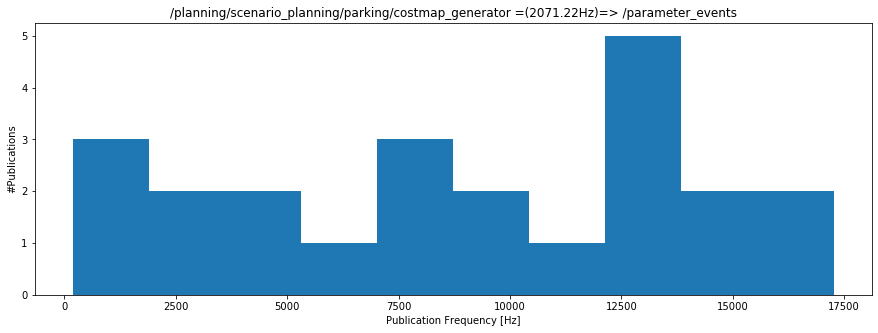

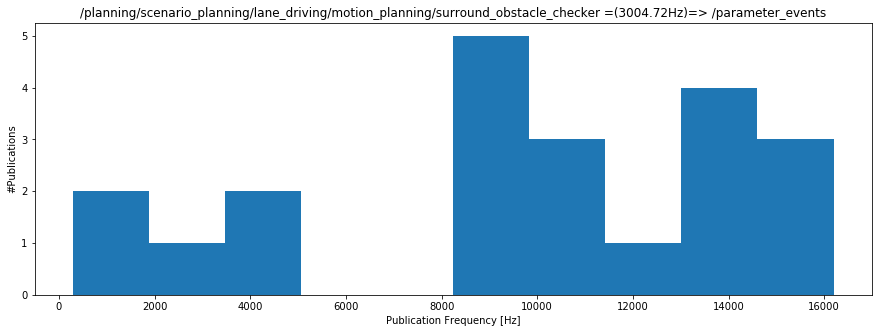

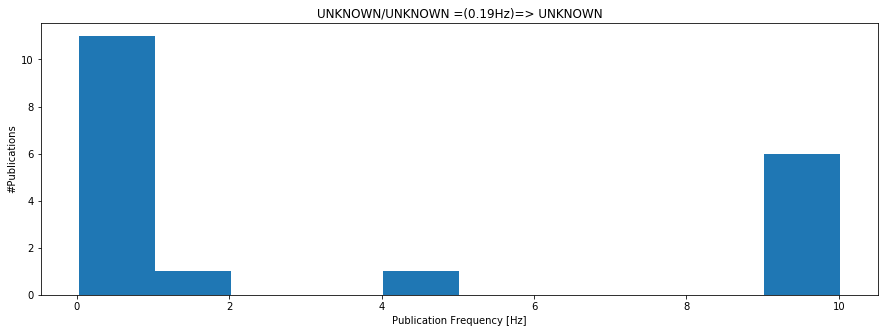

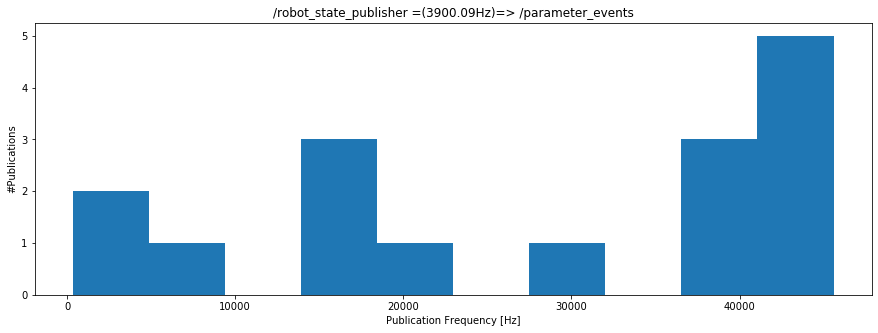

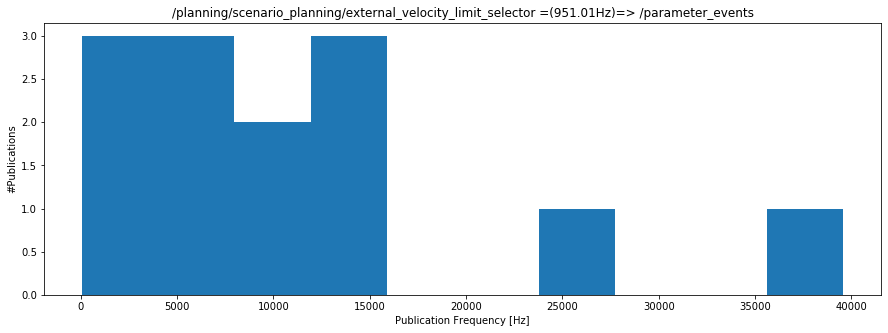

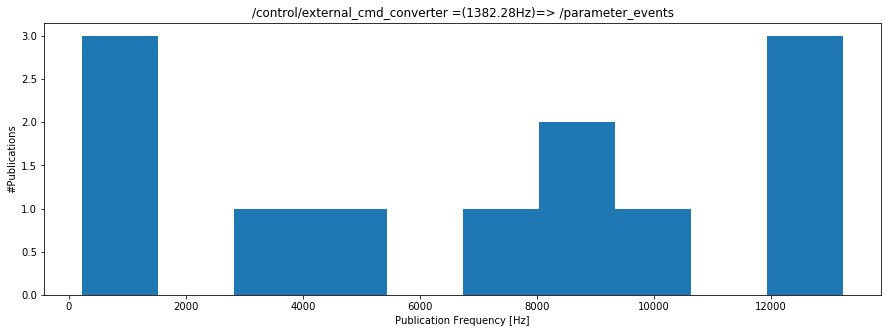

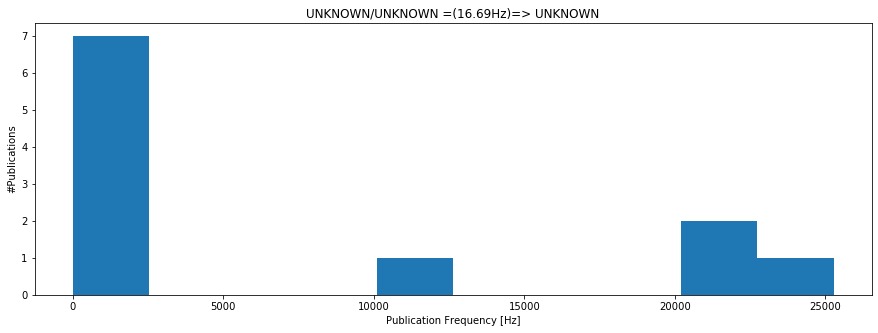

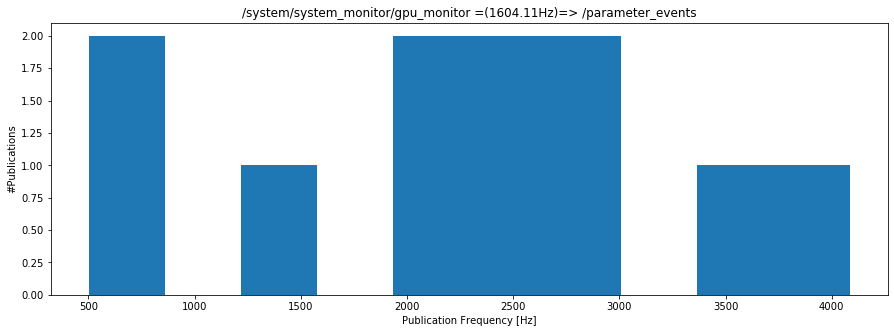

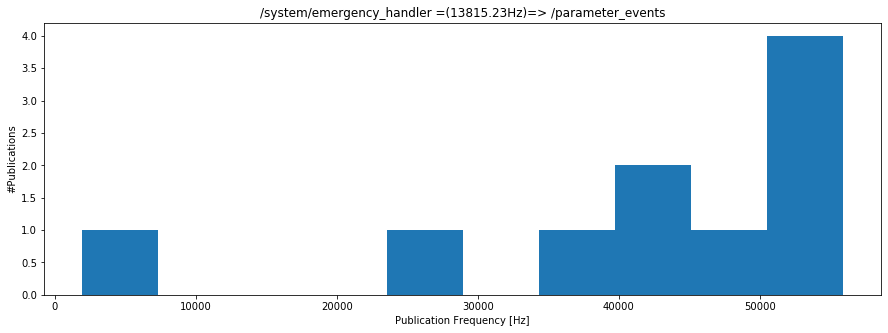

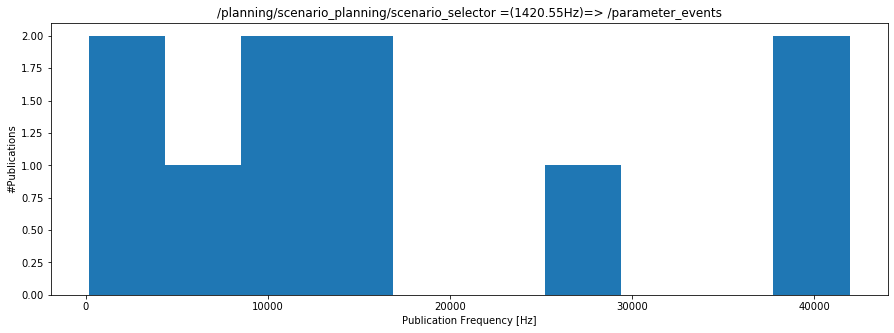

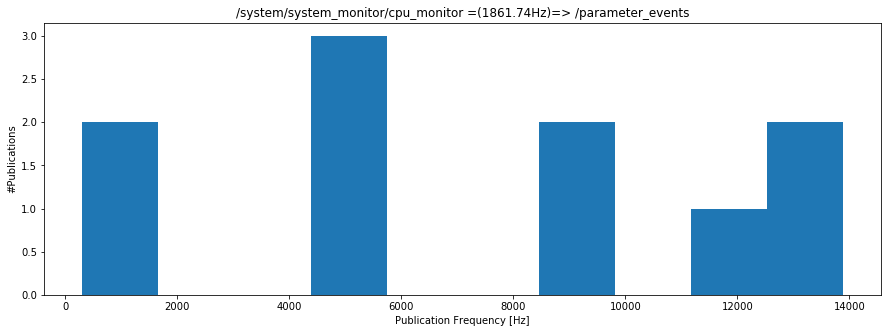

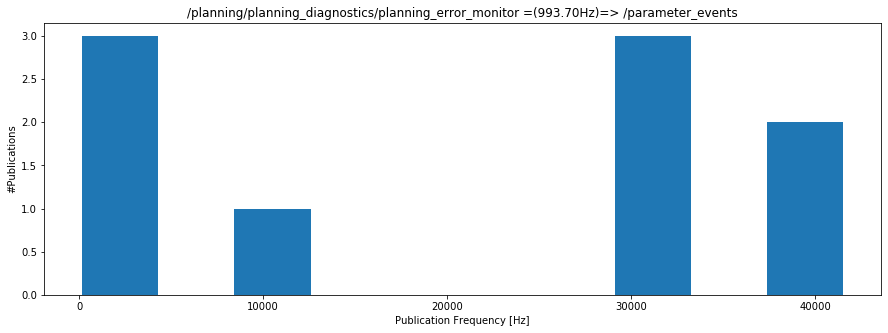

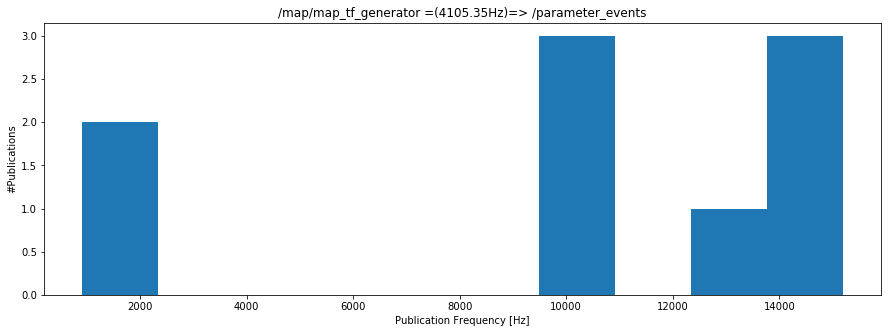

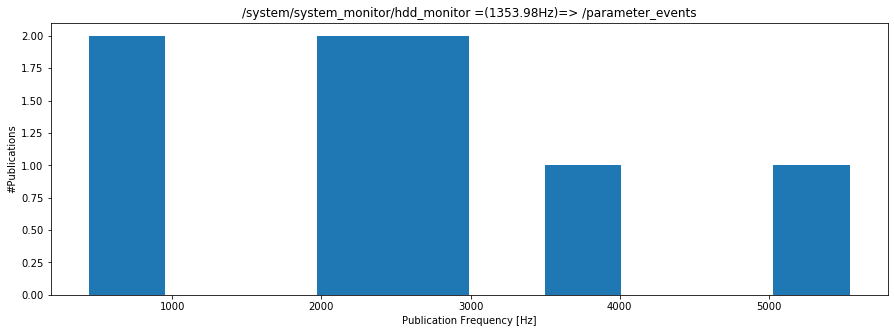

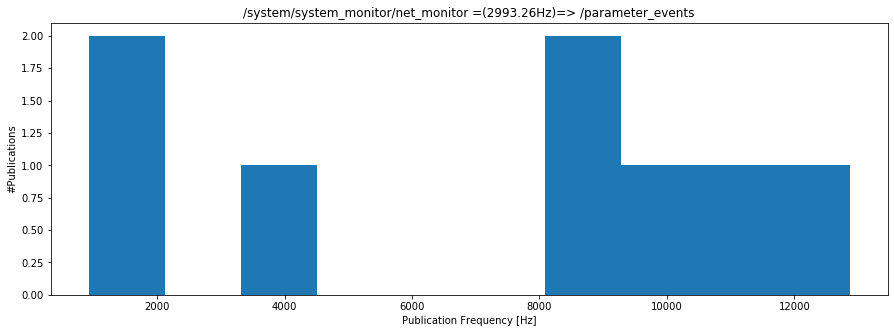

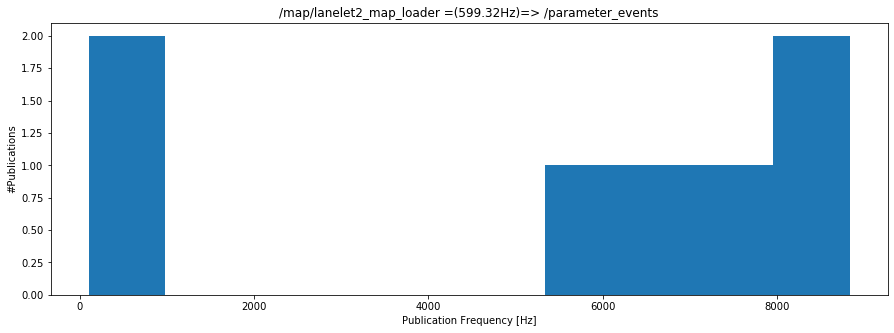

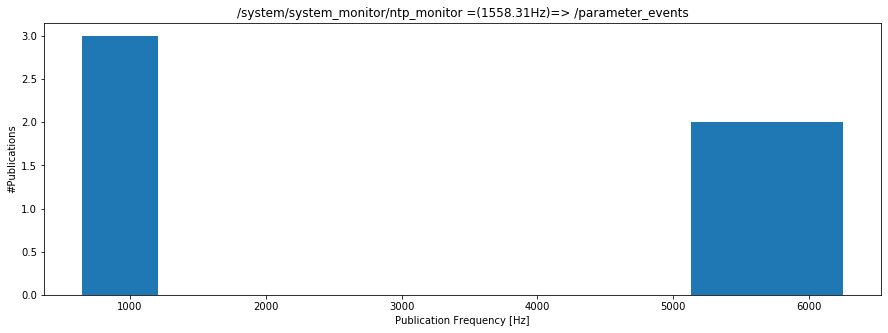

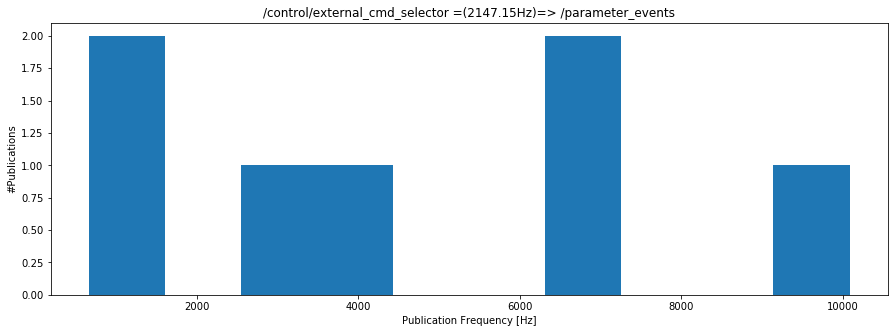

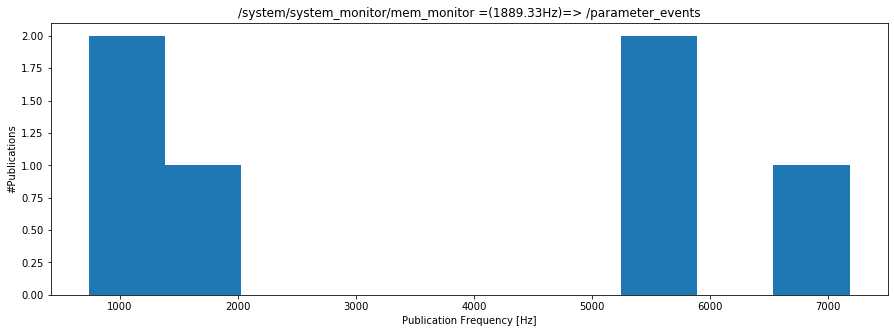

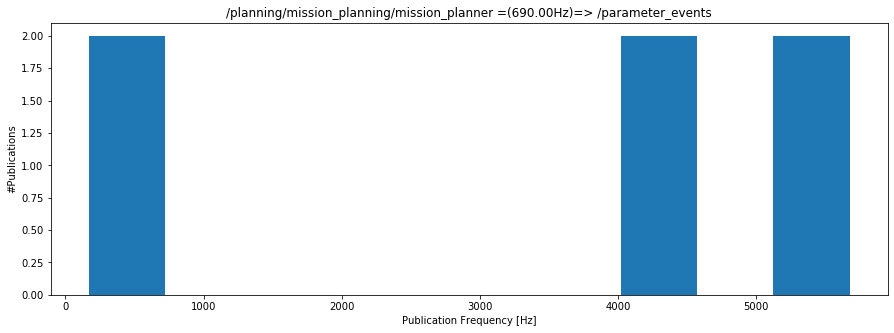

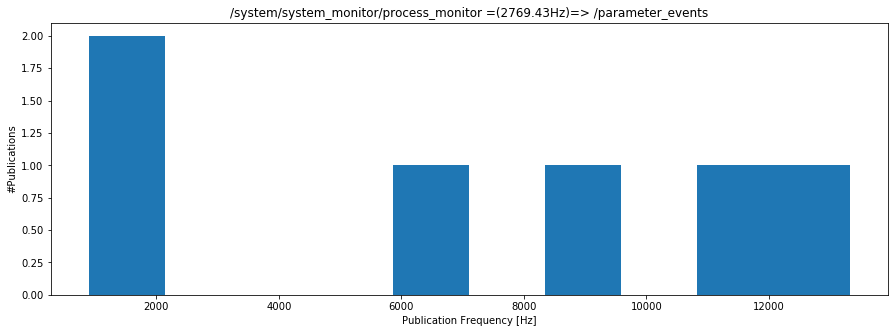

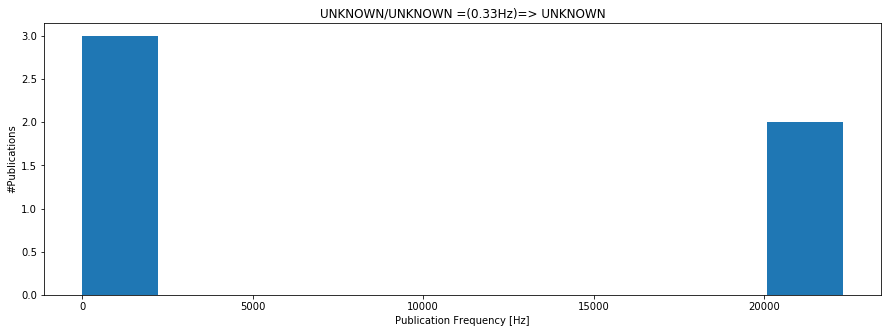

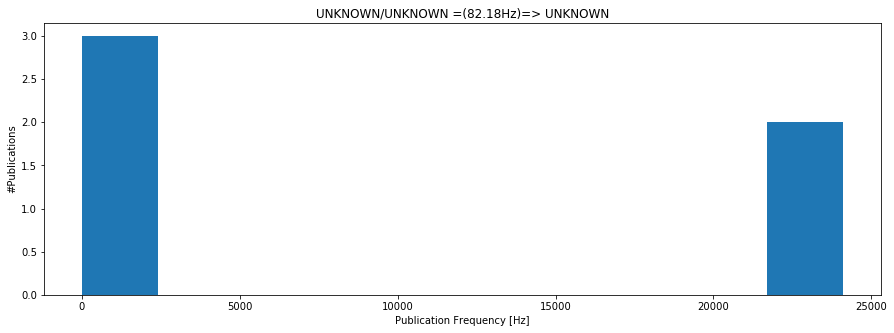

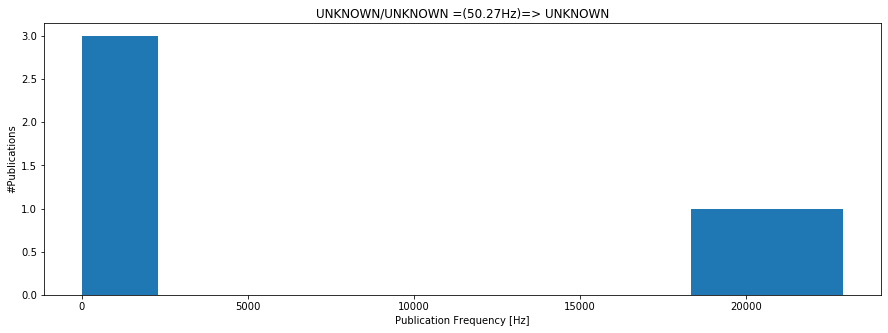

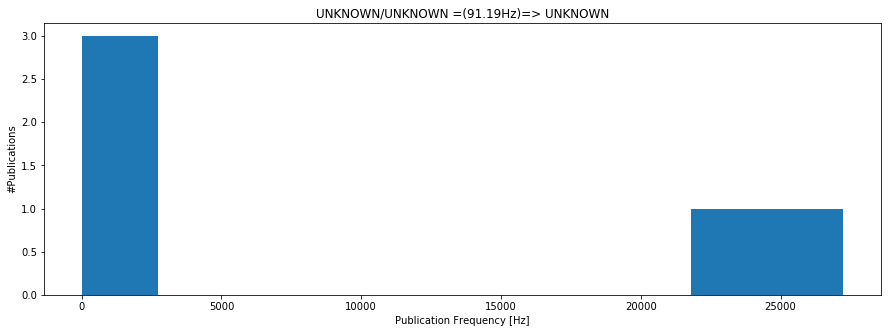

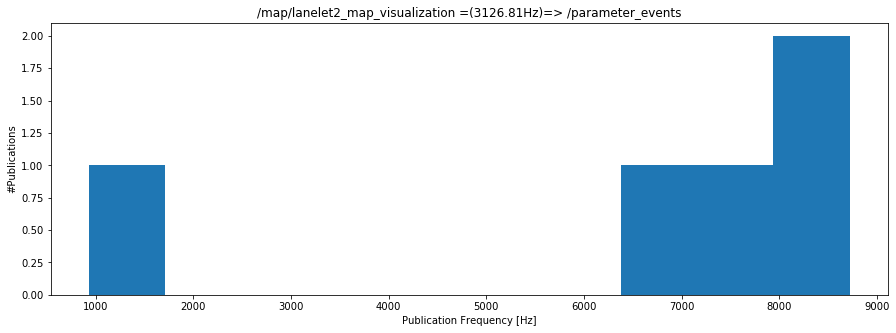

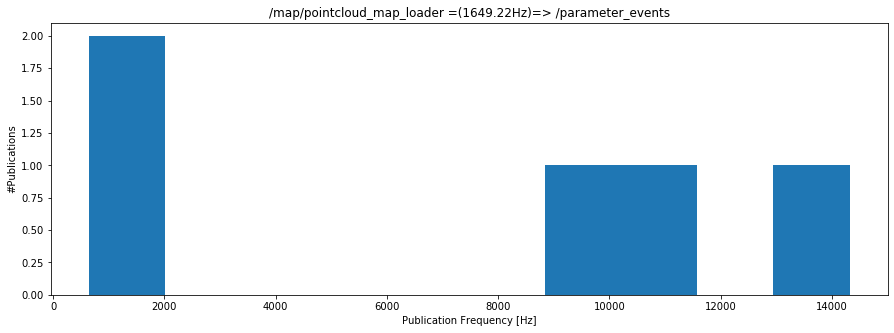

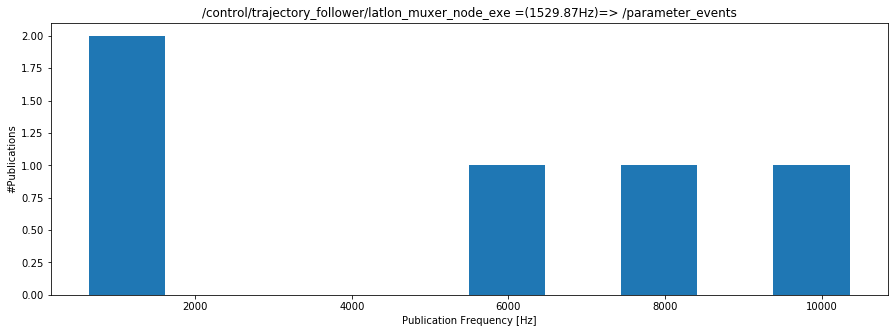

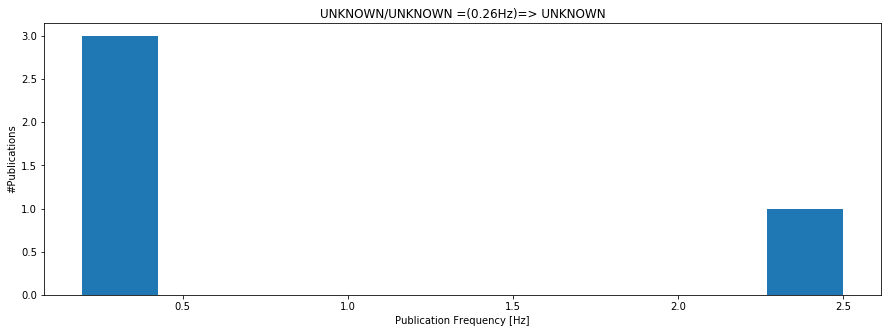

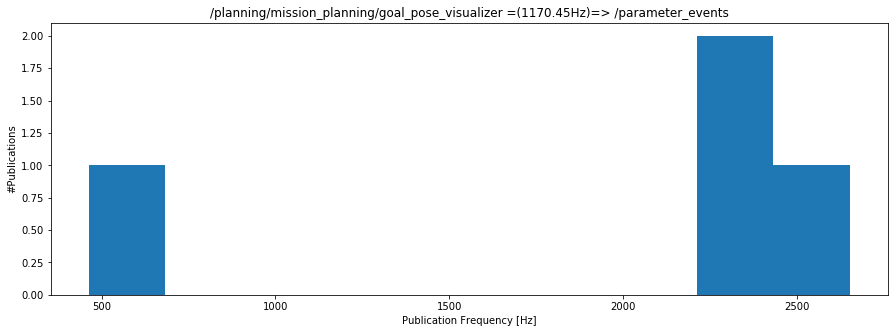

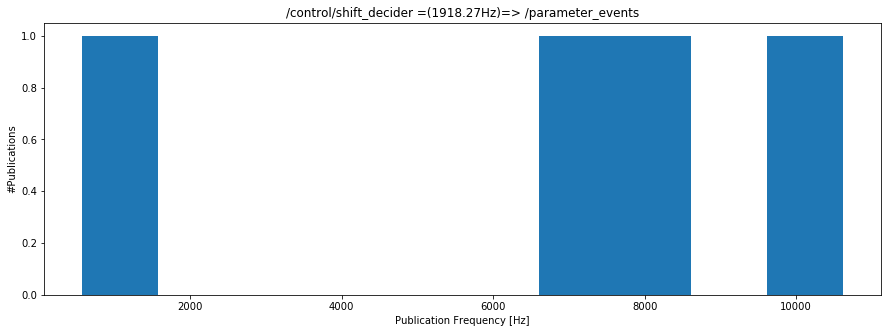

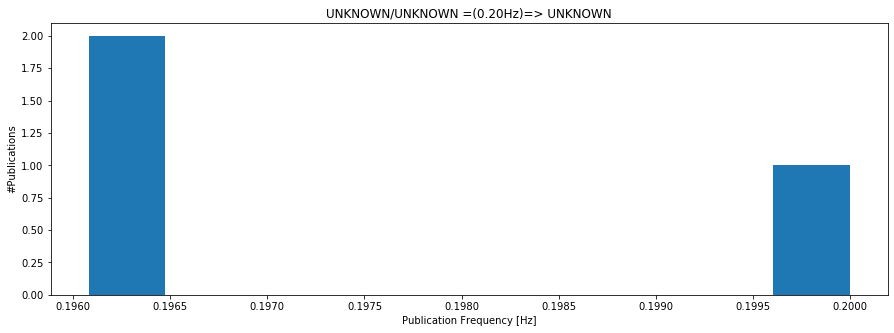

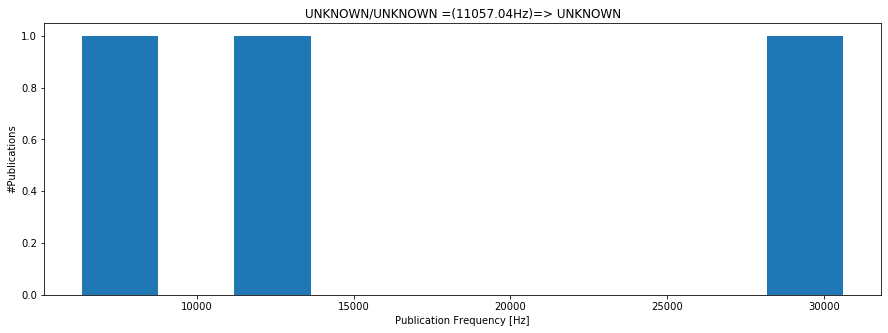

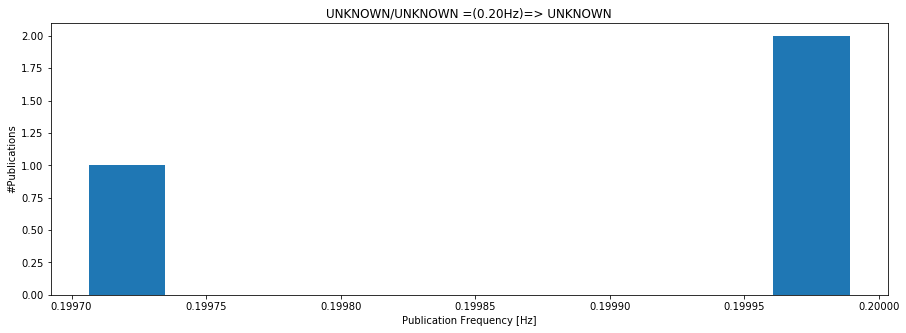

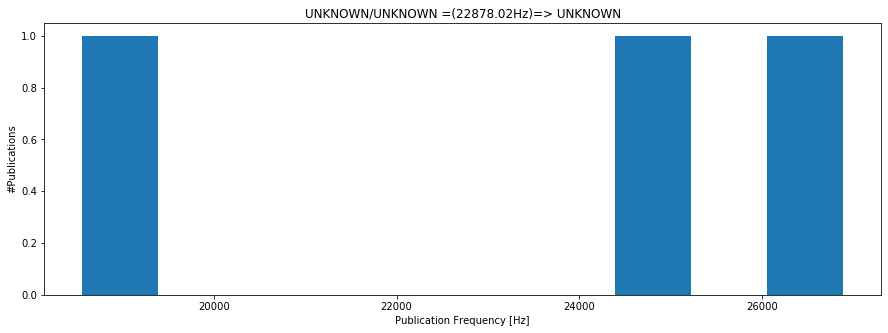

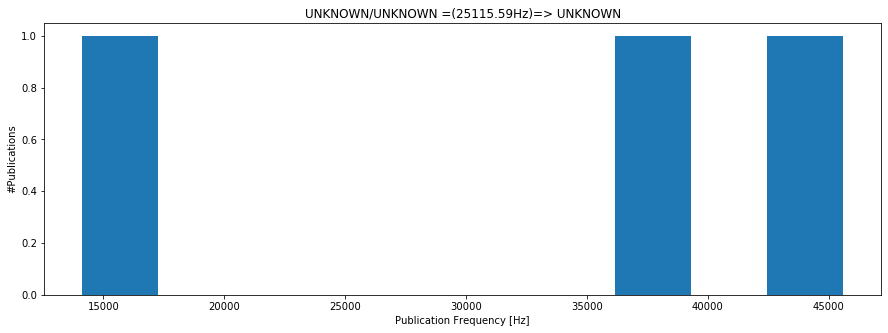

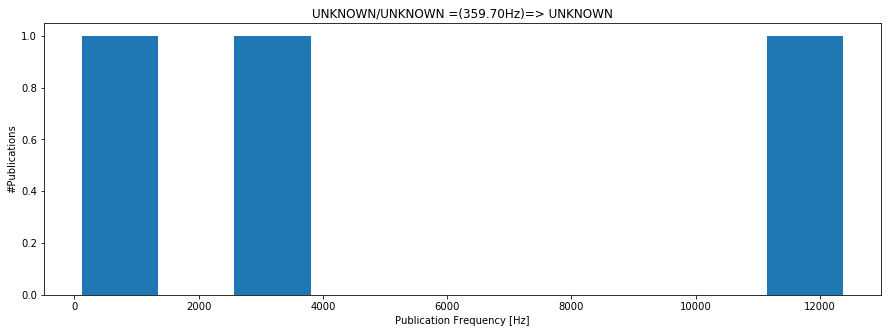

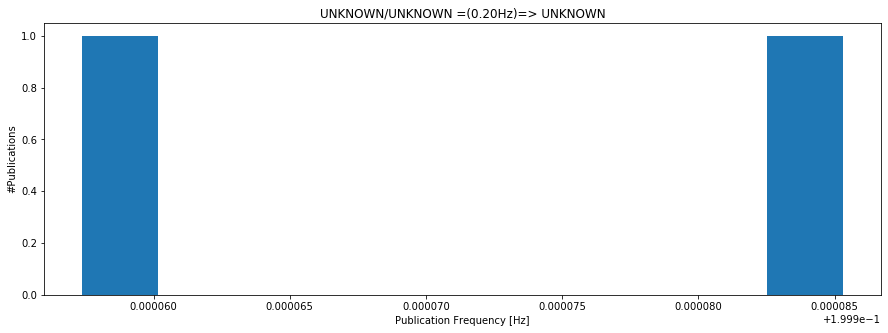

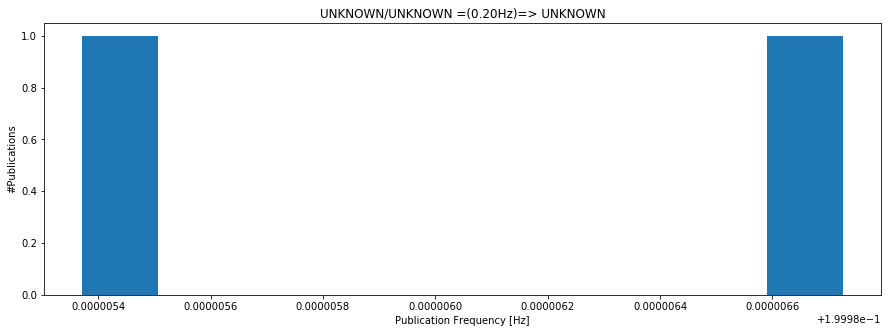

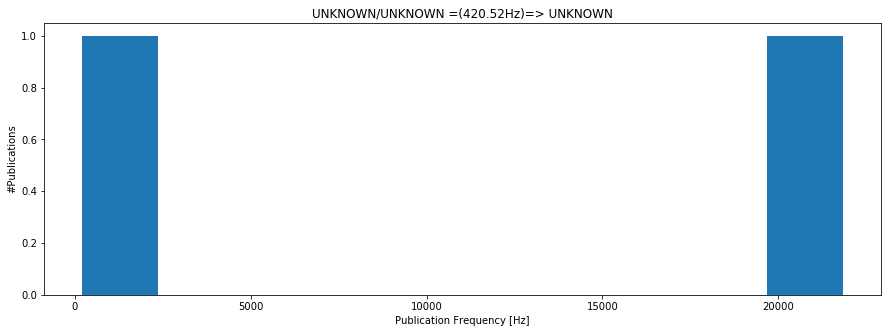

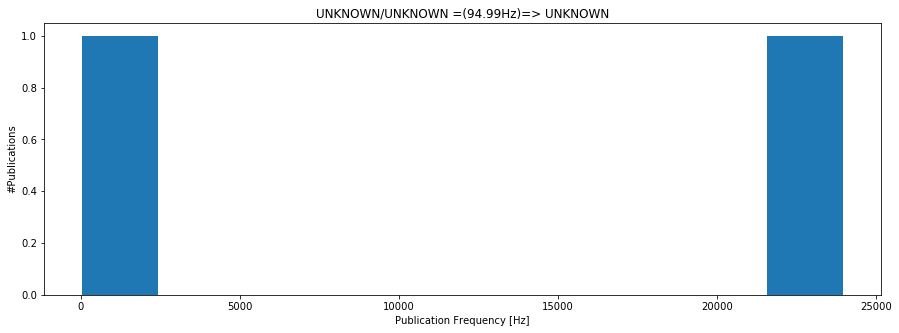

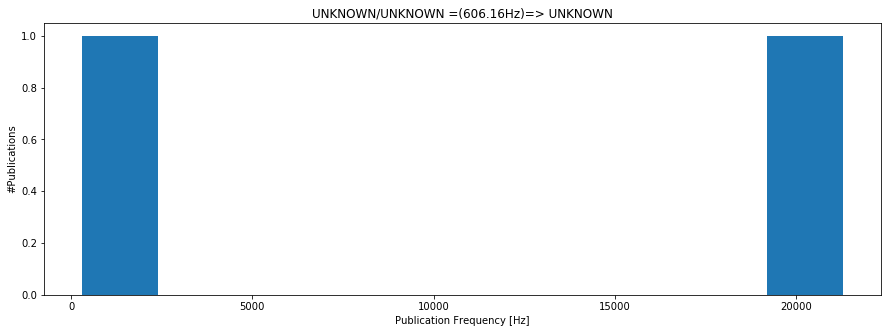

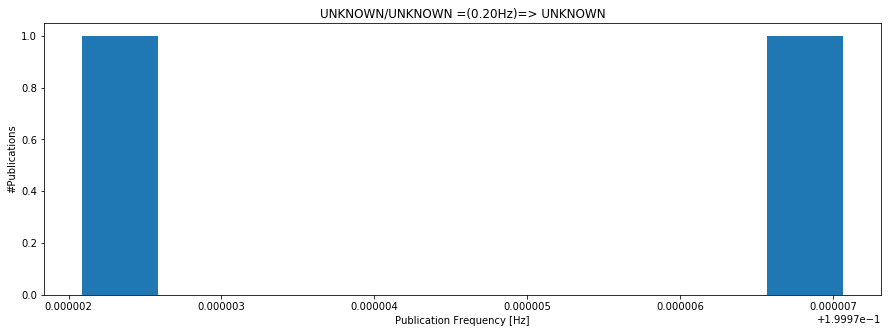

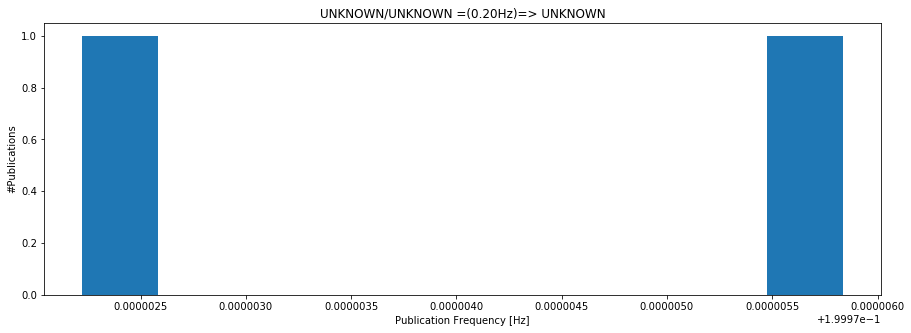

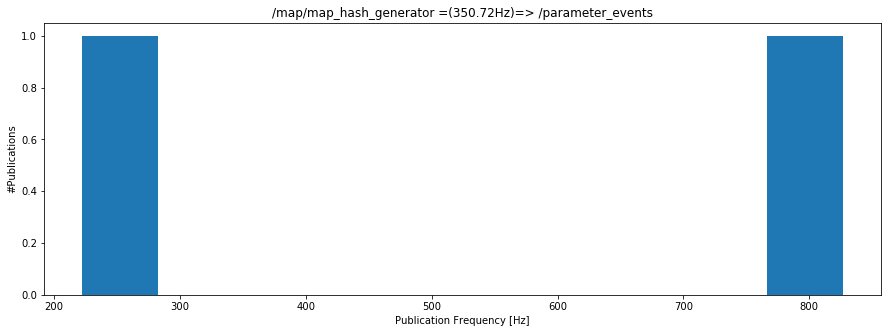

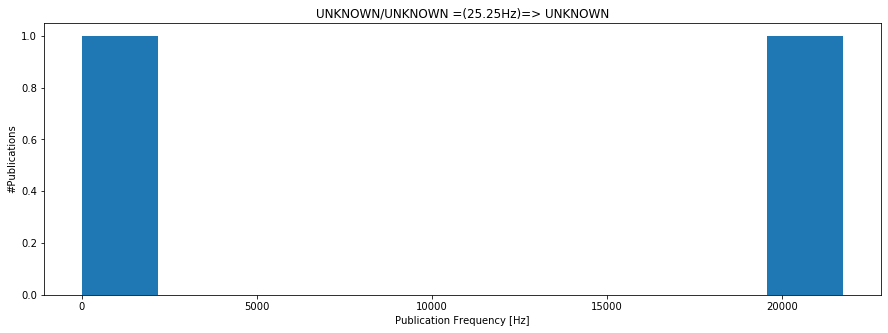

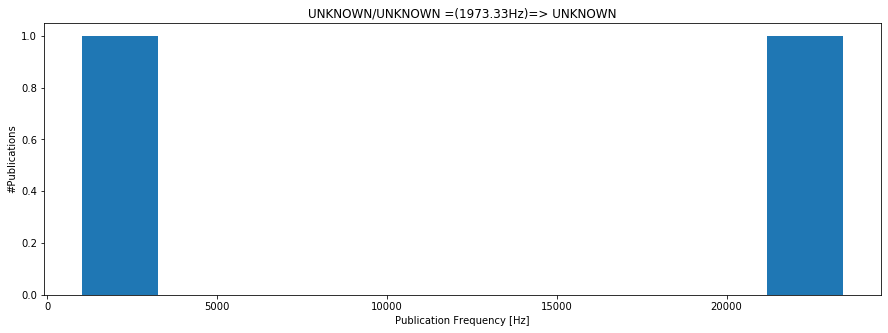

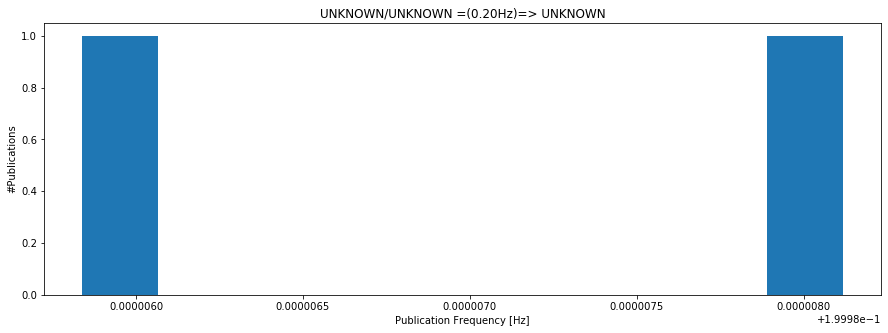

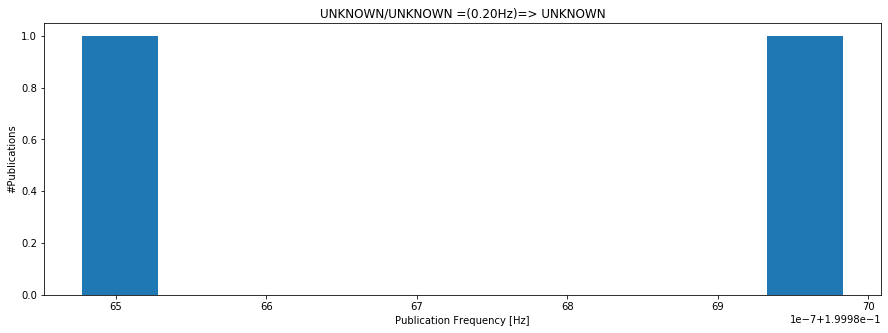

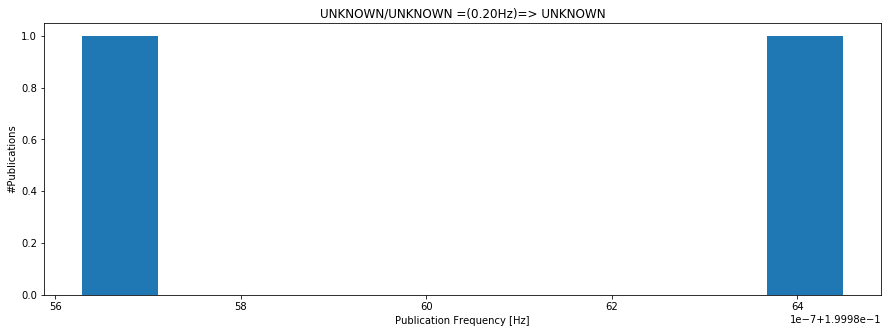

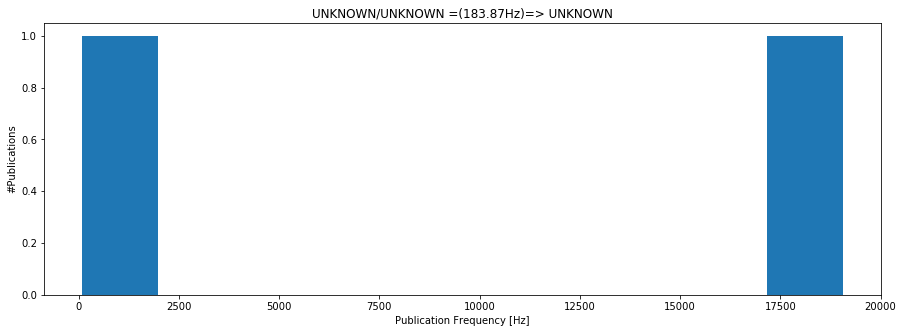

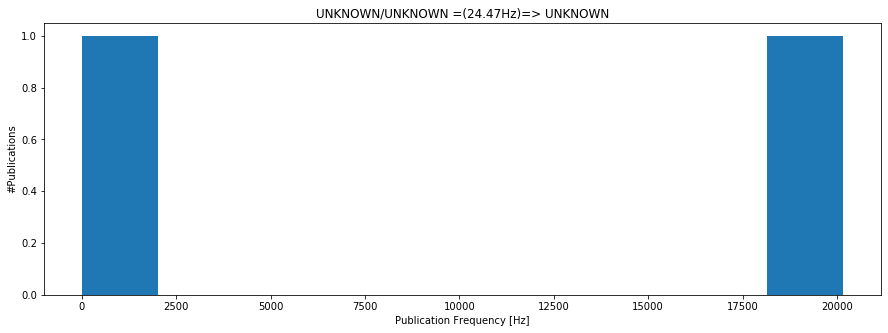

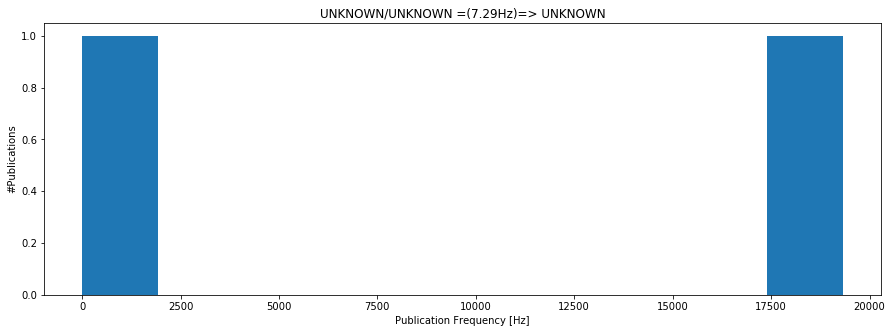

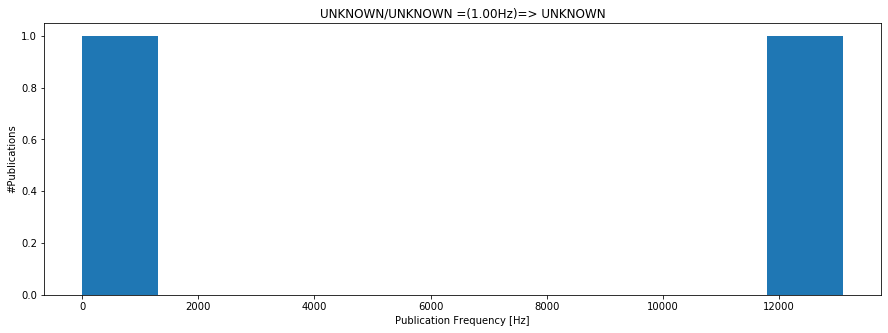

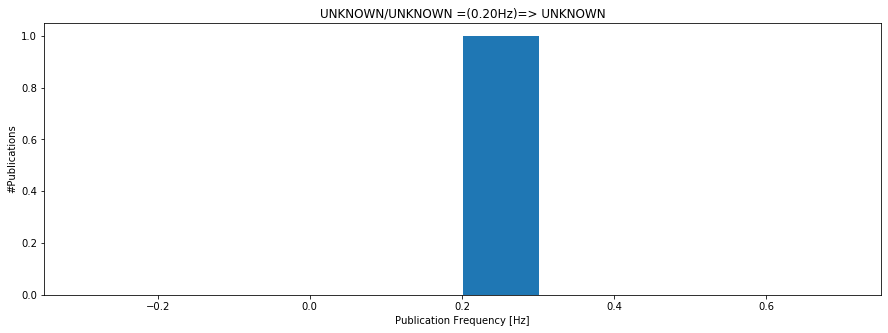

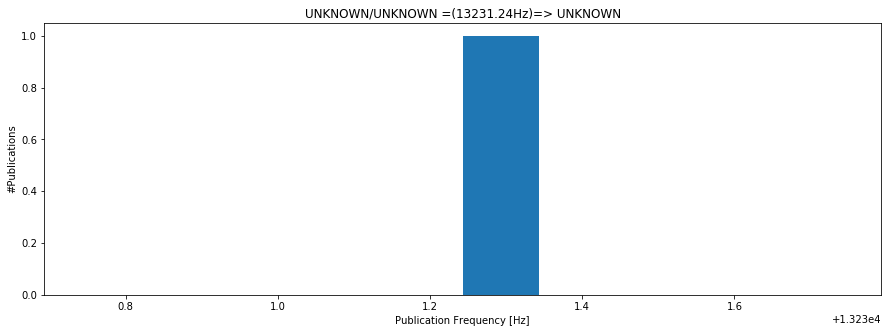

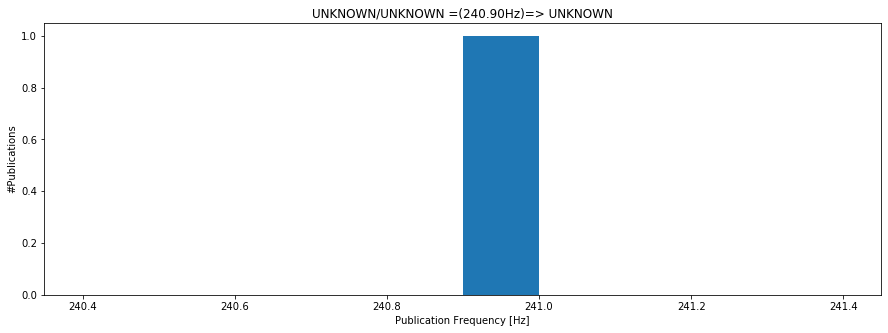

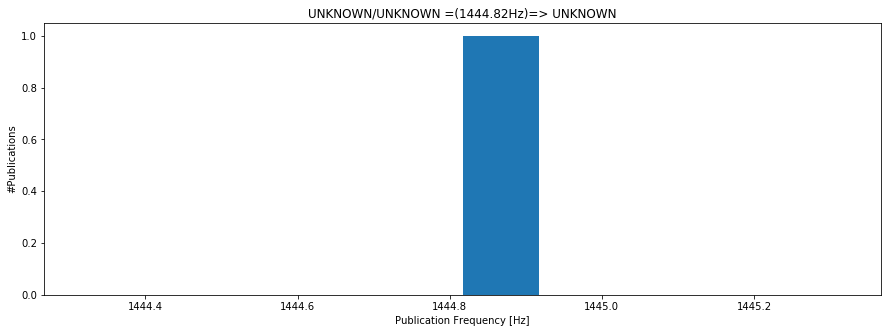

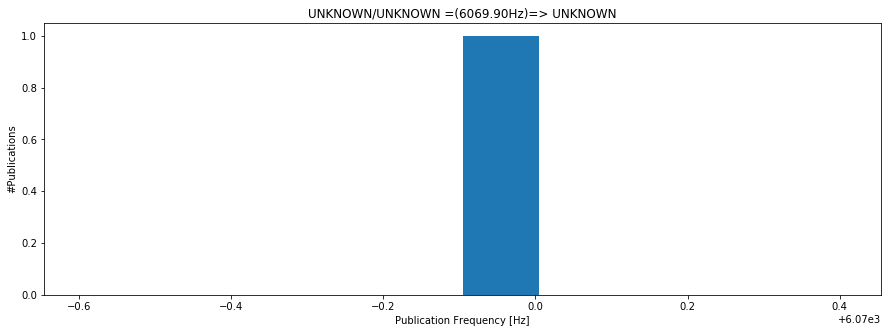

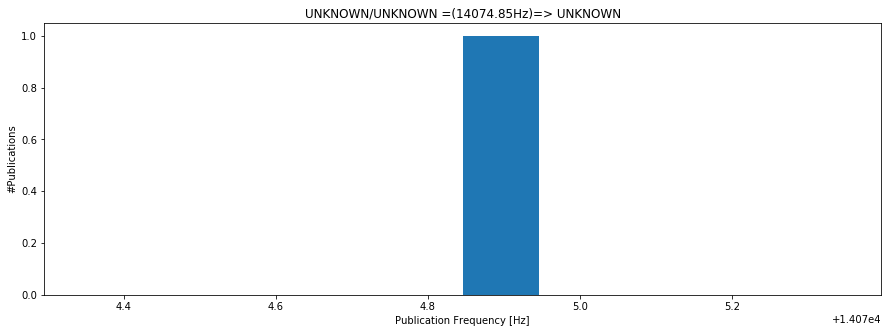

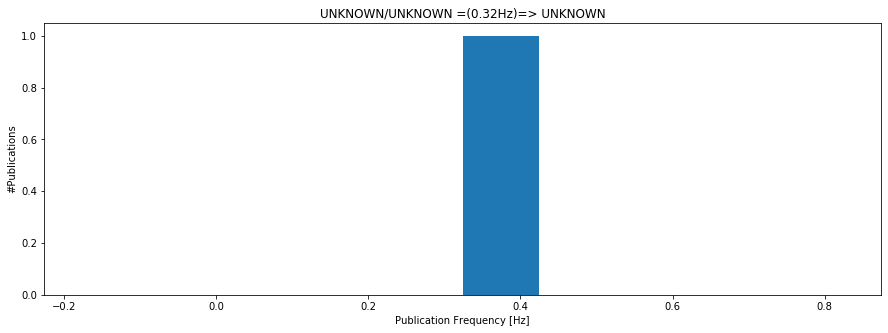

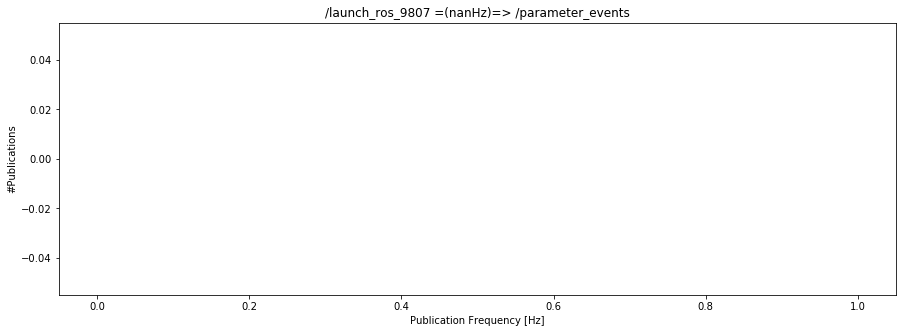

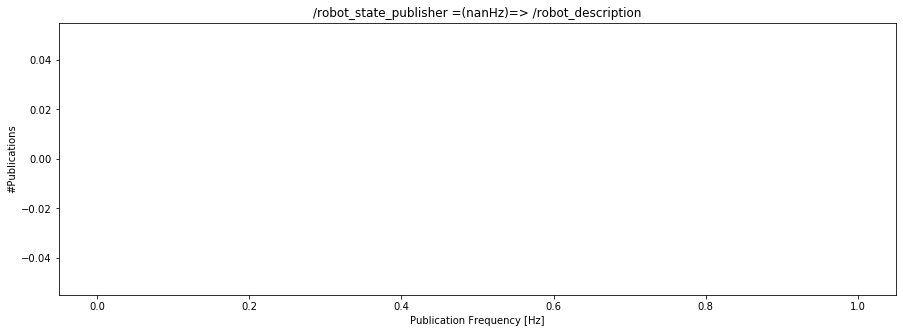

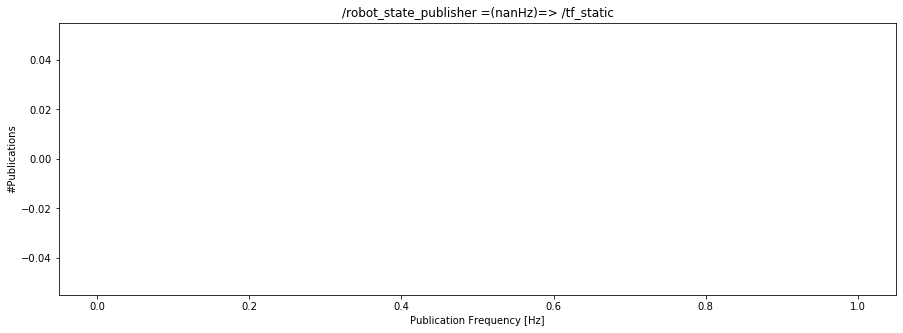

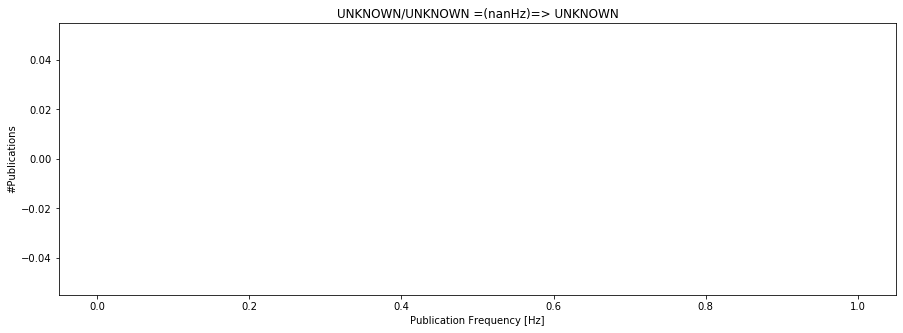

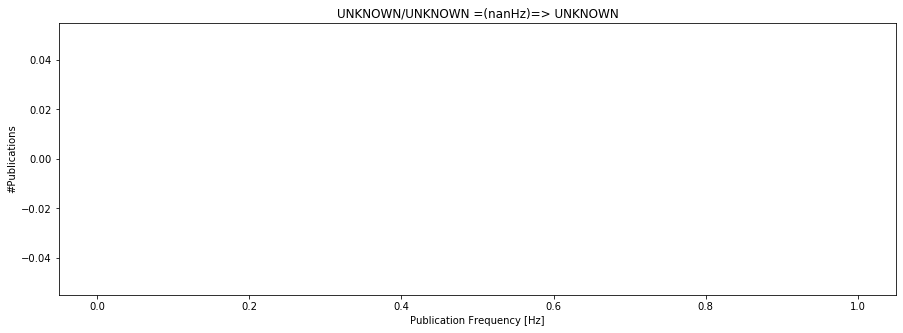

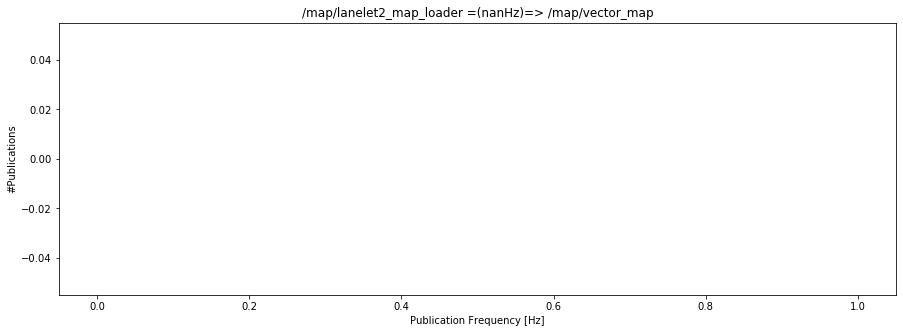

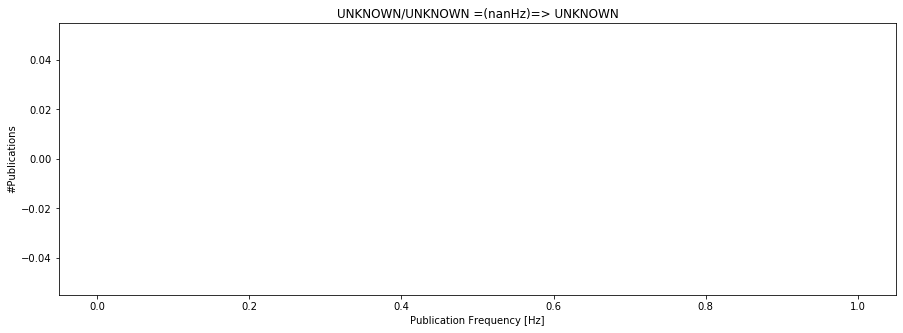

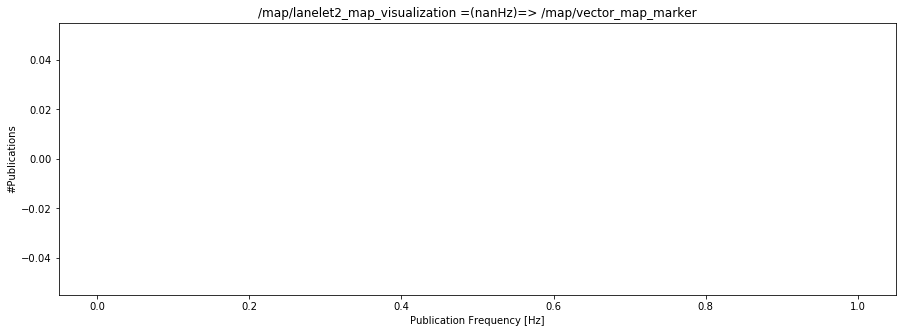

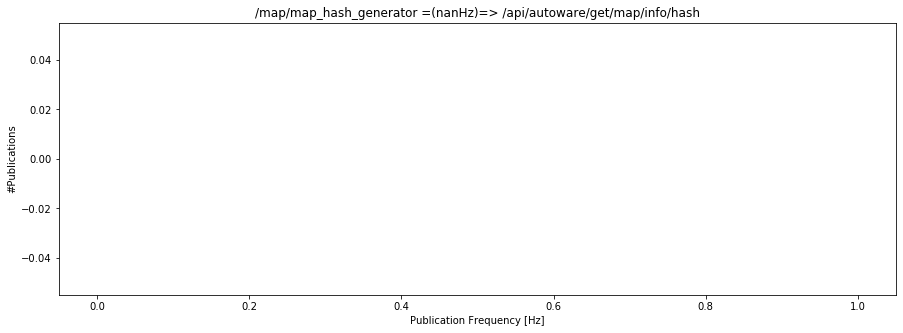

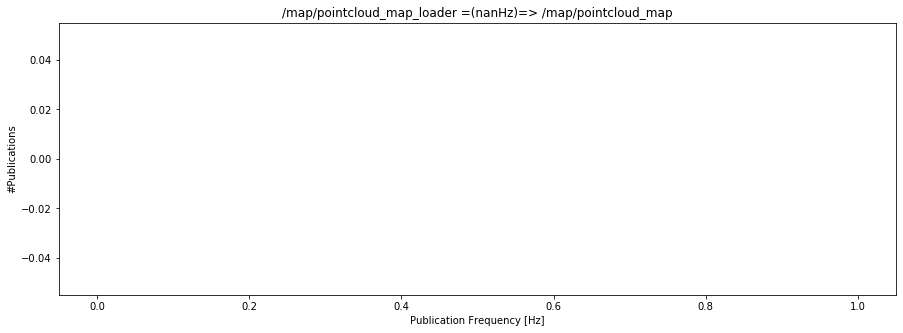

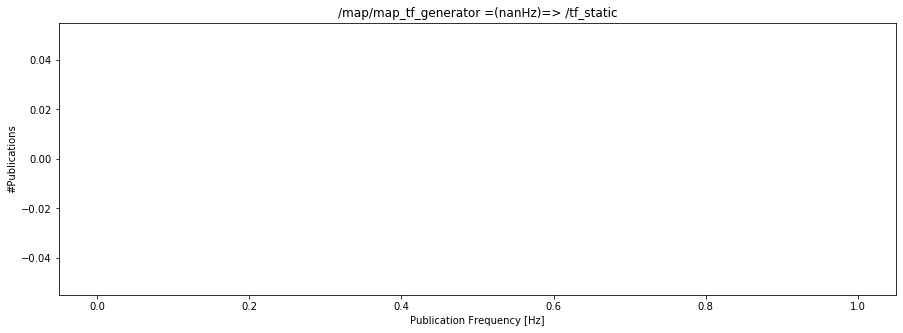

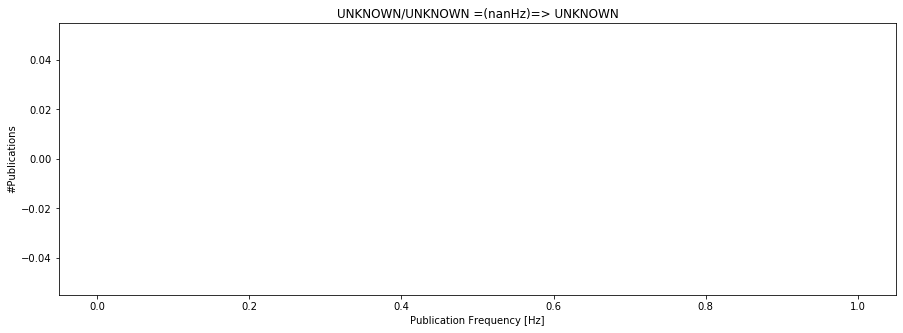

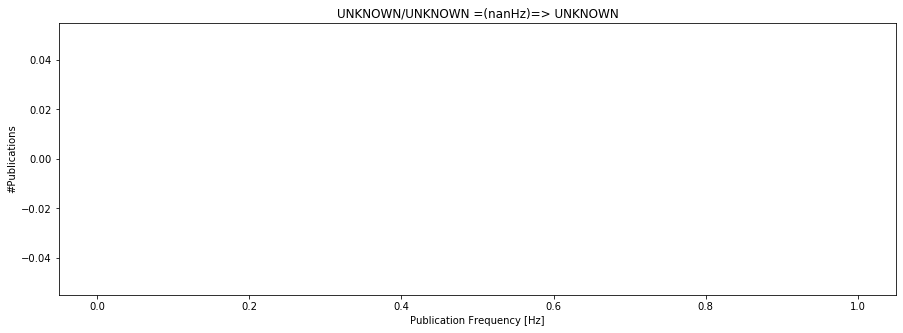

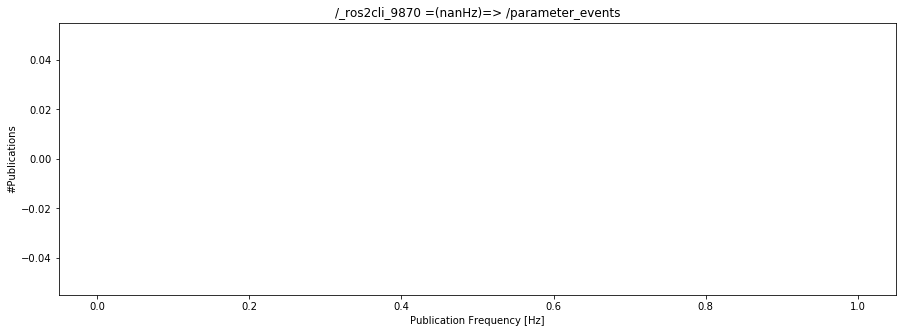

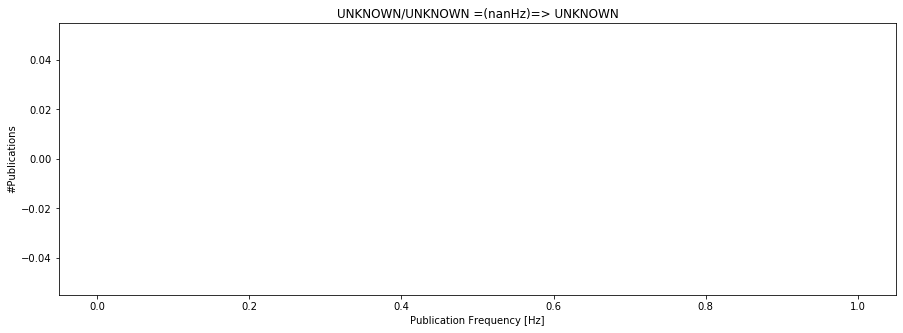

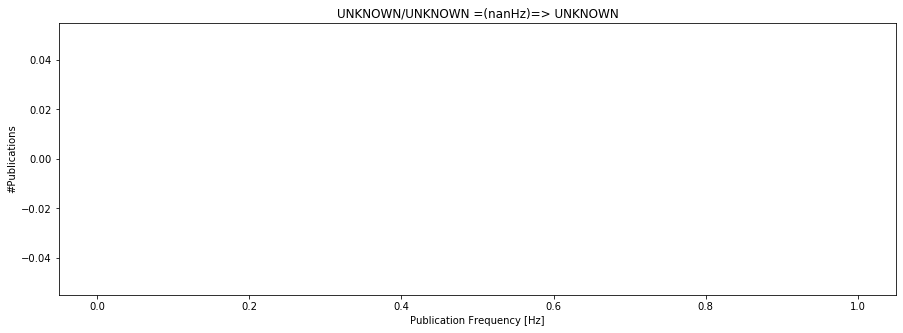

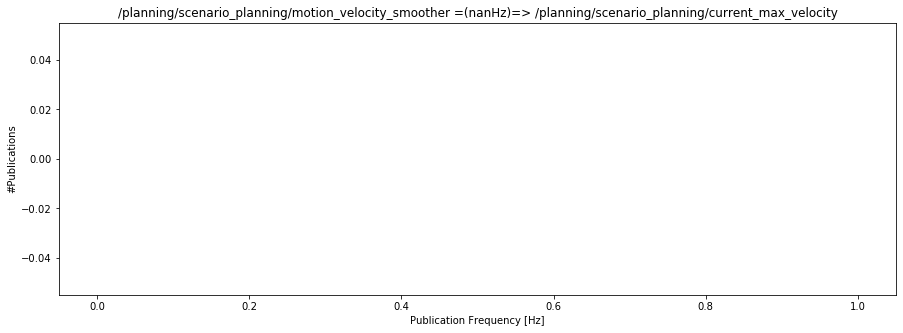

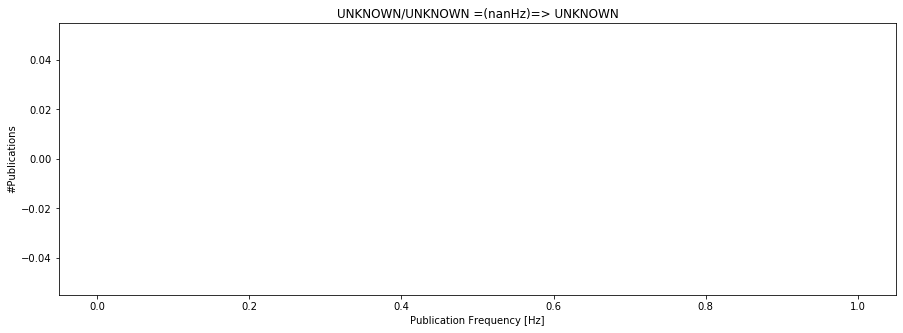

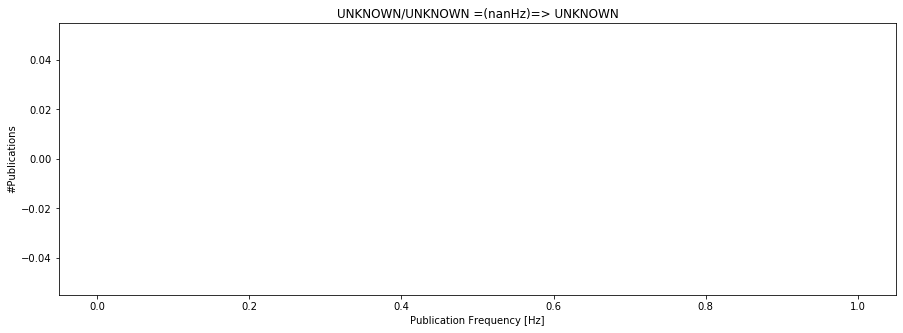

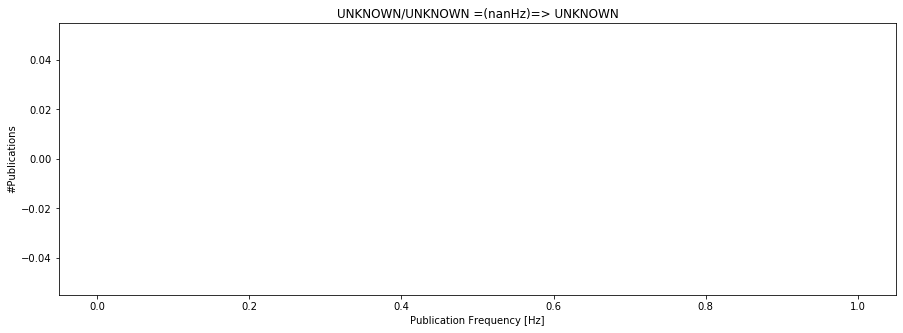

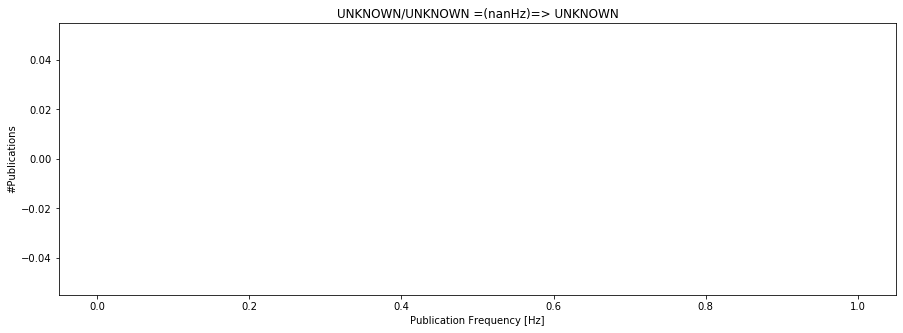

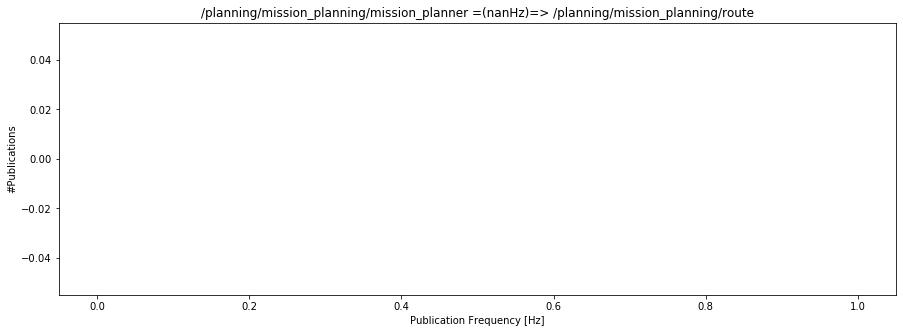

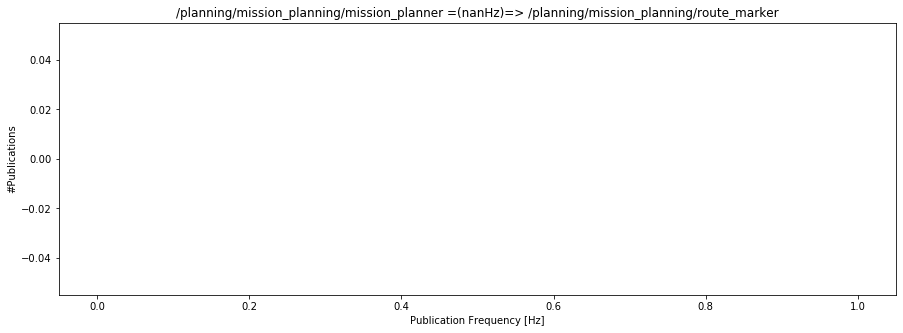

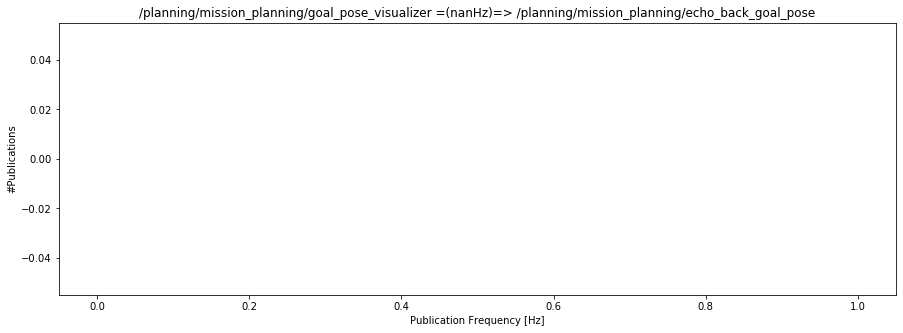

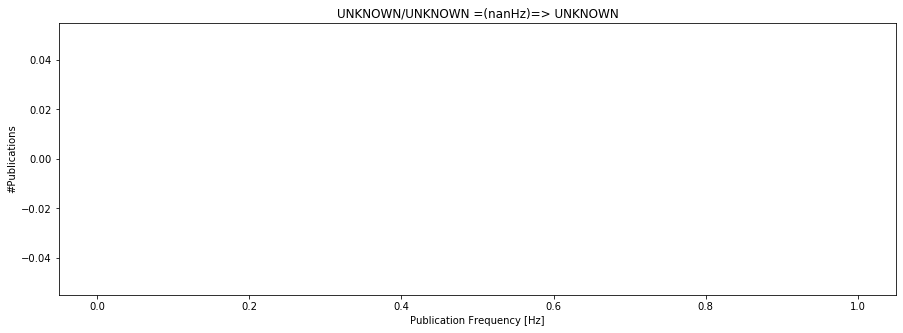

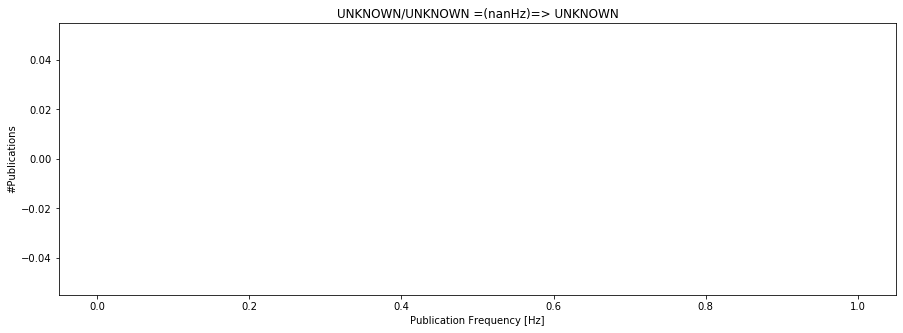

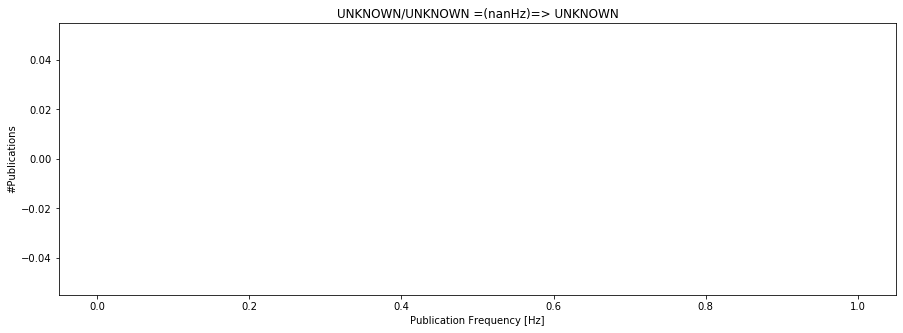

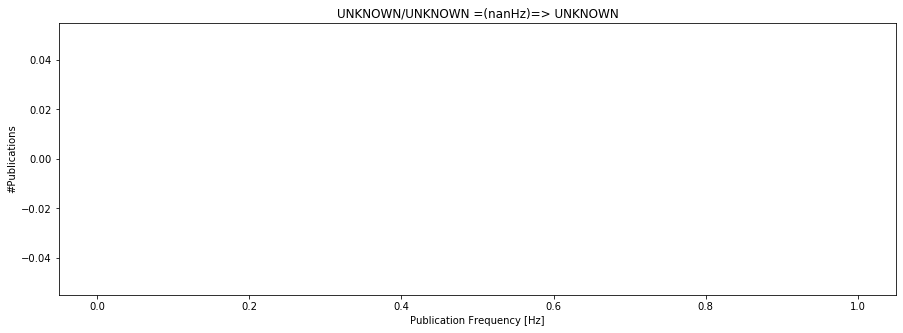

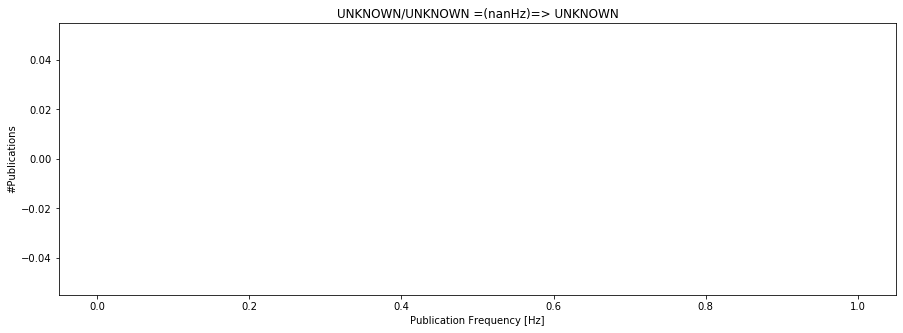

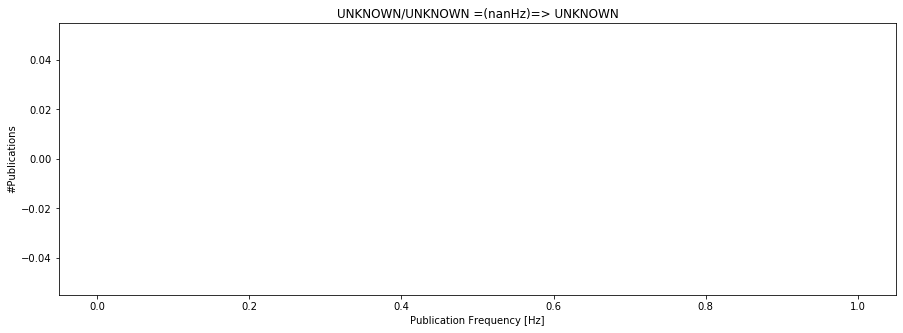

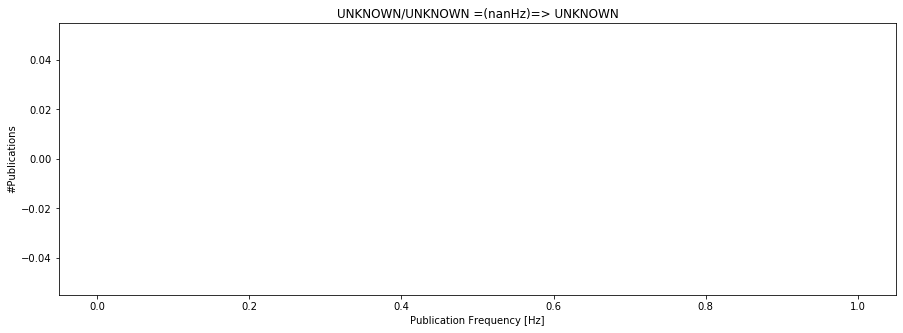

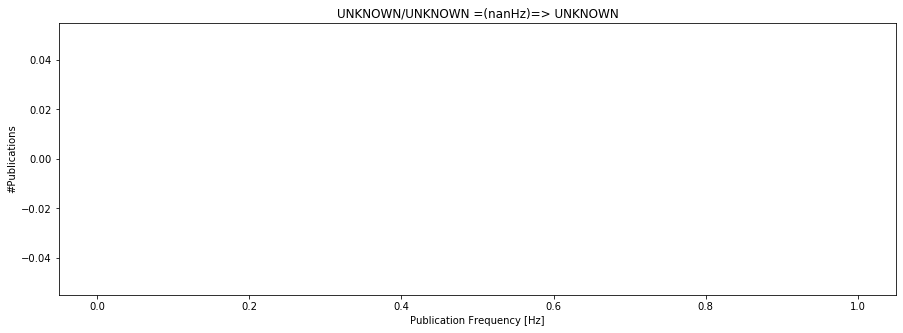

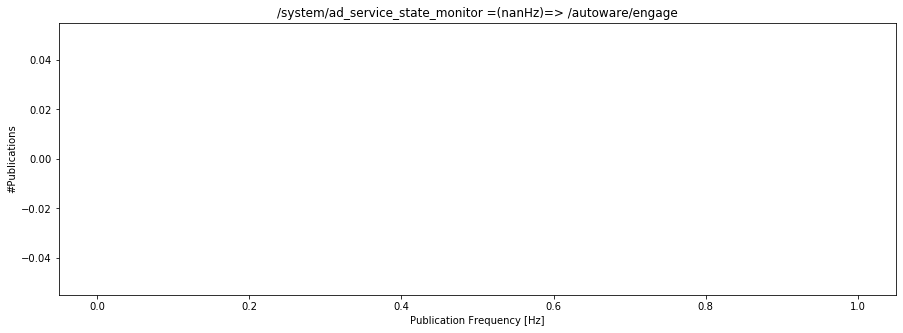

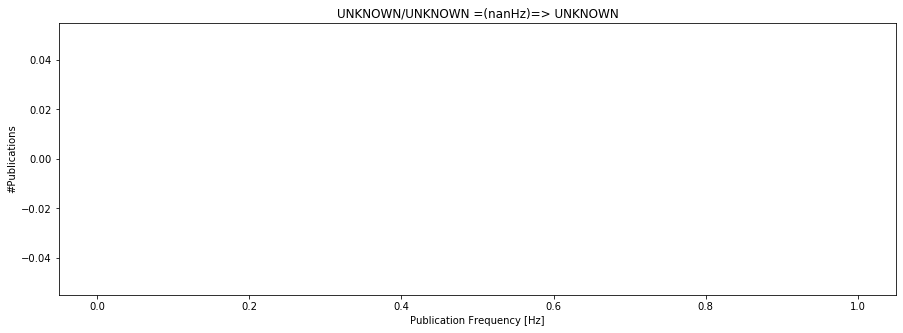

In [27]:
os.makedirs("figs", exist_ok=True)
for i, (k, v) in enumerate(sorted(pub_stats.items(), key=lambda kv: len(kv[1]['times']), reverse=True)):
    pub_time_diff = np.diff(np.array(v['times']))
    v['period'] = pub_time_diff.mean()
    v['period_std'] = pub_time_diff.std()
    v['frequency'] = 1 / v['period']
    v['frequency_std'] = (1/pub_time_diff).std()

    try:
        publisher_data = df_pub[df_pub.index==k]
        publisher_node = publisher_data["node_handle"].iloc[0]
        topic_name = publisher_data["topic_name"].iloc[0]
        node_name = handler.data.nodes[handler.data.nodes.index==publisher_node]["name"].iloc[0]
        node_scope = handler.data.nodes[handler.data.nodes.index==publisher_node]["namespace"].iloc[0]

    except Exception as e:
        node_name="UNKNOWN"
        topic_name="UNKNOWN"
        node_scope="UNKNOWN"
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.hist(1/pub_time_diff)
    ax.set_xlabel("Publication Frequency [Hz]")
    ax.set_ylabel("#Publications")
    ax.set_title(f"{os.path.join(node_scope, node_name)} =({v['frequency']:.2f}Hz)=> {topic_name}")
    plt.savefig(f"figs/{i:06}{os.path.join(node_scope, node_name).replace('/','-')}__{topic_name.replace('/','-')}")

    
print(f"#Topics: {len(topics)}; #Cohorts: {len(topic_cohorts)}")

In [7]:
node_filters = ["transform_listener_impl", "_monitor"]
topic_filters = ["/rosout", "/parameter_events", "/diagnostics"]

from pyvis.network import Network
net = Network(notebook=True, height='750px', width='100%', bgcolor='#ffffff', font_color='#000000')

net.add_node("INPUT", label="Input", size=100, color="green", physics=False, x=0, y=0)
net.add_node("OUTPUT", label="Output", size=100, color="red", physics=False, x=6000, y=0)


for handle, node in nodes.items():
    if any(f in node['name'] for f in node_filters): 
        continue
    net.add_node(handle, label=node['name'], size=20, color="#333")

for cohort_key, cohort_topic_names in topic_cohorts.items():
    cohort_topic_names = [name for name in cohort_topic_names if not any(f in name for f in topic_filters)]
    if not cohort_topic_names: 
        continue
    cohort_id="\n".join(cohort_topic_names)
    cohort_weight=len(cohort_topic_names)
    net.add_node(cohort_id, label=" ", title=cohort_id, size=5, color="#333")
    
    pubs = cohort_key[0]
    subs = cohort_key[1]
    n_pubs = len(pubs)
    n_subs = len(subs)
    
    try:
        if not n_pubs:
            net.add_edge("INPUT", cohort_id, arrows="to", color="green", weight=cohort_weight)
        if not n_subs:
            net.add_edge(cohort_id, "OUTPUT", arrows="to", color="red", weight=cohort_weight)

        for pub in pubs:
            net.add_edge(pub, cohort_id, arrows="to", color="green", weight=cohort_weight)
        for sub in subs:
            net.add_edge(cohort_id, sub, arrows="to", color="red", weight=cohort_weight)
    except:
        continue

net.toggle_physics(True)
net.show_buttons()
net.show("graph.html")